In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pickle
import tensorflow as tf
import trieste
from trieste.acquisition.optimizer import generate_continuous_optimizer
from trieste.acquisition.function.updated_constrained_thompson_sampling import UpdatedThompsonSamplingAugmentedLagrangian
from trieste.acquisition.rule import EfficientGlobalOptimization
from trieste.models.gpflow import build_gpr, GaussianProcessRegression
from trieste.space import Box
from functions import constraints
from functions import objectives

/Users/thomaschristie/Documents/GitHub.nosync/trieste/venv/lib/python3.10/site-packages/gpflow/experimental/utils.py:42: UserWarning: You're calling gpflow.experimental.check_shapes.decorator.check_shapes which is considered *experimental*. Expect: breaking changes, poor documentation, and bugs.
  warn(
/Users/thomaschristie/Documents/GitHub.nosync/trieste/venv/lib/python3.10/site-packages/gpflow/experimental/utils.py:42: UserWarning: You're calling gpflow.experimental.check_shapes.inheritance.inherit_check_shapes which is considered *experimental*. Expect: breaking changes, poor documentation, and bugs.
  warn(
2023-02-08 22:11:38.360602: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [3]:
NUM_INITIAL_SAMPLES = 5
OBJECTIVE = "OBJECTIVE"
INEQUALITY_CONSTRAINT_ONE = "INEQUALITY_CONSTRAINT_ONE"
INEQUALITY_CONSTRAINT_TWO = "INEQUALITY_CONSTRAINT_TWO"
search_space = Box([0.0, 0.0], [1.0, 1.0])

In [3]:
def create_model(data):
    gpr = build_gpr(data, search_space, likelihood_variance=1e-7)
    return GaussianProcessRegression(gpr, num_rff_features=500)

In [ ]:
for run in range(20):
    observer = trieste.objectives.utils.mk_multi_observer(
        OBJECTIVE=objectives.linear_objective,
        INEQUALITY_CONSTRAINT_ONE=constraints.toy_constraint_one,
        INEQUALITY_CONSTRAINT_TWO=constraints.toy_constraint_two)


    initial_inputs = search_space.sample(NUM_INITIAL_SAMPLES)
    initial_data = observer(initial_inputs)
    initial_models = trieste.utils.map_values(create_model, initial_data)

    inequality_lambda = {INEQUALITY_CONSTRAINT_ONE: tf.Variable(0.0, dtype=tf.float64),
                         INEQUALITY_CONSTRAINT_TWO: tf.Variable(0.0, dtype=tf.float64)}
    initial_penalty = tf.Variable(0.5, dtype=tf.float64)

    augmented_lagrangian = UpdatedThompsonSamplingAugmentedLagrangian(OBJECTIVE, "INEQUALITY", None, inequality_lambda, None,
                                                               initial_penalty, 0.001, search_space)

    rule = EfficientGlobalOptimization(augmented_lagrangian, optimizer=generate_continuous_optimizer())
    bo = trieste.bayesian_optimizer.BayesianOptimizer(observer, search_space)
    data = bo.optimize(40, initial_data, initial_models, rule, track_state=True).try_get_final_datasets()
    with open(f"results/31-01-23/run_{run}_data.pkl", 'wb') as fp:
        pickle.dump(data, fp)

### Progression of Best Valid Point over Time

In [8]:
all_results = []
for run in range(20):
    with open(f"results/31-01-23/run_{run}_data.pkl", "rb") as fp:
        run_data = pickle.load(fp)
    inequality_constraint_one_satisfied = run_data[INEQUALITY_CONSTRAINT_ONE].observations.numpy().squeeze() <= 0
    inequality_constraint_two_satisfied = run_data[INEQUALITY_CONSTRAINT_TWO].observations.numpy().squeeze() <= 0
    satisfied_mask = np.logical_and(inequality_constraint_one_satisfied, inequality_constraint_two_satisfied)
    failure_mask = np.logical_not(satisfied_mask)
    objective_vals = run_data[OBJECTIVE].observations.numpy().squeeze()
    safe_obs_values = objective_vals.copy()
    safe_obs_values[failure_mask] = np.max(safe_obs_values)
    all_results.append(np.minimum.accumulate(safe_obs_values))
all_results = np.array(all_results)
all_results_mean = np.mean(all_results, axis=0)

In [12]:
updated_all_results = []
for run in range(20):
    with open(f"results/08-02-23/penalty_0_5_lambda_10_10/run_{run}_data.pkl", "rb") as fp:
        run_data = pickle.load(fp)
    inequality_constraint_one_satisfied = run_data[INEQUALITY_CONSTRAINT_ONE].observations.numpy().squeeze() <= 0
    inequality_constraint_two_satisfied = run_data[INEQUALITY_CONSTRAINT_TWO].observations.numpy().squeeze() <= 0
    satisfied_mask = np.logical_and(inequality_constraint_one_satisfied, inequality_constraint_two_satisfied)
    failure_mask = np.logical_not(satisfied_mask)
    objective_vals = run_data[OBJECTIVE].observations.numpy().squeeze()
    safe_obs_values = objective_vals.copy()
    safe_obs_values[failure_mask] = np.max(safe_obs_values)
    updated_all_results.append(np.minimum.accumulate(safe_obs_values))
updated_all_results = np.array(updated_all_results)
updated_all_results_mean = np.mean(updated_all_results, axis=0)

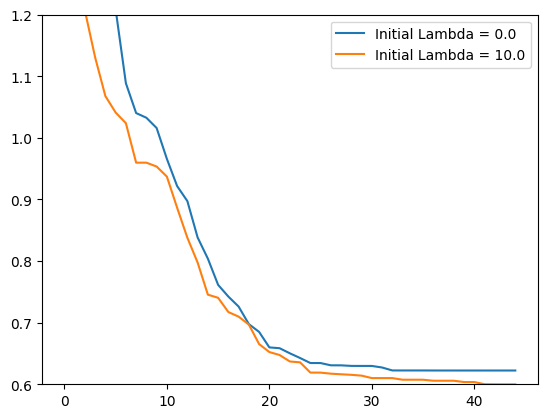

In [15]:
plt.plot(all_results_mean, label="Initial Lambda = 0.0")
plt.plot(updated_all_results_mean, label="Initial Lambda = 10.0")
plt.ylim(0.6, 1.2)
plt.legend()
plt.show()

In [11]:
all_results

array([[1.24579494, 1.24579494, 1.24579494, 1.24579494, 1.24579494,
        1.24579494, 1.24579494, 1.24579494, 1.24579494, 1.13391762,
        1.13391762, 1.13391762, 0.99112084, 0.99112084, 0.8039187 ,
        0.75626403, 0.75626403, 0.75535759, 0.63682512, 0.61230373,
        0.60362503, 0.60362503, 0.60362503, 0.6000311 , 0.6000311 ,
        0.6000311 , 0.6000311 , 0.5998815 , 0.5998815 , 0.5998815 ,
        0.5998815 , 0.5998815 , 0.59986391, 0.59986391, 0.59986391,
        0.59986391, 0.59986391, 0.59986391, 0.59986391, 0.59980622,
        0.59980622, 0.59980622, 0.59980622, 0.59980622, 0.59980622],
       [1.93449605, 1.38217359, 1.38217359, 1.38217359, 1.34016633,
        1.14245143, 1.14245143, 1.14245143, 1.14245143, 1.14245143,
        1.14245143, 0.76716355, 0.76716355, 0.76716355, 0.76212225,
        0.75092549, 0.75010107, 0.75010107, 0.75010107, 0.75010107,
        0.75010107, 0.75010107, 0.75010107, 0.75000073, 0.75000073,
        0.75000073, 0.75000073, 0.75000073, 0.7

### Plot Query Points on Objective

In [21]:
with open("results/31-01-23/run_16_data.pkl", "rb") as fp:
    data = pickle.load(fp)

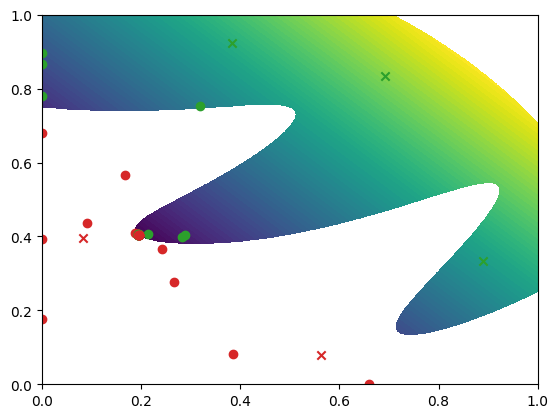

In [22]:
def masked_objective(x):
    mask_nan = np.logical_or(
        constraints.toy_constraint_one(x) > 0.0,
        constraints.toy_constraint_two(x) > 0.0,
    )
    y = np.array(objectives.linear_objective(x))
    y[mask_nan] = np.nan
    return tf.convert_to_tensor(y.reshape(-1, 1), x.dtype)


mask_fail1 = (
    data[INEQUALITY_CONSTRAINT_ONE].observations.numpy().flatten() > 0
)
mask_fail2 = (
    data[INEQUALITY_CONSTRAINT_TWO].observations.numpy().flatten() > 0
)
mask_fail = np.logical_or(mask_fail1, mask_fail2)

import matplotlib.pyplot as plt
from trieste.experimental.plotting import plot_function_2d, plot_bo_points

fig, ax = plot_function_2d(
    masked_objective,
    search_space.lower,
    search_space.upper,
    grid_density=1000,
    contour=True,
    fill=True,
)
plot_bo_points(
    data[OBJECTIVE].query_points.numpy(),
    ax=ax[0, 0],
    num_init=NUM_INITIAL_SAMPLES,
    mask_fail=mask_fail,
)
plt.show()

### Progression of Lambda Over Time

In [22]:
RUN = "five"

with open(f"results/08-02-23/penalty_8_lambda_0_0/run_{RUN}/inequality_lambda_progression.pkl", "rb") as fp:
    inequality_lambda = pickle.load(fp)

with open(f"results/08-02-23/penalty_8_lambda_0_0/run_{RUN}/penalty_progression.pkl", "rb") as fp:
    penalty_progression = pickle.load(fp)

with open(f"results/08-02-23/penalty_8_lambda_0_0/run_{RUN}/datapoints.pkl", "rb") as fp:
    data = pickle.load(fp)

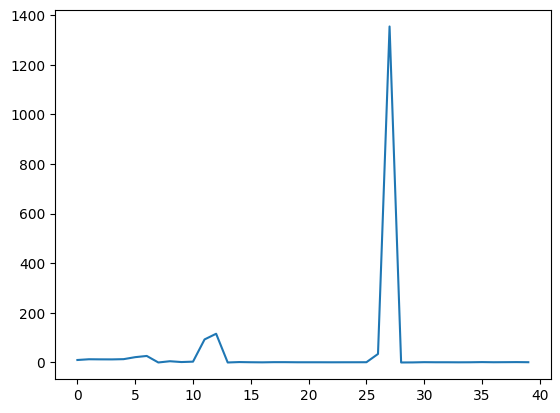

In [23]:
plt.plot(inequality_lambda[INEQUALITY_CONSTRAINT_ONE])

In [24]:
for i in range(len(penalty_progression)):
    print(f"Iteration: {i} Penalty: {penalty_progression[i]} Lambda: {inequality_lambda[INEQUALITY_CONSTRAINT_ONE][i]} Ineq Cons One: {data[INEQUALITY_CONSTRAINT_ONE].observations[5:][i]}, Objective: {data[OBJECTIVE].observations[5:][i]}")

Iteration: 0 Penalty: <tf.Variable 'Variable:0' shape=() dtype=float64, numpy=0.5> Lambda: <tf.Variable 'Variable:0' shape=() dtype=float64, numpy=10.0> Ineq Cons One: [1.5], Objective: [0.]
Iteration: 1 Penalty: 0.25 Lambda: [[13.]] Ineq Cons One: [-0.10469011], Objective: [1.15275983]
Iteration: 2 Penalty: 0.25 Lambda: [[12.58123956]] Ineq Cons One: [-0.03794617], Objective: [0.64134472]
Iteration: 3 Penalty: 0.25 Lambda: [[12.42945486]] Ineq Cons One: [0.23818661], Objective: [0.38182582]
Iteration: 4 Penalty: 0.125 Lambda: [[13.3822013]] Ineq Cons One: [1.00971307], Objective: [0.85421498]
Iteration: 5 Penalty: 0.0625 Lambda: [[21.45990583]] Ineq Cons One: [0.30367559], Objective: [0.44920652]
Iteration: 6 Penalty: 0.03125 Lambda: [[26.31871521]] Ineq Cons One: [-0.84971726], Objective: [0.96620318]
Iteration: 7 Penalty: 0.03125 Lambda: [[0.]] Ineq Cons One: [0.15643082], Objective: [0.49547879]
Iteration: 8 Penalty: 0.015625 Lambda: [[5.00578625]] Ineq Cons One: [-0.05099663], Obj

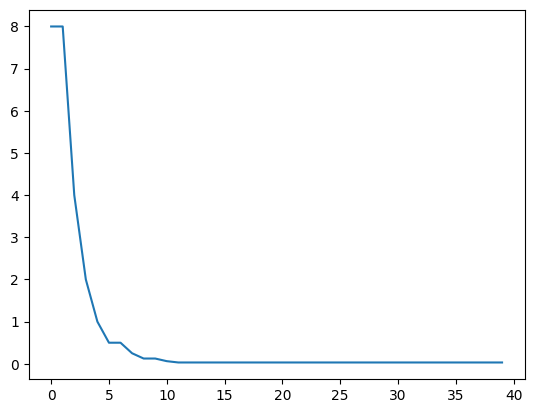

In [59]:
plt.plot(penalty_progression)

In [29]:
with open("results/08-02-23/run_three/datapoints.pkl", "rb") as fp:
    data = pickle.load(fp)

In [44]:
data[INEQUALITY_CONSTRAINT_ONE].observations[5:]

40

### Second Experiment - Different Starting Lambda

In [4]:
for run in range(20):
    observer = trieste.objectives.utils.mk_multi_observer(
        OBJECTIVE=objectives.linear_objective,
        INEQUALITY_CONSTRAINT_ONE=constraints.toy_constraint_one,
        INEQUALITY_CONSTRAINT_TWO=constraints.toy_constraint_two)


    initial_inputs = search_space.sample(NUM_INITIAL_SAMPLES)
    initial_data = observer(initial_inputs)
    initial_models = trieste.utils.map_values(create_model, initial_data)

    inequality_lambda = {INEQUALITY_CONSTRAINT_ONE: tf.Variable(10.0, dtype=tf.float64),
                         INEQUALITY_CONSTRAINT_TWO: tf.Variable(10.0, dtype=tf.float64)}
    initial_penalty = tf.Variable(0.5, dtype=tf.float64)

    save_path = f"results/08-02-23/penalty_0_5_lambda_10_10/run_{run}"
    augmented_lagrangian = UpdatedThompsonSamplingAugmentedLagrangian(OBJECTIVE, "INEQUALITY", None, inequality_lambda, None,
                                                               initial_penalty, 0.001, search_space, save_lambda=True, save_path=save_path)

    rule = EfficientGlobalOptimization(augmented_lagrangian, optimizer=generate_continuous_optimizer())
    bo = trieste.bayesian_optimizer.BayesianOptimizer(observer, search_space)
    data = bo.optimize(40, initial_data, initial_models, rule, track_state=True).try_get_final_datasets()
    with open(f"results/08-02-23/penalty_0_5_lambda_10_10/run_{run}_data.pkl", 'wb') as fp:
        pickle.dump(data, fp)

/Users/thomaschristie/Documents/GitHub.nosync/trieste/venv/lib/python3.10/site-packages/gpflow/experimental/utils.py:42: UserWarning: You're calling gpflow.experimental.check_shapes.checker.ShapeChecker.__init__ which is considered *experimental*. Expect: breaking changes, poor documentation, and bugs.
  warn(
2023-02-08 13:11:14.133159: W tensorflow/python/util/util.cc:368] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.
2023-02-08 13:11:17.530622: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 13:11:19.447984: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 13:11:20.828457: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/bra

2023-02-08 13:11:27.269533: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 13:11:28.615492: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 13:11:30.162525: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9


Inequality Lambda: {'INEQUALITY_CONSTRAINT_ONE': <tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[10.21113045]])>, 'INEQUALITY_CONSTRAINT_TWO': <tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[8.11948019]])>}
Not Satisfied. Updated Penalty: 0.25
Objective X: [0.61438029 0.42693906] Value: [1.04131935]


2023-02-08 13:11:31.799624: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 13:11:33.127759: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 13:11:34.422168: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9


Inequality Lambda: {'INEQUALITY_CONSTRAINT_ONE': <tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[16.75849913]])>, 'INEQUALITY_CONSTRAINT_TWO': <tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[2.23225789]])>}
Not Satisfied. Updated Penalty: 0.125
Objective X: [0.11859853 0.11886468] Value: [0.23746322]


2023-02-08 13:11:36.364901: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 13:11:37.639695: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 13:11:38.906502: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9


Inequality Lambda: {'INEQUALITY_CONSTRAINT_ONE': <tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[20.96064786]])>, 'INEQUALITY_CONSTRAINT_TWO': <tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[0.]])>}
Not Satisfied. Updated Penalty: 0.0625
Objective X: [0.         0.50590744] Value: [0.50590744]


2023-02-08 13:11:40.815992: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 13:11:42.089847: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 13:11:43.397676: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9


Inequality Lambda: {'INEQUALITY_CONSTRAINT_ONE': <tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[21.52521792]])>, 'INEQUALITY_CONSTRAINT_TWO': <tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[0.]])>}
Not Satisfied. Updated Penalty: 0.03125
Objective X: [0.90457294 0.48634734] Value: [1.39092028]


2023-02-08 13:11:45.394259: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 13:11:47.197522: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 13:11:48.531645: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9


Inequality Lambda: {'INEQUALITY_CONSTRAINT_ONE': <tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[45.17409]])>, 'INEQUALITY_CONSTRAINT_TWO': <tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[0.]])>}
Not Satisfied. Updated Penalty: 0.015625
Objective X: [0.        0.6299942] Value: [0.6299942]


2023-02-08 13:11:50.370322: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 13:11:52.051255: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 13:11:53.335189: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9


Inequality Lambda: {'INEQUALITY_CONSTRAINT_ONE': <tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[81.35695344]])>, 'INEQUALITY_CONSTRAINT_TWO': <tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[0.]])>}
Not Satisfied. Updated Penalty: 0.0078125
Objective X: [0.56530057 0.14809927] Value: [0.71339984]


2023-02-08 13:11:55.238047: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 13:11:56.534811: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 13:11:58.203068: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9


Inequality Lambda: {'INEQUALITY_CONSTRAINT_ONE': <tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[143.89793655]])>, 'INEQUALITY_CONSTRAINT_TWO': <tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[0.]])>}
Not Satisfied. Updated Penalty: 0.00390625
Objective X: [0.51314918 0.        ] Value: [0.51314918]


2023-02-08 13:11:59.985619: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 13:12:01.279435: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 13:12:02.934459: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9


Inequality Lambda: {'INEQUALITY_CONSTRAINT_ONE': <tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[0.]])>, 'INEQUALITY_CONSTRAINT_TWO': <tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[0.]])>}
Satisfied
Objective X: [0.45129197 0.94413245] Value: [1.39542442]


2023-02-08 13:12:04.721384: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 13:12:06.056276: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 13:12:07.342897: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9


Inequality Lambda: {'INEQUALITY_CONSTRAINT_ONE': <tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[37.86743403]])>, 'INEQUALITY_CONSTRAINT_TWO': <tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[0.]])>}
Not Satisfied. Updated Penalty: 0.001953125
Objective X: [0.12201358 0.45011899] Value: [0.57213257]


2023-02-08 13:12:09.638432: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 13:12:11.006195: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 13:12:12.267039: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9


Inequality Lambda: {'INEQUALITY_CONSTRAINT_ONE': <tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[73.5171788]])>, 'INEQUALITY_CONSTRAINT_TWO': <tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[0.]])>}
Not Satisfied. Updated Penalty: 0.0009765625
Objective X: [0.25305627 0.36804542] Value: [0.62110169]


2023-02-08 13:12:14.367960: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 13:12:16.115724: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 13:12:17.464752: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9


Inequality Lambda: {'INEQUALITY_CONSTRAINT_ONE': <tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[27.97491771]])>, 'INEQUALITY_CONSTRAINT_TWO': <tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[0.]])>}
Satisfied
Objective X: [0.22302955 0.41557454] Value: [0.63860409]


2023-02-08 13:12:19.471172: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 13:12:21.177622: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 13:12:22.500498: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9


Inequality Lambda: {'INEQUALITY_CONSTRAINT_ONE': <tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[3.05089066]])>, 'INEQUALITY_CONSTRAINT_TWO': <tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[0.]])>}
Satisfied
Objective X: [0.20697083 0.41699763] Value: [0.62396846]


2023-02-08 13:12:24.590162: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 13:12:25.893849: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 13:12:27.606953: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9


Inequality Lambda: {'INEQUALITY_CONSTRAINT_ONE': <tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[0.]])>, 'INEQUALITY_CONSTRAINT_TWO': <tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[0.]])>}
Satisfied
Objective X: [0.19348315 0.41134202] Value: [0.60482517]


2023-02-08 13:12:29.696078: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 13:12:31.024685: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 13:12:32.354206: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9


Inequality Lambda: {'INEQUALITY_CONSTRAINT_ONE': <tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[0.23268906]])>, 'INEQUALITY_CONSTRAINT_TWO': <tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[0.]])>}
Satisfied
Objective X: [0.19369532 0.40598205] Value: [0.59967738]


2023-02-08 13:12:34.946678: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 13:12:36.220229: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 13:12:37.636101: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9


Inequality Lambda: {'INEQUALITY_CONSTRAINT_ONE': <tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[0.98190714]])>, 'INEQUALITY_CONSTRAINT_TWO': <tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[0.]])>}
Satisfied
Objective X: [0.19365412 0.40555023] Value: [0.59920435]


2023-02-08 13:12:39.554812: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 13:12:42.366814: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 13:12:44.566030: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9


Inequality Lambda: {'INEQUALITY_CONSTRAINT_ONE': <tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[1.02522458]])>, 'INEQUALITY_CONSTRAINT_TWO': <tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[0.]])>}
Satisfied
Objective X: [0.19460672 0.40515665] Value: [0.59976337]


2023-02-08 13:12:46.366833: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 13:12:47.625928: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 13:12:49.264674: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9


Inequality Lambda: {'INEQUALITY_CONSTRAINT_ONE': <tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[1.04903574]])>, 'INEQUALITY_CONSTRAINT_TWO': <tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[0.]])>}
Satisfied
Objective X: [0.19541642 0.40435613] Value: [0.59977255]


2023-02-08 13:12:51.002671: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 13:12:52.309638: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 13:12:53.825859: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9


Inequality Lambda: {'INEQUALITY_CONSTRAINT_ONE': <tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[0.87923302]])>, 'INEQUALITY_CONSTRAINT_TWO': <tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[0.]])>}
Satisfied
Objective X: [0.19590871 0.40404199] Value: [0.5999507]


2023-02-08 13:12:56.100929: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 13:12:57.433228: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 13:12:58.692074: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9


Inequality Lambda: {'INEQUALITY_CONSTRAINT_ONE': <tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[0.94056834]])>, 'INEQUALITY_CONSTRAINT_TWO': <tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[0.]])>}
Satisfied
Objective X: [0.19496001 0.40477724] Value: [0.59973724]


2023-02-08 13:13:00.770669: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 13:13:03.169499: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 13:13:05.451957: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9


Inequality Lambda: {'INEQUALITY_CONSTRAINT_ONE': <tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[1.20660753]])>, 'INEQUALITY_CONSTRAINT_TWO': <tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[0.]])>}
Satisfied
Objective X: [0.19460202 0.40496808] Value: [0.59957011]


2023-02-08 13:13:07.744038: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 13:13:09.218450: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 13:13:11.073315: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9


Inequality Lambda: {'INEQUALITY_CONSTRAINT_ONE': <tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[1.03317914]])>, 'INEQUALITY_CONSTRAINT_TWO': <tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[0.]])>}
Satisfied
Objective X: [0.19649287 0.40350847] Value: [0.60000134]


2023-02-08 13:13:13.223420: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 13:13:14.576272: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 13:13:16.045798: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9


Inequality Lambda: {'INEQUALITY_CONSTRAINT_ONE': <tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[1.03263744]])>, 'INEQUALITY_CONSTRAINT_TWO': <tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[0.]])>}
Satisfied
Objective X: [0.19480736 0.40498602] Value: [0.59979338]


2023-02-08 13:13:20.061924: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 13:13:21.332248: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 13:13:22.577745: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9


Inequality Lambda: {'INEQUALITY_CONSTRAINT_ONE': <tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[0.93509593]])>, 'INEQUALITY_CONSTRAINT_TWO': <tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[0.]])>}
Satisfied
Objective X: [0.19519132 0.40467862] Value: [0.59986994]


2023-02-08 13:13:24.493771: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 13:13:26.194733: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 13:13:27.459731: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9


Inequality Lambda: {'INEQUALITY_CONSTRAINT_ONE': <tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[0.93831552]])>, 'INEQUALITY_CONSTRAINT_TWO': <tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[0.]])>}
Satisfied
Objective X: [0.19545198 0.40433848] Value: [0.59979046]


2023-02-08 13:13:29.288760: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 13:13:30.524150: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 13:13:32.261329: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9


Inequality Lambda: {'INEQUALITY_CONSTRAINT_ONE': <tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[0.90173873]])>, 'INEQUALITY_CONSTRAINT_TWO': <tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[0.]])>}
Satisfied
Objective X: [0.19556546 0.40426132] Value: [0.59982678]


2023-02-08 13:13:34.053689: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 13:13:35.332682: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 13:13:36.598690: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9


Inequality Lambda: {'INEQUALITY_CONSTRAINT_ONE': <tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[0.89412511]])>, 'INEQUALITY_CONSTRAINT_TWO': <tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[0.]])>}
Satisfied
Objective X: [0.19510453 0.40468994] Value: [0.59979447]


2023-02-08 13:13:39.249072: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 13:13:40.556366: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 13:13:41.823671: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9


Inequality Lambda: {'INEQUALITY_CONSTRAINT_ONE': <tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[0.86329138]])>, 'INEQUALITY_CONSTRAINT_TWO': <tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[0.]])>}
Satisfied
Objective X: [0.19449336 0.4053419 ] Value: [0.59983526]


2023-02-08 13:13:43.665886: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 13:13:45.398467: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 13:13:46.635322: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9


Inequality Lambda: {'INEQUALITY_CONSTRAINT_ONE': <tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[0.73119162]])>, 'INEQUALITY_CONSTRAINT_TWO': <tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[0.]])>}
Satisfied
Objective X: [0.19527974 0.4046194 ] Value: [0.59989914]


2023-02-08 13:13:48.704111: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9


2023-02-08 13:13:49.987551: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 13:13:51.259841: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9


Inequality Lambda: {'INEQUALITY_CONSTRAINT_ONE': <tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[0.87849875]])>, 'INEQUALITY_CONSTRAINT_TWO': <tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[0.]])>}
Satisfied
Objective X: [0.19427287 0.4054197 ] Value: [0.59969257]


2023-02-08 13:13:53.557088: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 13:13:54.836006: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 13:13:56.122658: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9


Inequality Lambda: {'INEQUALITY_CONSTRAINT_ONE': <tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[0.76313814]])>, 'INEQUALITY_CONSTRAINT_TWO': <tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[0.]])>}
Satisfied
Objective X: [0.19585378 0.40405026] Value: [0.59990404]


2023-02-08 13:13:58.031181: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 13:13:59.784871: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 13:14:01.046751: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9


Inequality Lambda: {'INEQUALITY_CONSTRAINT_ONE': <tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[0.99217721]])>, 'INEQUALITY_CONSTRAINT_TWO': <tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[0.]])>}
Satisfied
Objective X: [0.19428077 0.40533829] Value: [0.59961906]


2023-02-08 13:14:02.800172: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 13:14:04.047193: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 13:14:05.817545: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9


Inequality Lambda: {'INEQUALITY_CONSTRAINT_ONE': <tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[0.95919876]])>, 'INEQUALITY_CONSTRAINT_TWO': <tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[0.]])>}
Satisfied
Objective X: [0.19441535 0.40542743] Value: [0.59984278]


2023-02-08 13:14:07.598448: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 13:14:08.859353: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 13:14:10.093583: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9


Inequality Lambda: {'INEQUALITY_CONSTRAINT_ONE': <tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[0.93882892]])>, 'INEQUALITY_CONSTRAINT_TWO': <tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[0.]])>}
Satisfied
Objective X: [0.195886   0.40394442] Value: [0.59983042]


2023-02-08 13:14:12.606851: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 13:14:13.880833: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 13:14:15.128727: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9


Inequality Lambda: {'INEQUALITY_CONSTRAINT_ONE': <tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[1.07287987]])>, 'INEQUALITY_CONSTRAINT_TWO': <tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[0.]])>}
Satisfied
Objective X: [0.19568036 0.40401447] Value: [0.59969483]


2023-02-08 13:14:17.009953: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 13:14:18.283744: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 13:14:20.036051: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9


Inequality Lambda: {'INEQUALITY_CONSTRAINT_ONE': <tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[0.87648792]])>, 'INEQUALITY_CONSTRAINT_TWO': <tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[0.]])>}
Satisfied
Objective X: [0.19534248 0.40461074] Value: [0.59995323]


2023-02-08 13:14:21.881730: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 13:14:23.123546: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 13:14:24.376875: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9


Inequality Lambda: {'INEQUALITY_CONSTRAINT_ONE': <tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[1.11160379]])>, 'INEQUALITY_CONSTRAINT_TWO': <tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[0.]])>}
Satisfied
Objective X: [0.19593951 0.40369398] Value: [0.59963349]


2023-02-08 13:14:26.733578: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 13:14:28.020312: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 13:14:29.247662: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9


Inequality Lambda: {'INEQUALITY_CONSTRAINT_ONE': <tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[0.75928876]])>, 'INEQUALITY_CONSTRAINT_TWO': <tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[0.]])>}
Satisfied
Objective X: [0.19576033 0.40433045] Value: [0.60009078]


2023-02-08 13:14:31.112928: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 13:14:32.378154: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 13:14:34.092835: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9


Inequality Lambda: {'INEQUALITY_CONSTRAINT_ONE': <tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[1.11790047]])>, 'INEQUALITY_CONSTRAINT_TWO': <tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[0.]])>}
Satisfied
Objective X: [0.19452794 0.40496473] Value: [0.59949267]


2023-02-08 13:14:36.031046: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 13:14:37.277426: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 13:14:38.573395: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9


Inequality Lambda: {'INEQUALITY_CONSTRAINT_ONE': <tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[1.27378373]])>, 'INEQUALITY_CONSTRAINT_TWO': <tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[0.]])>}
Satisfied
Objective X: [0.19450735 0.4051625 ] Value: [0.59966985]


2023-02-08 13:14:40.947094: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 13:14:42.201667: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 13:14:43.468542: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9


Optimization completed without errors


2023-02-08 13:14:44.954191: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 13:14:46.227725: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 13:14:48.140863: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 13:14:53.621997: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 13:14:54.871862: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 13:14:56.124090: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge

Inequality Lambda: {'INEQUALITY_CONSTRAINT_ONE': <tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[11.4782168]])>, 'INEQUALITY_CONSTRAINT_TWO': <tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[7.75243146]])>}
Not Satisfied. Updated Penalty: 0.25
Objective X: [0.02914137 0.61267162] Value: [0.64181299]


2023-02-08 13:14:57.727341: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 13:14:59.417014: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 13:15:00.672861: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9


Inequality Lambda: {'INEQUALITY_CONSTRAINT_ONE': <tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[11.14787221]])>, 'INEQUALITY_CONSTRAINT_TWO': <tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[6.02281113]])>}
Satisfied
Objective X: [1.         0.25999023] Value: [1.25999023]


2023-02-08 13:15:02.242996: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 13:15:03.525198: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 13:15:05.245859: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9


Inequality Lambda: {'INEQUALITY_CONSTRAINT_ONE': <tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[16.58494563]])>, 'INEQUALITY_CONSTRAINT_TWO': <tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[0.21443963]])>}
Not Satisfied. Updated Penalty: 0.125
Objective X: [0.10175627 0.19378541] Value: [0.29554169]


2023-02-08 13:15:06.808698: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 13:15:08.112151: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 13:15:09.357403: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9


Inequality Lambda: {'INEQUALITY_CONSTRAINT_ONE': <tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[13.18476241]])>, 'INEQUALITY_CONSTRAINT_TWO': <tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[0.]])>}
Satisfied
Objective X: [0.67354129 0.7795732 ] Value: [1.45311448]


2023-02-08 13:15:10.936918: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 13:15:12.700692: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 13:15:13.967375: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9


Inequality Lambda: {'INEQUALITY_CONSTRAINT_ONE': <tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[11.40882062]])>, 'INEQUALITY_CONSTRAINT_TWO': <tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[0.]])>}
Satisfied
Objective X: [0.38275366 0.78505599] Value: [1.16780964]


2023-02-08 13:15:15.553596: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 13:15:16.799592: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 13:15:18.562735: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9


Inequality Lambda: {'INEQUALITY_CONSTRAINT_ONE': <tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[7.17101163]])>, 'INEQUALITY_CONSTRAINT_TWO': <tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[0.]])>}
Satisfied
Objective X: [0.58656392 0.64838224] Value: [1.23494615]


2023-02-08 13:15:20.137260: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 13:15:21.397143: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 13:15:22.984486: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9


Inequality Lambda: {'INEQUALITY_CONSTRAINT_ONE': <tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[0.92409847]])>, 'INEQUALITY_CONSTRAINT_TWO': <tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[0.]])>}
Satisfied
Objective X: [0.73270269 0.58613033] Value: [1.31883303]


2023-02-08 13:15:24.624108: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 13:15:26.432229: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 13:15:27.748003: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9


Inequality Lambda: {'INEQUALITY_CONSTRAINT_ONE': <tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[2.68636141]])>, 'INEQUALITY_CONSTRAINT_TWO': <tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[0.]])>}
Not Satisfied. Updated Penalty: 0.0625
Objective X: [0.26508959 0.54821397] Value: [0.81330356]


2023-02-08 13:15:29.381779: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 13:15:30.649729: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 13:15:32.445439: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9


Inequality Lambda: {'INEQUALITY_CONSTRAINT_ONE': <tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[0.]])>, 'INEQUALITY_CONSTRAINT_TWO': <tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[0.]])>}
Satisfied
Objective X: [0.34251367 0.48512562] Value: [0.82763929]


2023-02-08 13:15:34.199972: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 13:15:35.486014: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 13:15:36.904571: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9


Inequality Lambda: {'INEQUALITY_CONSTRAINT_ONE': <tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[17.34369353]])>, 'INEQUALITY_CONSTRAINT_TWO': <tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[0.]])>}
Not Satisfied. Updated Penalty: 0.03125
Objective X: [0.23957993 0.        ] Value: [0.23957993]


2023-02-08 13:15:38.705174: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 13:15:40.699792: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 13:15:42.123116: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9


Inequality Lambda: {'INEQUALITY_CONSTRAINT_ONE': <tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[0.50041198]])>, 'INEQUALITY_CONSTRAINT_TWO': <tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[0.]])>}
Satisfied
Objective X: [0.50076175 0.52177907] Value: [1.02254082]


2023-02-08 13:15:44.143926: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 13:15:45.602071: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 13:15:47.526505: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9


Inequality Lambda: {'INEQUALITY_CONSTRAINT_ONE': <tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[1.09267454]])>, 'INEQUALITY_CONSTRAINT_TWO': <tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[0.]])>}
Not Satisfied. Updated Penalty: 0.015625
Objective X: [0.18285871 0.43436428] Value: [0.617223]


2023-02-08 13:15:49.844787: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 13:15:51.269614: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 13:15:52.591321: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9


Inequality Lambda: {'INEQUALITY_CONSTRAINT_ONE': <tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[41.05828027]])>, 'INEQUALITY_CONSTRAINT_TWO': <tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[0.]])>}
Not Satisfied. Updated Penalty: 0.0078125
Objective X: [0.         0.29742994] Value: [0.29742994]


2023-02-08 13:15:54.547068: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 13:15:56.431943: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 13:15:57.749061: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9


Inequality Lambda: {'INEQUALITY_CONSTRAINT_ONE': <tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[6.05652839]])>, 'INEQUALITY_CONSTRAINT_TWO': <tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[0.]])>}
Satisfied
Objective X: [0.         0.78377511] Value: [0.78377511]


2023-02-08 13:15:59.420757: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 13:16:00.729448: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 13:16:02.215420: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9


Inequality Lambda: {'INEQUALITY_CONSTRAINT_ONE': <tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[0.]])>, 'INEQUALITY_CONSTRAINT_TWO': <tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[0.]])>}
Satisfied
Objective X: [0.24100761 0.44758682] Value: [0.68859443]


2023-02-08 13:16:06.492326: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 13:16:07.861464: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 13:16:09.171931: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9


Inequality Lambda: {'INEQUALITY_CONSTRAINT_ONE': <tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[0.35908872]])>, 'INEQUALITY_CONSTRAINT_TWO': <tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[0.]])>}
Not Satisfied. Updated Penalty: 0.00390625
Objective X: [0.19267083 0.43427572] Value: [0.62694655]


2023-02-08 13:16:11.009719: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 13:16:12.301906: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 13:16:14.122080: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9


Inequality Lambda: {'INEQUALITY_CONSTRAINT_ONE': <tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[61.7687531]])>, 'INEQUALITY_CONSTRAINT_TWO': <tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[0.]])>}
Not Satisfied. Updated Penalty: 0.001953125
Objective X: [0.         0.42144586] Value: [0.42144586]


2023-02-08 13:16:16.084457: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 13:16:17.439029: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 13:16:18.792610: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9


Inequality Lambda: {'INEQUALITY_CONSTRAINT_ONE': <tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[335.04611564]])>, 'INEQUALITY_CONSTRAINT_TWO': <tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[0.]])>}
Not Satisfied. Updated Penalty: 0.0009765625
Objective X: [0.61218077 0.        ] Value: [0.61218077]


2023-02-08 13:16:20.810649: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 13:16:22.760729: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 13:16:25.176939: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9


Inequality Lambda: {'INEQUALITY_CONSTRAINT_ONE': <tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[0.]])>, 'INEQUALITY_CONSTRAINT_TWO': <tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[0.]])>}
Satisfied
Objective X: [0.40653876 0.48163122] Value: [0.88816998]


2023-02-08 13:16:28.225715: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 13:16:29.546660: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 13:16:31.372505: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9


Inequality Lambda: {'INEQUALITY_CONSTRAINT_ONE': <tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[0.]])>, 'INEQUALITY_CONSTRAINT_TWO': <tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[0.]])>}
Satisfied
Objective X: [0.20088766 0.41989032] Value: [0.62077798]


2023-02-08 13:16:33.226077: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 13:16:34.492803: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 13:16:35.737817: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9


Inequality Lambda: {'INEQUALITY_CONSTRAINT_ONE': <tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[16.35213011]])>, 'INEQUALITY_CONSTRAINT_TWO': <tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[0.]])>}
Not Satisfied. Updated Penalty: 0.00048828125
Objective X: [0.18642216 0.39992976] Value: [0.58635192]


2023-02-08 13:16:37.811750: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 13:16:39.630949: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 13:16:40.879992: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9


Inequality Lambda: {'INEQUALITY_CONSTRAINT_ONE': <tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[0.]])>, 'INEQUALITY_CONSTRAINT_TWO': <tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[0.]])>}
Satisfied
Objective X: [0.19876128 0.40899071] Value: [0.60775199]


2023-02-08 13:16:42.816760: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 13:16:44.086112: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 13:16:45.352815: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9


Inequality Lambda: {'INEQUALITY_CONSTRAINT_ONE': <tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[0.43962639]])>, 'INEQUALITY_CONSTRAINT_TWO': <tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[0.]])>}
Satisfied
Objective X: [0.19454683 0.40506539] Value: [0.59961222]


2023-02-08 13:16:47.814243: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 13:16:49.086644: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 13:16:50.349495: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9


Inequality Lambda: {'INEQUALITY_CONSTRAINT_ONE': <tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[3.89614477]])>, 'INEQUALITY_CONSTRAINT_TWO': <tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[0.]])>}
Not Satisfied. Updated Penalty: 0.000244140625
Objective X: [0.19118891 0.40760101] Value: [0.59878992]


2023-02-08 13:16:52.324243: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 13:16:53.576633: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 13:16:55.426688: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9


Inequality Lambda: {'INEQUALITY_CONSTRAINT_ONE': <tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[2.02361259]])>, 'INEQUALITY_CONSTRAINT_TWO': <tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[0.]])>}
Satisfied
Objective X: [0.19704727 0.40324166] Value: [0.60028893]


2023-02-08 13:16:57.579182: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 13:16:58.821915: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 13:17:00.104798: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9


Inequality Lambda: {'INEQUALITY_CONSTRAINT_ONE': <tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[0.51375297]])>, 'INEQUALITY_CONSTRAINT_TWO': <tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[0.]])>}
Satisfied
Objective X: [0.1949515 0.4051629] Value: [0.6001144]


2023-02-08 13:17:02.000363: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 13:17:03.881391: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 13:17:05.151632: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9


Inequality Lambda: {'INEQUALITY_CONSTRAINT_ONE': <tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[2.3665675]])>, 'INEQUALITY_CONSTRAINT_TWO': <tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[0.]])>}
Satisfied
Objective X: [0.19587566 0.40357488] Value: [0.59945055]


2023-02-08 13:17:07.247980: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 13:17:08.517415: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 13:17:09.801555: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9


Inequality Lambda: {'INEQUALITY_CONSTRAINT_ONE': <tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[1.19032224]])>, 'INEQUALITY_CONSTRAINT_TWO': <tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[0.]])>}
Satisfied
Objective X: [0.19534475 0.40469016] Value: [0.60003491]


2023-02-08 13:17:12.336588: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 13:17:13.608030: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 13:17:14.851637: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9


Inequality Lambda: {'INEQUALITY_CONSTRAINT_ONE': <tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[1.24037529]])>, 'INEQUALITY_CONSTRAINT_TWO': <tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[0.]])>}
Satisfied
Objective X: [0.19511464 0.40466291] Value: [0.59977755]


2023-02-08 13:17:16.994693: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 13:17:18.239575: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 13:17:20.112146: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9


Inequality Lambda: {'INEQUALITY_CONSTRAINT_ONE': <tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[1.77992946]])>, 'INEQUALITY_CONSTRAINT_TWO': <tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[0.]])>}
Satisfied
Objective X: [0.19420238 0.40550717] Value: [0.59970955]


2023-02-08 13:17:22.398420: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 13:17:23.667901: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 13:17:24.921546: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9


Inequality Lambda: {'INEQUALITY_CONSTRAINT_ONE': <tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[0.44815465]])>, 'INEQUALITY_CONSTRAINT_TWO': <tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[0.]])>}
Satisfied
Objective X: [0.19529039 0.40477737] Value: [0.60006776]


2023-02-08 13:17:26.750001: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 13:17:28.633926: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 13:17:29.901872: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9


Inequality Lambda: {'INEQUALITY_CONSTRAINT_ONE': <tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[1.18050756]])>, 'INEQUALITY_CONSTRAINT_TWO': <tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[0.]])>}
Satisfied
Objective X: [0.1948344  0.40480115] Value: [0.59963556]


2023-02-08 13:17:31.860830: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 13:17:33.106561: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 13:17:34.355527: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9


Inequality Lambda: {'INEQUALITY_CONSTRAINT_ONE': <tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[1.64542532]])>, 'INEQUALITY_CONSTRAINT_TWO': <tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[0.]])>}
Satisfied
Objective X: [0.19492706 0.40476403] Value: [0.59969109]


2023-02-08 13:17:36.108091: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 13:17:37.954762: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 13:17:39.226485: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9


Inequality Lambda: {'INEQUALITY_CONSTRAINT_ONE': <tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[1.84151381]])>, 'INEQUALITY_CONSTRAINT_TWO': <tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[0.]])>}
Satisfied
Objective X: [0.19630356 0.40350776] Value: [0.59981131]


2023-02-08 13:17:41.142266: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 13:17:42.406628: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 13:17:43.674409: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9


Inequality Lambda: {'INEQUALITY_CONSTRAINT_ONE': <tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[0.82144417]])>, 'INEQUALITY_CONSTRAINT_TWO': <tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[0.]])>}
Satisfied
Objective X: [0.19523911 0.40476321] Value: [0.60000232]


2023-02-08 13:17:46.208502: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 13:17:47.455843: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 13:17:48.722855: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9


Inequality Lambda: {'INEQUALITY_CONSTRAINT_ONE': <tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[0.97079813]])>, 'INEQUALITY_CONSTRAINT_TWO': <tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[0.]])>}
Satisfied
Objective X: [0.1944705  0.40530586] Value: [0.59977636]


2023-02-08 13:17:50.730309: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 13:17:51.982892: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 13:17:53.870753: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9


Inequality Lambda: {'INEQUALITY_CONSTRAINT_ONE': <tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[1.04891217]])>, 'INEQUALITY_CONSTRAINT_TWO': <tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[0.]])>}
Satisfied
Objective X: [0.1955166  0.40426274] Value: [0.59977934]


2023-02-08 13:17:55.788479: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 13:17:57.028540: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 13:17:58.323951: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9


Inequality Lambda: {'INEQUALITY_CONSTRAINT_ONE': <tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[1.89917626]])>, 'INEQUALITY_CONSTRAINT_TWO': <tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[0.]])>}
Satisfied
Objective X: [0.19354048 0.40617975] Value: [0.59972022]


2023-02-08 13:18:00.241008: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 13:18:01.476818: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 13:18:03.407718: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9


Inequality Lambda: {'INEQUALITY_CONSTRAINT_ONE': <tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[1.38162448]])>, 'INEQUALITY_CONSTRAINT_TWO': <tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[0.]])>}
Satisfied
Objective X: [0.19510111 0.40479617] Value: [0.59989729]


2023-02-08 13:18:05.393852: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 13:18:06.667685: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 13:18:07.962451: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9


Optimization completed without errors


2023-02-08 13:18:09.461668: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 13:18:11.474998: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 13:18:12.742734: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 13:18:18.429789: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 13:18:19.714436: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 13:18:20.984583: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge

Inequality Lambda: {'INEQUALITY_CONSTRAINT_ONE': <tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[8.08338941]])>, 'INEQUALITY_CONSTRAINT_TWO': <tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[8.82009203]])>}
Satisfied
Objective X: [0.17189801 0.93834806] Value: [1.11024607]


2023-02-08 13:18:22.571276: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 13:18:23.846122: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 13:18:25.740005: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9


Inequality Lambda: {'INEQUALITY_CONSTRAINT_ONE': <tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[5.79615797]])>, 'INEQUALITY_CONSTRAINT_TWO': <tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[7.69613092]])>}
Satisfied
Objective X: [0.31549724 0.91568605] Value: [1.23118329]


2023-02-08 13:18:27.450564: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 13:18:28.740591: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 13:18:30.031137: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9


Inequality Lambda: {'INEQUALITY_CONSTRAINT_ONE': <tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[8.97706654]])>, 'INEQUALITY_CONSTRAINT_TWO': <tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[4.69705549]])>}
Not Satisfied. Updated Penalty: 0.25
Objective X: [0.         0.02150081] Value: [0.02150081]


2023-02-08 13:18:31.640318: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 13:18:32.916392: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 13:18:34.854759: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9


Inequality Lambda: {'INEQUALITY_CONSTRAINT_ONE': <tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[4.26687467]])>, 'INEQUALITY_CONSTRAINT_TWO': <tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[2.55858055]])>}
Satisfied
Objective X: [0.34328515 0.92061749] Value: [1.26390265]


2023-02-08 13:18:36.477665: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 13:18:37.726631: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 13:18:38.996233: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9


Inequality Lambda: {'INEQUALITY_CONSTRAINT_ONE': <tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[0.89232723]])>, 'INEQUALITY_CONSTRAINT_TWO': <tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[0.]])>}
Satisfied
Objective X: [0.07303459 0.9202526 ] Value: [0.99328719]


2023-02-08 13:18:40.622887: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 13:18:42.597361: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 13:18:44.121552: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9


Inequality Lambda: {'INEQUALITY_CONSTRAINT_ONE': <tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[2.55629424]])>, 'INEQUALITY_CONSTRAINT_TWO': <tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[0.]])>}
Not Satisfied. Updated Penalty: 0.125
Objective X: [0.         0.69684691] Value: [0.69684691]


2023-02-08 13:18:45.773615: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 13:18:47.044519: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 13:18:48.336774: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9


Inequality Lambda: {'INEQUALITY_CONSTRAINT_ONE': <tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[14.09349376]])>, 'INEQUALITY_CONSTRAINT_TWO': <tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[0.]])>}
Not Satisfied. Updated Penalty: 0.0625
Objective X: [0.         0.19302121] Value: [0.19302121]


2023-02-08 13:18:50.674763: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 13:18:51.948348: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 13:18:53.218188: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9


Inequality Lambda: {'INEQUALITY_CONSTRAINT_ONE': <tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[0.32639487]])>, 'INEQUALITY_CONSTRAINT_TWO': <tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[0.]])>}
Satisfied
Objective X: [0.07869923 0.90382404] Value: [0.98252327]


2023-02-08 13:18:54.855991: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 13:18:56.104723: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 13:18:57.357051: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9


Inequality Lambda: {'INEQUALITY_CONSTRAINT_ONE': <tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[3.51181576]])>, 'INEQUALITY_CONSTRAINT_TWO': <tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[0.]])>}
Not Satisfied. Updated Penalty: 0.03125
Objective X: [0.07216583 0.44211157] Value: [0.51427741]


2023-02-08 13:18:59.828112: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 13:19:01.115672: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 13:19:02.387959: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9


Inequality Lambda: {'INEQUALITY_CONSTRAINT_ONE': <tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[0.]])>, 'INEQUALITY_CONSTRAINT_TWO': <tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[0.]])>}
Satisfied
Objective X: [0.         0.77760037] Value: [0.77760037]


2023-02-08 13:19:04.084959: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 13:19:05.530185: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 13:19:07.525084: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9


Inequality Lambda: {'INEQUALITY_CONSTRAINT_ONE': <tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[0.05873227]])>, 'INEQUALITY_CONSTRAINT_TWO': <tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[0.]])>}
Not Satisfied. Updated Penalty: 0.015625
Objective X: [0.18792545 0.42254482] Value: [0.61047027]


2023-02-08 13:19:09.323732: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 13:19:10.643968: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 13:19:11.956859: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9


Inequality Lambda: {'INEQUALITY_CONSTRAINT_ONE': <tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[0.]])>, 'INEQUALITY_CONSTRAINT_TWO': <tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[0.]])>}
Satisfied
Objective X: [0.19664573 0.41126543] Value: [0.60791115]


2023-02-08 13:19:13.559650: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 13:19:14.805141: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 13:19:16.723963: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9


Inequality Lambda: {'INEQUALITY_CONSTRAINT_ONE': <tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[2.87324467]])>, 'INEQUALITY_CONSTRAINT_TWO': <tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[0.]])>}
Not Satisfied. Updated Penalty: 0.0078125
Objective X: [0.15766033 0.40436036] Value: [0.56202069]


2023-02-08 13:19:18.414160: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 13:19:19.654908: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 13:19:20.923645: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9


Inequality Lambda: {'INEQUALITY_CONSTRAINT_ONE': <tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[0.71880947]])>, 'INEQUALITY_CONSTRAINT_TWO': <tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[0.]])>}
Satisfied
Objective X: [0.20670903 0.40750888] Value: [0.61421791]


2023-02-08 13:19:22.911486: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 13:19:24.863115: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 13:19:26.461348: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9


Inequality Lambda: {'INEQUALITY_CONSTRAINT_ONE': <tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[0.96666086]])>, 'INEQUALITY_CONSTRAINT_TWO': <tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[0.]])>}
Not Satisfied. Updated Penalty: 0.00390625
Objective X: [0.19516645 0.40304622] Value: [0.59821267]


2023-02-08 13:19:28.493048: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 13:19:29.738024: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 13:19:31.047986: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9


Inequality Lambda: {'INEQUALITY_CONSTRAINT_ONE': <tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[0.7778955]])>, 'INEQUALITY_CONSTRAINT_TWO': <tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[0.]])>}
Satisfied
Objective X: [0.19539335 0.40503186] Value: [0.60042521]


2023-02-08 13:19:33.066440: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 13:19:35.030400: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 13:19:36.292986: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9


Inequality Lambda: {'INEQUALITY_CONSTRAINT_ONE': <tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[1.08813325]])>, 'INEQUALITY_CONSTRAINT_TWO': <tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[0.]])>}
Not Satisfied. Updated Penalty: 0.001953125
Objective X: [0.19302947 0.40579444] Value: [0.59882391]


2023-02-08 13:19:38.136935: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 13:19:39.397222: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 13:19:40.701499: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9


Inequality Lambda: {'INEQUALITY_CONSTRAINT_ONE': <tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[0.96122578]])>, 'INEQUALITY_CONSTRAINT_TWO': <tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[0.]])>}
Satisfied
Objective X: [0.1945408  0.40548977] Value: [0.60003057]


2023-02-08 13:19:43.301436: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 13:19:44.556057: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 13:19:45.813484: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9


Inequality Lambda: {'INEQUALITY_CONSTRAINT_ONE': <tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[0.83882727]])>, 'INEQUALITY_CONSTRAINT_TWO': <tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[0.]])>}
Satisfied
Objective X: [0.1955547  0.40444198] Value: [0.59999668]


2023-02-08 13:19:48.006808: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 13:19:49.253656: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 13:19:50.555548: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9


Inequality Lambda: {'INEQUALITY_CONSTRAINT_ONE': <tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[1.16507784]])>, 'INEQUALITY_CONSTRAINT_TWO': <tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[0.]])>}
Satisfied
Objective X: [0.19674937 0.40267025] Value: [0.59941963]


2023-02-08 13:19:53.129247: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 13:19:54.369702: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 13:19:55.640763: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9


Inequality Lambda: {'INEQUALITY_CONSTRAINT_ONE': <tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[0.89443928]])>, 'INEQUALITY_CONSTRAINT_TWO': <tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[0.]])>}
Satisfied
Objective X: [0.19465578 0.4056236 ] Value: [0.60027938]


2023-02-08 13:19:57.600186: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 13:19:58.835385: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 13:20:00.102578: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9


Inequality Lambda: {'INEQUALITY_CONSTRAINT_ONE': <tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[0.88664563]])>, 'INEQUALITY_CONSTRAINT_TWO': <tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[0.]])>}
Satisfied
Objective X: [0.19434831 0.40548422] Value: [0.59983253]


2023-02-08 13:20:02.580795: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 13:20:03.836963: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 13:20:05.108745: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9


Inequality Lambda: {'INEQUALITY_CONSTRAINT_ONE': <tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[0.8942082]])>, 'INEQUALITY_CONSTRAINT_TWO': <tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[0.]])>}
Satisfied
Objective X: [0.19437185 0.40543127] Value: [0.59980312]


2023-02-08 13:20:06.953008: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 13:20:08.213541: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 13:20:09.452898: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9


Inequality Lambda: {'INEQUALITY_CONSTRAINT_ONE': <tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[0.82418241]])>, 'INEQUALITY_CONSTRAINT_TWO': <tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[0.]])>}
Satisfied
Objective X: [0.19493789 0.40497166] Value: [0.59990955]


2023-02-08 13:20:12.036988: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 13:20:13.283563: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 13:20:14.533372: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9


Inequality Lambda: {'INEQUALITY_CONSTRAINT_ONE': <tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[0.90955712]])>, 'INEQUALITY_CONSTRAINT_TWO': <tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[0.]])>}
Satisfied
Objective X: [0.19592289 0.40375957] Value: [0.59968245]


2023-02-08 13:20:16.434781: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 13:20:17.708422: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 13:20:18.940219: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9


Inequality Lambda: {'INEQUALITY_CONSTRAINT_ONE': <tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[0.89748057]])>, 'INEQUALITY_CONSTRAINT_TWO': <tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[0.]])>}
Satisfied
Objective X: [0.19499319 0.40481618] Value: [0.59980937]


2023-02-08 13:20:21.573468: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 13:20:22.941787: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 13:20:24.239873: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9


Inequality Lambda: {'INEQUALITY_CONSTRAINT_ONE': <tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[0.91030564]])>, 'INEQUALITY_CONSTRAINT_TWO': <tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[0.]])>}
Satisfied
Objective X: [0.1949075 0.4048609] Value: [0.5997684]


2023-02-08 13:20:25.981981: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 13:20:27.267158: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 13:20:28.526206: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9


Inequality Lambda: {'INEQUALITY_CONSTRAINT_ONE': <tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[0.90011333]])>, 'INEQUALITY_CONSTRAINT_TWO': <tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[0.]])>}
Satisfied
Objective X: [0.19452345 0.4053006 ] Value: [0.59982405]


2023-02-08 13:20:31.143033: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 13:20:32.395451: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 13:20:33.634290: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9


Inequality Lambda: {'INEQUALITY_CONSTRAINT_ONE': <tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[0.85197198]])>, 'INEQUALITY_CONSTRAINT_TWO': <tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[0.]])>}
Satisfied
Objective X: [0.19572222 0.40415959] Value: [0.59988181]


2023-02-08 13:20:35.453455: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 13:20:36.726061: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 13:20:37.980140: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9


Inequality Lambda: {'INEQUALITY_CONSTRAINT_ONE': <tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[0.8081885]])>, 'INEQUALITY_CONSTRAINT_TWO': <tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[0.]])>}
Satisfied
Objective X: [0.19437658 0.40551828] Value: [0.59989486]


2023-02-08 13:20:40.642447: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 13:20:41.912352: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 13:20:43.178094: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9


Inequality Lambda: {'INEQUALITY_CONSTRAINT_ONE': <tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[0.86542725]])>, 'INEQUALITY_CONSTRAINT_TWO': <tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[0.]])>}
Satisfied
Objective X: [0.19444819 0.40526138] Value: [0.59970957]


2023-02-08 13:20:45.027778: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 13:20:46.312361: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 13:20:47.566820: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9


Inequality Lambda: {'INEQUALITY_CONSTRAINT_ONE': <tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[0.89465169]])>, 'INEQUALITY_CONSTRAINT_TWO': <tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[0.]])>}
Satisfied
Objective X: [0.19392133 0.40588846] Value: [0.59980979]


2023-02-08 13:20:50.153128: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 13:20:51.420643: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 13:20:52.674970: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9


Inequality Lambda: {'INEQUALITY_CONSTRAINT_ONE': <tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[0.90626532]])>, 'INEQUALITY_CONSTRAINT_TWO': <tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[0.]])>}
Satisfied
Objective X: [0.19604989 0.40375823] Value: [0.59980812]


2023-02-08 13:20:54.581247: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 13:20:55.855216: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 13:20:57.100038: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9


Inequality Lambda: {'INEQUALITY_CONSTRAINT_ONE': <tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[0.88314988]])>, 'INEQUALITY_CONSTRAINT_TWO': <tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[0.]])>}
Satisfied
Objective X: [0.19497135 0.40485715] Value: [0.5998285]


2023-02-08 13:20:59.743654: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 13:21:01.016053: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 13:21:02.278739: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9


Inequality Lambda: {'INEQUALITY_CONSTRAINT_ONE': <tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[0.84335091]])>, 'INEQUALITY_CONSTRAINT_TWO': <tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[0.]])>}
Satisfied
Objective X: [0.19517139 0.40468349] Value: [0.59985488]


2023-02-08 13:21:04.299372: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 13:21:05.598650: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 13:21:06.864709: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9


Inequality Lambda: {'INEQUALITY_CONSTRAINT_ONE': <tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[0.8276821]])>, 'INEQUALITY_CONSTRAINT_TWO': <tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[0.]])>}
Satisfied
Objective X: [0.19507682 0.40473777] Value: [0.59981458]


2023-02-08 13:21:09.675918: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 13:21:10.935333: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 13:21:12.186524: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9


Inequality Lambda: {'INEQUALITY_CONSTRAINT_ONE': <tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[0.88746219]])>, 'INEQUALITY_CONSTRAINT_TWO': <tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[0.]])>}
Satisfied
Objective X: [0.19532012 0.40437127] Value: [0.59969139]


2023-02-08 13:21:14.063381: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 13:21:15.313715: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 13:21:16.563198: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9


Inequality Lambda: {'INEQUALITY_CONSTRAINT_ONE': <tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[0.80300522]])>, 'INEQUALITY_CONSTRAINT_TWO': <tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[0.]])>}
Satisfied
Objective X: [0.19475084 0.40519099] Value: [0.59994183]


2023-02-08 13:21:18.468515: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 13:21:20.463483: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 13:21:21.755592: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9


Inequality Lambda: {'INEQUALITY_CONSTRAINT_ONE': <tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[0.85646991]])>, 'INEQUALITY_CONSTRAINT_TWO': <tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[0.]])>}
Satisfied
Objective X: [0.19486376 0.40483615] Value: [0.59969991]


2023-02-08 13:21:23.572312: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 13:21:24.842487: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 13:21:26.080417: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9


Optimization completed without errors


2023-02-08 13:21:27.526895: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 13:21:29.645525: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 13:21:30.970529: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 13:21:36.702394: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 13:21:37.977160: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 13:21:39.244419: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge

Inequality Lambda: {'INEQUALITY_CONSTRAINT_ONE': <tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[9.28699275]])>, 'INEQUALITY_CONSTRAINT_TWO': <tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[8.57069616]])>}
Satisfied
Objective X: [0.37815958 0.80146329] Value: [1.17962287]


2023-02-08 13:21:40.924670: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 13:21:42.229261: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 13:21:43.514305: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9


Inequality Lambda: {'INEQUALITY_CONSTRAINT_ONE': <tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[11.99027573]])>, 'INEQUALITY_CONSTRAINT_TWO': <tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[5.74797583]])>}
Not Satisfied. Updated Penalty: 0.25
Objective X: [0.23266117 0.18576494] Value: [0.41842612]


2023-02-08 13:21:45.112477: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 13:21:47.150629: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 13:21:48.429049: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9


Inequality Lambda: {'INEQUALITY_CONSTRAINT_ONE': <tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[6.80184133]])>, 'INEQUALITY_CONSTRAINT_TWO': <tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[4.35477223]])>}
Satisfied
Objective X: [0.38948569 1.        ] Value: [1.38948569]


2023-02-08 13:21:50.045612: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 13:21:51.306079: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 13:21:52.602143: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9


Inequality Lambda: {'INEQUALITY_CONSTRAINT_ONE': <tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[5.60232107]])>, 'INEQUALITY_CONSTRAINT_TWO': <tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[0.67923736]])>}
Satisfied
Objective X: [0.59852695 0.47210356] Value: [1.07063051]


2023-02-08 13:21:54.163501: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 13:21:56.191652: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 13:21:57.489178: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9


Inequality Lambda: {'INEQUALITY_CONSTRAINT_ONE': <tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[4.76001239]])>, 'INEQUALITY_CONSTRAINT_TWO': <tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[0.]])>}
Satisfied
Objective X: [0.         0.77576179] Value: [0.77576179]


2023-02-08 13:21:59.146202: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 13:22:00.396483: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 13:22:01.689591: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9


Inequality Lambda: {'INEQUALITY_CONSTRAINT_ONE': <tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[6.66741456]])>, 'INEQUALITY_CONSTRAINT_TWO': <tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[0.]])>}
Not Satisfied. Updated Penalty: 0.125
Objective X: [0.54900313 0.        ] Value: [0.54900313]


2023-02-08 13:22:03.238487: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 13:22:05.255563: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 13:22:06.535468: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9


Inequality Lambda: {'INEQUALITY_CONSTRAINT_ONE': <tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[8.86614389]])>, 'INEQUALITY_CONSTRAINT_TWO': <tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[0.]])>}
Not Satisfied. Updated Penalty: 0.0625
Objective X: [0.        0.4388683] Value: [0.4388683]


2023-02-08 13:22:08.305249: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 13:22:09.563408: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 13:22:10.823262: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9


Inequality Lambda: {'INEQUALITY_CONSTRAINT_ONE': <tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[19.3393425]])>, 'INEQUALITY_CONSTRAINT_TWO': <tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[0.]])>}
Not Satisfied. Updated Penalty: 0.03125
Objective X: [0.         0.53821949] Value: [0.53821949]


2023-02-08 13:22:12.628679: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 13:22:14.681408: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 13:22:15.917041: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9


Inequality Lambda: {'INEQUALITY_CONSTRAINT_ONE': <tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[5.04179505]])>, 'INEQUALITY_CONSTRAINT_TWO': <tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[0.]])>}
Satisfied
Objective X: [0.         0.80767029] Value: [0.80767029]


2023-02-08 13:22:17.617011: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 13:22:18.875559: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 13:22:20.126877: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9


Inequality Lambda: {'INEQUALITY_CONSTRAINT_ONE': <tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[10.57152326]])>, 'INEQUALITY_CONSTRAINT_TWO': <tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[0.]])>}
Not Satisfied. Updated Penalty: 0.015625
Objective X: [0.20110447 0.49990221] Value: [0.70100668]


2023-02-08 13:22:21.933520: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 13:22:23.236530: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 13:22:25.304982: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9


Inequality Lambda: {'INEQUALITY_CONSTRAINT_ONE': <tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[0.35269021]])>, 'INEQUALITY_CONSTRAINT_TWO': <tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[0.]])>}
Satisfied
Objective X: [0.         0.76942214] Value: [0.76942214]


2023-02-08 13:22:26.910777: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 13:22:28.201116: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 13:22:29.463805: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9


Inequality Lambda: {'INEQUALITY_CONSTRAINT_ONE': <tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[96.35269021]])>, 'INEQUALITY_CONSTRAINT_TWO': <tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[0.]])>}
Not Satisfied. Updated Penalty: 0.0078125
Objective X: [0. 0.] Value: [0.]


2023-02-08 13:22:31.250587: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 13:22:32.525587: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 13:22:34.598161: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9


Inequality Lambda: {'INEQUALITY_CONSTRAINT_ONE': <tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[14.40695606]])>, 'INEQUALITY_CONSTRAINT_TWO': <tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[0.]])>}
Satisfied
Objective X: [0.04790089 0.83262199] Value: [0.88052288]


2023-02-08 13:22:36.556204: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 13:22:37.831688: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 13:22:39.087960: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9


Inequality Lambda: {'INEQUALITY_CONSTRAINT_ONE': <tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[0.]])>, 'INEQUALITY_CONSTRAINT_TWO': <tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[0.]])>}
Satisfied
Objective X: [0.29142029 0.46034728] Value: [0.75176756]


2023-02-08 13:22:40.899756: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 13:22:42.173406: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 13:22:43.440461: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9


Inequality Lambda: {'INEQUALITY_CONSTRAINT_ONE': <tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[0.]])>, 'INEQUALITY_CONSTRAINT_TWO': <tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[0.]])>}
Satisfied
Objective X: [0.22339757 0.42285036] Value: [0.64624793]


2023-02-08 13:22:46.161380: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 13:22:47.450144: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 13:22:48.703328: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9


Inequality Lambda: {'INEQUALITY_CONSTRAINT_ONE': <tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[0.]])>, 'INEQUALITY_CONSTRAINT_TWO': <tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[0.]])>}
Satisfied
Objective X: [0.19506654 0.41832008] Value: [0.61338662]


2023-02-08 13:22:50.712975: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 13:22:52.001791: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 13:22:53.246112: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9


Inequality Lambda: {'INEQUALITY_CONSTRAINT_ONE': <tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[0.74984494]])>, 'INEQUALITY_CONSTRAINT_TWO': <tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[0.]])>}
Not Satisfied. Updated Penalty: 0.00390625
Objective X: [0.1907311  0.40401536] Value: [0.59474646]


2023-02-08 13:22:55.854730: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 13:22:57.091114: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 13:22:58.369987: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9


Inequality Lambda: {'INEQUALITY_CONSTRAINT_ONE': <tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[1.18951346]])>, 'INEQUALITY_CONSTRAINT_TWO': <tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[0.]])>}
Not Satisfied. Updated Penalty: 0.001953125
Objective X: [0.19677664 0.40186327] Value: [0.59863992]


2023-02-08 13:23:00.120905: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 13:23:01.380425: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 13:23:02.672189: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9


Inequality Lambda: {'INEQUALITY_CONSTRAINT_ONE': <tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[1.05683131]])>, 'INEQUALITY_CONSTRAINT_TWO': <tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[0.]])>}
Satisfied
Objective X: [0.19530855 0.40470226] Value: [0.60001081]


2023-02-08 13:23:04.536807: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 13:23:06.606129: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 13:23:07.866159: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9


Inequality Lambda: {'INEQUALITY_CONSTRAINT_ONE': <tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[0.73753248]])>, 'INEQUALITY_CONSTRAINT_TWO': <tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[0.]])>}
Satisfied
Objective X: [0.19581099 0.40451571] Value: [0.6003267]


2023-02-08 13:23:09.635105: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 13:23:10.894467: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 13:23:12.183745: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9


Inequality Lambda: {'INEQUALITY_CONSTRAINT_ONE': <tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[0.76320472]])>, 'INEQUALITY_CONSTRAINT_TWO': <tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[0.]])>}
Satisfied
Objective X: [0.19491613 0.40483022] Value: [0.59974635]


2023-02-08 13:23:14.028071: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 13:23:15.294704: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 13:23:17.392273: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9


Inequality Lambda: {'INEQUALITY_CONSTRAINT_ONE': <tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[0.87738133]])>, 'INEQUALITY_CONSTRAINT_TWO': <tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[0.]])>}
Satisfied
Objective X: [0.19496176 0.40463458] Value: [0.59959634]


2023-02-08 13:23:19.207101: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 13:23:20.481514: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 13:23:21.772234: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9


Inequality Lambda: {'INEQUALITY_CONSTRAINT_ONE': <tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[0.93396211]])>, 'INEQUALITY_CONSTRAINT_TWO': <tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[0.]])>}
Satisfied
Objective X: [0.19368627 0.40610535] Value: [0.59979163]


2023-02-08 13:23:23.740758: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 13:23:24.992512: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 13:23:27.136307: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9


Inequality Lambda: {'INEQUALITY_CONSTRAINT_ONE': <tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[0.95913725]])>, 'INEQUALITY_CONSTRAINT_TWO': <tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[0.]])>}
Satisfied
Objective X: [0.19555229 0.40420345] Value: [0.59975574]


2023-02-08 13:23:28.953280: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 13:23:30.235427: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 13:23:31.531597: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9


Inequality Lambda: {'INEQUALITY_CONSTRAINT_ONE': <tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[1.00699365]])>, 'INEQUALITY_CONSTRAINT_TWO': <tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[0.]])>}
Satisfied
Objective X: [0.19359536 0.40622763] Value: [0.59982299]


2023-02-08 13:23:33.437305: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 13:23:34.731661: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 13:23:35.978930: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9


Inequality Lambda: {'INEQUALITY_CONSTRAINT_ONE': <tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[0.94970732]])>, 'INEQUALITY_CONSTRAINT_TWO': <tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[0.]])>}
Satisfied
Objective X: [0.19522559 0.40465867] Value: [0.59988426]


2023-02-08 13:23:38.743531: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 13:23:39.993631: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 13:23:41.262919: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9


Inequality Lambda: {'INEQUALITY_CONSTRAINT_ONE': <tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[0.86266933]])>, 'INEQUALITY_CONSTRAINT_TWO': <tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[0.]])>}
Satisfied
Objective X: [0.19529333 0.40464097] Value: [0.59993429]


2023-02-08 13:23:43.071222: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 13:23:44.341167: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 13:23:45.591740: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9


Inequality Lambda: {'INEQUALITY_CONSTRAINT_ONE': <tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[0.82809134]])>, 'INEQUALITY_CONSTRAINT_TWO': <tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[0.]])>}
Satisfied
Objective X: [0.1948145  0.40503787] Value: [0.59985237]


2023-02-08 13:23:47.329763: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 13:23:49.466014: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 13:23:50.735880: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9


Inequality Lambda: {'INEQUALITY_CONSTRAINT_ONE': <tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[0.93395612]])>, 'INEQUALITY_CONSTRAINT_TWO': <tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[0.]])>}
Satisfied
Objective X: [0.1954691 0.4041525] Value: [0.5996216]


2023-02-08 13:23:52.572603: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 13:23:53.833477: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 13:23:55.085167: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9


Inequality Lambda: {'INEQUALITY_CONSTRAINT_ONE': <tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[0.78716409]])>, 'INEQUALITY_CONSTRAINT_TWO': <tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[0.]])>}
Satisfied
Objective X: [0.19529981 0.40473474] Value: [0.60003455]


2023-02-08 13:23:56.877951: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 13:23:58.165803: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 13:24:00.309913: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9


Inequality Lambda: {'INEQUALITY_CONSTRAINT_ONE': <tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[0.93981416]])>, 'INEQUALITY_CONSTRAINT_TWO': <tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[0.]])>}
Satisfied
Objective X: [0.19404932 0.40552004] Value: [0.59956936]


2023-02-08 13:24:02.308362: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 13:24:03.590831: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 13:24:04.853251: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9


Inequality Lambda: {'INEQUALITY_CONSTRAINT_ONE': <tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[0.93062357]])>, 'INEQUALITY_CONSTRAINT_TWO': <tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[0.]])>}
Satisfied
Objective X: [0.19614576 0.40370285] Value: [0.5998486]


2023-02-08 13:24:06.711699: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 13:24:07.972635: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 13:24:09.205928: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9


Inequality Lambda: {'INEQUALITY_CONSTRAINT_ONE': <tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[0.84574524]])>, 'INEQUALITY_CONSTRAINT_TWO': <tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[0.]])>}
Satisfied
Objective X: [0.195859   0.40408883] Value: [0.59994783]


2023-02-08 13:24:11.866995: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 13:24:13.149429: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 13:24:14.500469: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9


Inequality Lambda: {'INEQUALITY_CONSTRAINT_ONE': <tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[0.80410201]])>, 'INEQUALITY_CONSTRAINT_TWO': <tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[0.]])>}
Satisfied
Objective X: [0.1954695  0.40439234] Value: [0.59986183]


2023-02-08 13:24:16.407396: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 13:24:17.665721: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 13:24:18.934218: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9


Inequality Lambda: {'INEQUALITY_CONSTRAINT_ONE': <tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[0.98842473]])>, 'INEQUALITY_CONSTRAINT_TWO': <tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[0.]])>}
Satisfied
Objective X: [0.19388774 0.40563988] Value: [0.59952762]


2023-02-08 13:24:20.747696: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 13:24:22.978945: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 13:24:24.236529: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9


Inequality Lambda: {'INEQUALITY_CONSTRAINT_ONE': <tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[180.83575442]])>, 'INEQUALITY_CONSTRAINT_TWO': <tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[0.]])>}
Not Satisfied. Updated Penalty: 0.0009765625
Objective X: [0.         0.34359035] Value: [0.34359035]


2023-02-08 13:24:26.102882: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 13:24:27.391359: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 13:24:28.683243: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9


Inequality Lambda: {'INEQUALITY_CONSTRAINT_ONE': <tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[0.]])>, 'INEQUALITY_CONSTRAINT_TWO': <tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[0.]])>}
Satisfied
Objective X: [0.31633454 0.4394945 ] Value: [0.75582904]


2023-02-08 13:24:31.827525: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 13:24:33.122807: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 13:24:35.301122: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9


Inequality Lambda: {'INEQUALITY_CONSTRAINT_ONE': <tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[0.91773604]])>, 'INEQUALITY_CONSTRAINT_TWO': <tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[0.]])>}
Satisfied
Objective X: [0.1950986  0.40393665] Value: [0.59903525]


2023-02-08 13:24:37.157446: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 13:24:38.400446: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 13:24:39.685603: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9


Inequality Lambda: {'INEQUALITY_CONSTRAINT_ONE': <tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[0.85193454]])>, 'INEQUALITY_CONSTRAINT_TWO': <tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[0.]])>}
Satisfied
Objective X: [0.19540496 0.40444093] Value: [0.59984589]


2023-02-08 13:24:41.622054: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 13:24:42.884097: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 13:24:44.136631: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9


Optimization completed without errors


2023-02-08 13:24:46.571212: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 13:24:47.889305: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 13:24:49.179175: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 13:24:54.293977: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 13:24:56.318894: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 13:24:57.573296: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge

Inequality Lambda: {'INEQUALITY_CONSTRAINT_ONE': <tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[10.7267256]])>, 'INEQUALITY_CONSTRAINT_TWO': <tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[7.64923128]])>}
Not Satisfied. Updated Penalty: 0.25
Objective X: [0.56362271 0.08333717] Value: [0.64695987]


2023-02-08 13:24:59.160145: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 13:25:00.418304: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 13:25:01.669517: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9


Inequality Lambda: {'INEQUALITY_CONSTRAINT_ONE': <tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[10.39043174]])>, 'INEQUALITY_CONSTRAINT_TWO': <tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[5.47692868]])>}
Satisfied
Objective X: [0.88640806 0.41376939] Value: [1.30017745]


2023-02-08 13:25:03.270758: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 13:25:04.498921: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 13:25:06.679792: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9


Inequality Lambda: {'INEQUALITY_CONSTRAINT_ONE': <tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[12.31143861]])>, 'INEQUALITY_CONSTRAINT_TWO': <tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[1.54639416]])>}
Not Satisfied. Updated Penalty: 0.125
Objective X: [0.71798398 0.04318991] Value: [0.76117389]


2023-02-08 13:25:08.267745: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 13:25:09.543504: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 13:25:10.823050: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9


Inequality Lambda: {'INEQUALITY_CONSTRAINT_ONE': <tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[7.66133464]])>, 'INEQUALITY_CONSTRAINT_TWO': <tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[0.]])>}
Satisfied
Objective X: [0.65674331 0.7172418 ] Value: [1.37398512]


2023-02-08 13:25:12.430248: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 13:25:13.702609: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 13:25:14.972018: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9


Inequality Lambda: {'INEQUALITY_CONSTRAINT_ONE': <tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[19.66133464]])>, 'INEQUALITY_CONSTRAINT_TWO': <tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[0.]])>}
Not Satisfied. Updated Penalty: 0.0625
Objective X: [0. 0.] Value: [0.]


2023-02-08 13:25:17.426599: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 13:25:18.680340: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 13:25:19.968102: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9


Inequality Lambda: {'INEQUALITY_CONSTRAINT_ONE': <tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[4.52496085]])>, 'INEQUALITY_CONSTRAINT_TWO': <tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[0.]])>}
Satisfied
Objective X: [0.78543656 0.63157239] Value: [1.41700895]


2023-02-08 13:25:21.771281: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 13:25:23.056643: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 13:25:24.322431: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9


Inequality Lambda: {'INEQUALITY_CONSTRAINT_ONE': <tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[12.15264243]])>, 'INEQUALITY_CONSTRAINT_TWO': <tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[0.]])>}
Not Satisfied. Updated Penalty: 0.03125
Objective X: [0.54282979 0.        ] Value: [0.54282979]


2023-02-08 13:25:25.993085: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 13:25:28.190130: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 13:25:29.455384: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9


Inequality Lambda: {'INEQUALITY_CONSTRAINT_ONE': <tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[0.]])>, 'INEQUALITY_CONSTRAINT_TWO': <tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[0.]])>}
Satisfied
Objective X: [0.47542149 0.48141534] Value: [0.95683683]


2023-02-08 13:25:31.326966: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 13:25:32.638458: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 13:25:33.929757: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9


Inequality Lambda: {'INEQUALITY_CONSTRAINT_ONE': <tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[14.96313505]])>, 'INEQUALITY_CONSTRAINT_TWO': <tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[0.]])>}
Not Satisfied. Updated Penalty: 0.015625
Objective X: [0.01518528 0.49614711] Value: [0.51133239]


2023-02-08 13:25:35.721988: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 13:25:36.961989: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 13:25:39.185619: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9


Inequality Lambda: {'INEQUALITY_CONSTRAINT_ONE': <tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[11.18094367]])>, 'INEQUALITY_CONSTRAINT_TWO': <tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[0.]])>}
Satisfied
Objective X: [0.27901253 0.48615942] Value: [0.76517195]


2023-02-08 13:25:41.024910: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 13:25:42.274966: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 13:25:43.585844: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9


Inequality Lambda: {'INEQUALITY_CONSTRAINT_ONE': <tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[18.06566252]])>, 'INEQUALITY_CONSTRAINT_TWO': <tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[0.]])>}
Not Satisfied. Updated Penalty: 0.0078125
Objective X: [0.19997466 0.364435  ] Value: [0.56440966]


2023-02-08 13:25:45.545999: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 13:25:46.808589: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 13:25:48.067455: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9


Inequality Lambda: {'INEQUALITY_CONSTRAINT_ONE': <tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[117.31947408]])>, 'INEQUALITY_CONSTRAINT_TWO': <tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[0.]])>}
Not Satisfied. Updated Penalty: 0.00390625
Objective X: [0.         0.59735077] Value: [0.59735077]


2023-02-08 13:25:50.928170: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 13:25:52.197195: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 13:25:53.456870: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9


Inequality Lambda: {'INEQUALITY_CONSTRAINT_ONE': <tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[460.63155887]])>, 'INEQUALITY_CONSTRAINT_TWO': <tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[0.]])>}
Not Satisfied. Updated Penalty: 0.001953125
Objective X: [0.         0.20729172] Value: [0.20729172]


2023-02-08 13:25:55.212803: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 13:25:56.487211: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 13:25:57.767125: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9


Inequality Lambda: {'INEQUALITY_CONSTRAINT_ONE': <tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[81.44848003]])>, 'INEQUALITY_CONSTRAINT_TWO': <tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[0.]])>}
Satisfied
Objective X: [0.64587344 0.55909581] Value: [1.20496924]


2023-02-08 13:25:59.627063: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 13:26:00.893023: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 13:26:03.041529: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9


Inequality Lambda: {'INEQUALITY_CONSTRAINT_ONE': <tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[137.87413756]])>, 'INEQUALITY_CONSTRAINT_TWO': <tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[0.]])>}
Not Satisfied. Updated Penalty: 0.0009765625
Objective X: [0.1035553  0.40515582] Value: [0.50871112]


2023-02-08 13:26:05.338298: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 13:26:06.605554: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 13:26:07.875997: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9


Inequality Lambda: {'INEQUALITY_CONSTRAINT_ONE': <tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[691.78897434]])>, 'INEQUALITY_CONSTRAINT_TWO': <tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[0.]])>}
Not Satisfied. Updated Penalty: 0.00048828125
Objective X: [0.         0.30951375] Value: [0.30951375]


2023-02-08 13:26:09.997025: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 13:26:11.277384: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 13:26:12.527391: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9


Inequality Lambda: {'INEQUALITY_CONSTRAINT_ONE': <tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[306.61392414]])>, 'INEQUALITY_CONSTRAINT_TWO': <tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[0.]])>}
Satisfied
Objective X: [0.35326022 0.4220445 ] Value: [0.77530473]


2023-02-08 13:26:15.687809: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 13:26:16.944574: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 13:26:18.204202: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9


Inequality Lambda: {'INEQUALITY_CONSTRAINT_ONE': <tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[0.]])>, 'INEQUALITY_CONSTRAINT_TWO': <tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[0.]])>}
Satisfied
Objective X: [0.31522453 0.43103919] Value: [0.74626372]


2023-02-08 13:26:20.247807: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 13:26:21.500134: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 13:26:22.763706: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9


Inequality Lambda: {'INEQUALITY_CONSTRAINT_ONE': <tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[82.14160113]])>, 'INEQUALITY_CONSTRAINT_TWO': <tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[0.]])>}
Not Satisfied. Updated Penalty: 0.000244140625
Objective X: [0.16316277 0.40211802] Value: [0.56528079]


2023-02-08 13:26:24.917056: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 13:26:26.176817: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 13:26:28.436698: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9


Inequality Lambda: {'INEQUALITY_CONSTRAINT_ONE': <tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[59.4466279]])>, 'INEQUALITY_CONSTRAINT_TWO': <tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[0.]])>}
Satisfied
Objective X: [0.19282525 0.41869518] Value: [0.61152042]


2023-02-08 13:26:30.326673: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 13:26:31.601215: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 13:26:32.865948: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9


Inequality Lambda: {'INEQUALITY_CONSTRAINT_ONE': <tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[0.]])>, 'INEQUALITY_CONSTRAINT_TWO': <tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[0.]])>}
Satisfied
Objective X: [0.20607782 0.40650232] Value: [0.61258014]


2023-02-08 13:26:34.697730: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 13:26:35.979539: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 13:26:37.235130: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9


Inequality Lambda: {'INEQUALITY_CONSTRAINT_ONE': <tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[0.49570726]])>, 'INEQUALITY_CONSTRAINT_TWO': <tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[0.]])>}
Satisfied
Objective X: [0.1954262  0.40426489] Value: [0.59969109]


2023-02-08 13:26:40.417427: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 13:26:41.669198: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 13:26:42.942589: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9


Inequality Lambda: {'INEQUALITY_CONSTRAINT_ONE': <tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[0.1409958]])>, 'INEQUALITY_CONSTRAINT_TWO': <tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[0.]])>}
Satisfied
Objective X: [0.19579312 0.40408619] Value: [0.59987931]


2023-02-08 13:26:45.604579: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 13:26:46.888256: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 13:26:48.155758: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9


Inequality Lambda: {'INEQUALITY_CONSTRAINT_ONE': <tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[3.61352575]])>, 'INEQUALITY_CONSTRAINT_TWO': <tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[0.]])>}
Satisfied
Objective X: [0.19652301 0.40270386] Value: [0.59922687]


2023-02-08 13:26:50.256710: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 13:26:51.510734: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 13:26:53.762442: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9


Inequality Lambda: {'INEQUALITY_CONSTRAINT_ONE': <tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[3.4808803]])>, 'INEQUALITY_CONSTRAINT_TWO': <tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[0.]])>}
Satisfied
Objective X: [0.19325725 0.40676015] Value: [0.6000174]


2023-02-08 13:26:55.622723: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 13:26:56.869255: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 13:26:58.150997: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9


Inequality Lambda: {'INEQUALITY_CONSTRAINT_ONE': <tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[0.]])>, 'INEQUALITY_CONSTRAINT_TWO': <tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[0.]])>}
Satisfied
Objective X: [0.19573654 0.40479888] Value: [0.60053541]


2023-02-08 13:27:00.061617: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 13:27:01.328210: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 13:27:02.568331: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9


Inequality Lambda: {'INEQUALITY_CONSTRAINT_ONE': <tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[1.28828446]])>, 'INEQUALITY_CONSTRAINT_TWO': <tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[0.]])>}
Satisfied
Objective X: [0.19452816 0.4049961 ] Value: [0.59952425]


2023-02-08 13:27:04.668670: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 13:27:06.905809: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 13:27:08.155954: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9


Inequality Lambda: {'INEQUALITY_CONSTRAINT_ONE': <tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[1.70354096]])>, 'INEQUALITY_CONSTRAINT_TWO': <tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[0.]])>}
Satisfied
Objective X: [0.19624978 0.40351402] Value: [0.5997638]


2023-02-08 13:27:10.043422: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 13:27:11.326431: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 13:27:12.594285: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9


Inequality Lambda: {'INEQUALITY_CONSTRAINT_ONE': <tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[1.30809563]])>, 'INEQUALITY_CONSTRAINT_TWO': <tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[0.]])>}
Satisfied
Objective X: [0.19557748 0.40430042] Value: [0.5998779]


2023-02-08 13:27:14.807135: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 13:27:16.044688: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 13:27:17.287913: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9


Inequality Lambda: {'INEQUALITY_CONSTRAINT_ONE': <tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[1.81803684]])>, 'INEQUALITY_CONSTRAINT_TWO': <tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[0.]])>}
Satisfied
Objective X: [0.19627838 0.40347017] Value: [0.59974855]


2023-02-08 13:27:20.442519: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 13:27:21.683174: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 13:27:22.936406: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9


Inequality Lambda: {'INEQUALITY_CONSTRAINT_ONE': <tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[1.76831353]])>, 'INEQUALITY_CONSTRAINT_TWO': <tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[0.]])>}
Satisfied
Objective X: [0.19485531 0.4049469 ] Value: [0.59980221]


2023-02-08 13:27:24.891133: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 13:27:26.205750: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 13:27:27.477786: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9


Inequality Lambda: {'INEQUALITY_CONSTRAINT_ONE': <tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[1.39924463]])>, 'INEQUALITY_CONSTRAINT_TWO': <tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[0.]])>}
Satisfied
Objective X: [0.19558326 0.40428947] Value: [0.59987274]


2023-02-08 13:27:29.353064: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 13:27:31.638868: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 13:27:32.914497: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9


Inequality Lambda: {'INEQUALITY_CONSTRAINT_ONE': <tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[0.5788357]])>, 'INEQUALITY_CONSTRAINT_TWO': <tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[0.]])>}
Satisfied
Objective X: [0.19522935 0.40473094] Value: [0.5999603]


2023-02-08 13:27:35.008978: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 13:27:36.275772: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 13:27:37.556757: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9


Inequality Lambda: {'INEQUALITY_CONSTRAINT_ONE': <tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[1.01021553]])>, 'INEQUALITY_CONSTRAINT_TWO': <tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[0.]])>}
Satisfied
Objective X: [0.19405136 0.40569747] Value: [0.59974883]


2023-02-08 13:27:39.606532: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 13:27:40.873593: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 13:27:42.122306: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9


Inequality Lambda: {'INEQUALITY_CONSTRAINT_ONE': <tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[1.75081068]])>, 'INEQUALITY_CONSTRAINT_TWO': <tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[0.]])>}
Satisfied
Objective X: [0.19376025 0.40595267] Value: [0.59971292]


2023-02-08 13:27:45.258777: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 13:27:46.556966: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 13:27:47.820865: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9


Inequality Lambda: {'INEQUALITY_CONSTRAINT_ONE': <tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[1.21476109]])>, 'INEQUALITY_CONSTRAINT_TWO': <tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[0.]])>}
Satisfied
Objective X: [0.194262   0.40568572] Value: [0.59994772]


2023-02-08 13:27:49.926897: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 13:27:51.187453: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 13:27:52.438274: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9


Inequality Lambda: {'INEQUALITY_CONSTRAINT_ONE': <tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[1.351387]])>, 'INEQUALITY_CONSTRAINT_TWO': <tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[0.]])>}
Satisfied
Objective X: [0.19406881 0.4057457 ] Value: [0.59981451]


2023-02-08 13:27:54.495293: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 13:27:55.776578: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 13:27:58.118013: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9


Inequality Lambda: {'INEQUALITY_CONSTRAINT_ONE': <tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[0.9202594]])>, 'INEQUALITY_CONSTRAINT_TWO': <tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[0.]])>}
Satisfied
Objective X: [0.19485766 0.40502658] Value: [0.59988424]


2023-02-08 13:28:00.054293: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 13:28:01.344217: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 13:28:02.615877: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9


Inequality Lambda: {'INEQUALITY_CONSTRAINT_ONE': <tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[1.22827637]])>, 'INEQUALITY_CONSTRAINT_TWO': <tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[0.]])>}
Satisfied
Objective X: [0.19476257 0.4049654 ] Value: [0.59972797]


2023-02-08 13:28:04.636400: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 13:28:05.895902: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 13:28:07.163862: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9


Optimization completed without errors


2023-02-08 13:28:08.639638: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 13:28:11.027327: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 13:28:12.311322: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 13:28:17.417509: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 13:28:18.688440: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 13:28:19.950541: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge

Inequality Lambda: {'INEQUALITY_CONSTRAINT_ONE': <tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[8.25390111]])>, 'INEQUALITY_CONSTRAINT_TWO': <tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[8.6783583]])>}
Satisfied
Objective X: [0.31755044 0.85926764] Value: [1.17681807]


2023-02-08 13:28:22.463701: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 13:28:23.759956: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 13:28:25.070842: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9


Inequality Lambda: {'INEQUALITY_CONSTRAINT_ONE': <tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[7.89424665]])>, 'INEQUALITY_CONSTRAINT_TWO': <tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[7.31902952]])>}
Satisfied
Objective X: [0.44499265 0.78887081] Value: [1.23386346]


2023-02-08 13:28:26.659021: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 13:28:27.962364: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 13:28:29.227110: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9


Inequality Lambda: {'INEQUALITY_CONSTRAINT_ONE': <tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[5.87917279]])>, 'INEQUALITY_CONSTRAINT_TWO': <tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[6.37890236]])>}
Satisfied
Objective X: [0.46942594 0.89976425] Value: [1.36919019]


2023-02-08 13:28:30.807374: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 13:28:32.084775: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 13:28:34.468766: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9


Inequality Lambda: {'INEQUALITY_CONSTRAINT_ONE': <tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[6.794881]])>, 'INEQUALITY_CONSTRAINT_TWO': <tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[3.67828895]])>}
Not Satisfied. Updated Penalty: 0.25
Objective X: [0.23343867 0.30854446] Value: [0.54198313]


2023-02-08 13:28:36.077941: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 13:28:37.363387: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 13:28:38.631687: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9


Inequality Lambda: {'INEQUALITY_CONSTRAINT_ONE': <tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[8.71413359]])>, 'INEQUALITY_CONSTRAINT_TWO': <tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[0.29404266]])>}
Not Satisfied. Updated Penalty: 0.125
Objective X: [0.70458802 0.39685532] Value: [1.10144334]


2023-02-08 13:28:40.259036: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 13:28:41.525401: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 13:28:42.769665: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9


Inequality Lambda: {'INEQUALITY_CONSTRAINT_ONE': <tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[14.37438674]])>, 'INEQUALITY_CONSTRAINT_TWO': <tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[8.8817842e-16]])>}
Not Satisfied. Updated Penalty: 0.0625
Objective X: [0.         0.55458608] Value: [0.55458608]


2023-02-08 13:28:45.551753: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 13:28:46.823411: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 13:28:48.083300: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9


Inequality Lambda: {'INEQUALITY_CONSTRAINT_ONE': <tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[0.]])>, 'INEQUALITY_CONSTRAINT_TWO': <tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[-8.8817842e-16]])>}
Satisfied
Objective X: [0.21887241 0.95008837] Value: [1.16896078]


2023-02-08 13:28:49.879803: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 13:28:51.138988: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 13:28:52.422834: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9


Inequality Lambda: {'INEQUALITY_CONSTRAINT_ONE': <tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[22.21988761]])>, 'INEQUALITY_CONSTRAINT_TWO': <tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[-8.8817842e-16]])>}
Not Satisfied. Updated Penalty: 0.03125
Objective X: [0.25490041 0.17327456] Value: [0.42817496]


2023-02-08 13:28:54.245074: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 13:28:55.552102: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 13:28:56.799715: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9


Inequality Lambda: {'INEQUALITY_CONSTRAINT_ONE': <tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[26.72101584]])>, 'INEQUALITY_CONSTRAINT_TWO': <tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[-8.8817842e-16]])>}
Not Satisfied. Updated Penalty: 0.015625
Objective X: [0.         0.73291932] Value: [0.73291932]


2023-02-08 13:28:59.680583: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 13:29:00.948645: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 13:29:02.214350: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9


Inequality Lambda: {'INEQUALITY_CONSTRAINT_ONE': <tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[93.2807295]])>, 'INEQUALITY_CONSTRAINT_TWO': <tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[-8.8817842e-16]])>}
Not Satisfied. Updated Penalty: 0.0078125
Objective X: [0.         0.24516923] Value: [0.24516923]


2023-02-08 13:29:04.246250: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 13:29:05.550105: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 13:29:06.859417: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9


Inequality Lambda: {'INEQUALITY_CONSTRAINT_ONE': <tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[0.]])>, 'INEQUALITY_CONSTRAINT_TWO': <tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[-8.8817842e-16]])>}
Satisfied
Objective X: [0.         0.88643626] Value: [0.88643626]


2023-02-08 13:29:08.906285: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 13:29:10.168260: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 13:29:12.457560: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9


Inequality Lambda: {'INEQUALITY_CONSTRAINT_ONE': <tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[42.4279806]])>, 'INEQUALITY_CONSTRAINT_TWO': <tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[-8.8817842e-16]])>}
Not Satisfied. Updated Penalty: 0.00390625
Objective X: [0.56927037 0.06591607] Value: [0.63518644]


2023-02-08 13:29:14.310303: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 13:29:15.595804: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 13:29:16.849847: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9


Inequality Lambda: {'INEQUALITY_CONSTRAINT_ONE': <tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[108.98211142]])>, 'INEQUALITY_CONSTRAINT_TWO': <tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[-8.8817842e-16]])>}
Not Satisfied. Updated Penalty: 0.001953125
Objective X: [0.         0.43251513] Value: [0.43251513]


2023-02-08 13:29:18.790677: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 13:29:20.054943: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 13:29:21.314065: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9


Inequality Lambda: {'INEQUALITY_CONSTRAINT_ONE': <tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[96.79061932]])>, 'INEQUALITY_CONSTRAINT_TWO': <tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[-8.8817842e-16]])>}
Satisfied
Objective X: [0.0494776  0.74782912] Value: [0.79730672]


2023-02-08 13:29:23.439385: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 13:29:25.789326: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 13:29:27.089788: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9


Inequality Lambda: {'INEQUALITY_CONSTRAINT_ONE': <tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[0.]])>, 'INEQUALITY_CONSTRAINT_TWO': <tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[-8.8817842e-16]])>}
Satisfied
Objective X: [0.         0.77500178] Value: [0.77500178]


2023-02-08 13:29:28.917215: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 13:29:30.210696: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 13:29:31.471035: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9


Inequality Lambda: {'INEQUALITY_CONSTRAINT_ONE': <tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[96.71082084]])>, 'INEQUALITY_CONSTRAINT_TWO': <tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[-8.8817842e-16]])>}
Not Satisfied. Updated Penalty: 0.0009765625
Objective X: [0.06987542 0.43662047] Value: [0.50649589]


2023-02-08 13:29:33.645871: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 13:29:34.906946: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 13:29:36.165683: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9


Inequality Lambda: {'INEQUALITY_CONSTRAINT_ONE': <tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[214.23964295]])>, 'INEQUALITY_CONSTRAINT_TWO': <tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[-8.8817842e-16]])>}
Not Satisfied. Updated Penalty: 0.00048828125
Objective X: [0.13065663 0.37790918] Value: [0.5085658]


2023-02-08 13:29:39.197365: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 13:29:40.466062: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 13:29:41.753396: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9


Inequality Lambda: {'INEQUALITY_CONSTRAINT_ONE': <tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[206.72098628]])>, 'INEQUALITY_CONSTRAINT_TWO': <tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[-8.8817842e-16]])>}
Satisfied
Objective X: [0.19729874 0.40565418] Value: [0.60295292]


2023-02-08 13:29:43.918919: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 13:29:45.190261: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 13:29:46.659322: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9


Inequality Lambda: {'INEQUALITY_CONSTRAINT_ONE': <tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[54.67814043]])>, 'INEQUALITY_CONSTRAINT_TWO': <tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[-8.8817842e-16]])>}
Satisfied
Objective X: [0.24951901 0.41340409] Value: [0.6629231]


2023-02-08 13:29:48.673015: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 13:29:49.952756: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 13:29:52.304519: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9


Inequality Lambda: {'INEQUALITY_CONSTRAINT_ONE': <tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[0.]])>, 'INEQUALITY_CONSTRAINT_TWO': <tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[-8.8817842e-16]])>}
Satisfied
Objective X: [0.21473177 0.4116897 ] Value: [0.62642146]


2023-02-08 13:29:54.157513: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 13:29:55.443422: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 13:29:56.760259: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9


Inequality Lambda: {'INEQUALITY_CONSTRAINT_ONE': <tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[0.89595775]])>, 'INEQUALITY_CONSTRAINT_TWO': <tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[-8.8817842e-16]])>}
Satisfied
Objective X: [0.19512554 0.40429116] Value: [0.5994167]


2023-02-08 13:29:58.690642: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 13:30:00.042780: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 13:30:01.337548: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9


Inequality Lambda: {'INEQUALITY_CONSTRAINT_ONE': <tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[1.79145564]])>, 'INEQUALITY_CONSTRAINT_TWO': <tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[-8.8817842e-16]])>}
Satisfied
Objective X: [0.19342908 0.40608478] Value: [0.59951385]


2023-02-08 13:30:03.133953: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 13:30:04.438966: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 13:30:06.879574: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9


Inequality Lambda: {'INEQUALITY_CONSTRAINT_ONE': <tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[1.41355351]])>, 'INEQUALITY_CONSTRAINT_TWO': <tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[-8.8817842e-16]])>}
Satisfied
Objective X: [0.19570987 0.40424627] Value: [0.59995614]


2023-02-08 13:30:08.756237: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 13:30:10.092539: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 13:30:11.378141: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9


Inequality Lambda: {'INEQUALITY_CONSTRAINT_ONE': <tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[1.26739402]])>, 'INEQUALITY_CONSTRAINT_TWO': <tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[-8.8817842e-16]])>}
Satisfied
Objective X: [0.19321639 0.40685109] Value: [0.60006748]


2023-02-08 13:30:13.213546: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 13:30:14.499269: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 13:30:15.769960: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9


Inequality Lambda: {'INEQUALITY_CONSTRAINT_ONE': <tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[1.61621409]])>, 'INEQUALITY_CONSTRAINT_TWO': <tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[-8.8817842e-16]])>}
Satisfied
Objective X: [0.19637408 0.40334905] Value: [0.59972313]


2023-02-08 13:30:17.609571: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 13:30:19.978070: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 13:30:21.253005: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9


Inequality Lambda: {'INEQUALITY_CONSTRAINT_ONE': <tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[0.88909167]])>, 'INEQUALITY_CONSTRAINT_TWO': <tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[-8.8817842e-16]])>}
Satisfied
Objective X: [0.1952593  0.40483464] Value: [0.60009394]


2023-02-08 13:30:23.270804: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 13:30:24.559422: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 13:30:25.833410: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9


Inequality Lambda: {'INEQUALITY_CONSTRAINT_ONE': <tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[1000.30553356]])>, 'INEQUALITY_CONSTRAINT_TWO': <tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[-8.8817842e-16]])>}
Not Satisfied. Updated Penalty: 0.000244140625
Objective X: [0.5752649 0.       ] Value: [0.5752649]


2023-02-08 13:30:28.040570: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 13:30:29.339472: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 13:30:30.615252: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9


Inequality Lambda: {'INEQUALITY_CONSTRAINT_ONE': <tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[0.]])>, 'INEQUALITY_CONSTRAINT_TWO': <tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[-8.8817842e-16]])>}
Satisfied
Objective X: [0.        0.7812273] Value: [0.7812273]


2023-02-08 13:30:32.676090: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 13:30:35.078173: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 13:30:36.365262: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9


Inequality Lambda: {'INEQUALITY_CONSTRAINT_ONE': <tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[0.50473807]])>, 'INEQUALITY_CONSTRAINT_TWO': <tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[-8.8817842e-16]])>}
Satisfied
Objective X: [0.19564167 0.40405729] Value: [0.59969896]


2023-02-08 13:30:38.387978: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 13:30:39.741378: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 13:30:41.011359: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9


Inequality Lambda: {'INEQUALITY_CONSTRAINT_ONE': <tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[0.56638623]])>, 'INEQUALITY_CONSTRAINT_TWO': <tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[-8.8817842e-16]])>}
Satisfied
Objective X: [0.19619224 0.40363425] Value: [0.59982649]


2023-02-08 13:30:42.969124: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 13:30:44.250847: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 13:30:45.510094: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9


Inequality Lambda: {'INEQUALITY_CONSTRAINT_ONE': <tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[1.12628682]])>, 'INEQUALITY_CONSTRAINT_TWO': <tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[-8.8817842e-16]])>}
Satisfied
Objective X: [0.19508642 0.4045843 ] Value: [0.59967073]


2023-02-08 13:30:47.683967: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 13:30:50.082067: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 13:30:51.350762: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9


Inequality Lambda: {'INEQUALITY_CONSTRAINT_ONE': <tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[1.95924927]])>, 'INEQUALITY_CONSTRAINT_TWO': <tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[-8.8817842e-16]])>}
Satisfied
Objective X: [0.19396996 0.40569569] Value: [0.59966566]


2023-02-08 13:30:53.475643: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 13:30:54.758567: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 13:30:56.049518: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9


Inequality Lambda: {'INEQUALITY_CONSTRAINT_ONE': <tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[1.24669446]])>, 'INEQUALITY_CONSTRAINT_TWO': <tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[-8.8817842e-16]])>}
Satisfied
Objective X: [0.19552044 0.4044206 ] Value: [0.59994104]


2023-02-08 13:30:58.567859: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 13:30:59.829647: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 13:31:01.084556: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9


Inequality Lambda: {'INEQUALITY_CONSTRAINT_ONE': <tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[0.52261417]])>, 'INEQUALITY_CONSTRAINT_TWO': <tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[-8.8817842e-16]])>}
Satisfied
Objective X: [0.19458373 0.4053787 ] Value: [0.59996243]


2023-02-08 13:31:04.121701: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 13:31:05.384849: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 13:31:06.680479: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9


Inequality Lambda: {'INEQUALITY_CONSTRAINT_ONE': <tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[0.69684681]])>, 'INEQUALITY_CONSTRAINT_TWO': <tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[-8.8817842e-16]])>}
Satisfied
Objective X: [0.19506137 0.40469016] Value: [0.59975153]


2023-02-08 13:31:08.698077: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 13:31:09.961650: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 13:31:11.249056: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9


Inequality Lambda: {'INEQUALITY_CONSTRAINT_ONE': <tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[1.22943536]])>, 'INEQUALITY_CONSTRAINT_TWO': <tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[-8.8817842e-16]])>}
Satisfied
Objective X: [0.19550917 0.40417772] Value: [0.59968689]


2023-02-08 13:31:13.185895: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 13:31:14.438879: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 13:31:15.706416: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9


Inequality Lambda: {'INEQUALITY_CONSTRAINT_ONE': <tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[1.20229602]])>, 'INEQUALITY_CONSTRAINT_TWO': <tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[-8.8817842e-16]])>}
Satisfied
Objective X: [0.19398385 0.40587861] Value: [0.59986247]


2023-02-08 13:31:18.977058: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 13:31:20.247785: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 13:31:21.523625: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9


Inequality Lambda: {'INEQUALITY_CONSTRAINT_ONE': <tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[4.09082904]])>, 'INEQUALITY_CONSTRAINT_TWO': <tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[-8.8817842e-16]])>}
Satisfied
Objective X: [0.1978076  0.40176708] Value: [0.59957467]


2023-02-08 13:31:23.435837: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 13:31:24.699709: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 13:31:25.993096: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9


Inequality Lambda: {'INEQUALITY_CONSTRAINT_ONE': <tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[0.8047739]])>, 'INEQUALITY_CONSTRAINT_TWO': <tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[-8.8817842e-16]])>}
Satisfied
Objective X: [0.19585912 0.40461961] Value: [0.60047873]


2023-02-08 13:31:28.077120: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 13:31:29.362568: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 13:31:30.623787: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9


Optimization completed without errors


2023-02-08 13:31:33.324515: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 13:31:34.607533: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 13:31:35.899345: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 13:31:41.075752: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 13:31:42.349420: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 13:31:43.619279: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge

Inequality Lambda: {'INEQUALITY_CONSTRAINT_ONE': <tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[7.96889209]])>, 'INEQUALITY_CONSTRAINT_TWO': <tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[9.00725765]])>}
Satisfied
Objective X: [0.44724296 0.89643882] Value: [1.34368178]


2023-02-08 13:31:46.326965: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 13:31:47.601329: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 13:31:48.878956: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9


Inequality Lambda: {'INEQUALITY_CONSTRAINT_ONE': <tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[9.05247566]])>, 'INEQUALITY_CONSTRAINT_TWO': <tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[6.52399888]])>}
Not Satisfied. Updated Penalty: 0.25
Objective X: [0.39720628 0.31717154] Value: [0.71437782]


2023-02-08 13:31:50.441160: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 13:31:51.693465: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 13:31:52.961585: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9


Inequality Lambda: {'INEQUALITY_CONSTRAINT_ONE': <tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[8.68200212]])>, 'INEQUALITY_CONSTRAINT_TWO': <tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[4.79692067]])>}
Satisfied
Objective X: [1.         0.26120959] Value: [1.26120959]


2023-02-08 13:31:54.578685: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 13:31:55.853883: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 13:31:57.153704: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9


Inequality Lambda: {'INEQUALITY_CONSTRAINT_ONE': <tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[11.83235534]])>, 'INEQUALITY_CONSTRAINT_TWO': <tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[1.18974039]])>}
Not Satisfied. Updated Penalty: 0.125
Objective X: [0.77287519 0.02947674] Value: [0.80235192]


2023-02-08 13:31:59.988450: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 13:32:01.260518: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 13:32:02.536679: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9


Inequality Lambda: {'INEQUALITY_CONSTRAINT_ONE': <tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[8.35791688]])>, 'INEQUALITY_CONSTRAINT_TWO': <tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[0.]])>}
Satisfied
Objective X: [0.53065713 0.61132105] Value: [1.14197819]


2023-02-08 13:32:04.206622: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 13:32:05.488289: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 13:32:06.810355: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9


Inequality Lambda: {'INEQUALITY_CONSTRAINT_ONE': <tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[18.55474662]])>, 'INEQUALITY_CONSTRAINT_TWO': <tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[0.]])>}
Not Satisfied. Updated Penalty: 0.0625
Objective X: [0.17882982 0.20242029] Value: [0.38125011]


2023-02-08 13:32:08.581844: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 13:32:09.830872: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 13:32:11.104375: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9


Inequality Lambda: {'INEQUALITY_CONSTRAINT_ONE': <tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[3.88504968]])>, 'INEQUALITY_CONSTRAINT_TWO': <tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[0.]])>}
Satisfied
Objective X: [0.1604383  0.94949194] Value: [1.10993024]


2023-02-08 13:32:13.829207: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 13:32:15.096303: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 13:32:16.356151: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9


Inequality Lambda: {'INEQUALITY_CONSTRAINT_ONE': <tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[11.17404327]])>, 'INEQUALITY_CONSTRAINT_TWO': <tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[0.]])>}
Not Satisfied. Updated Penalty: 0.03125
Objective X: [0.         0.48958141] Value: [0.48958141]


2023-02-08 13:32:18.052075: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 13:32:19.317104: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 13:32:20.580321: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9


Inequality Lambda: {'INEQUALITY_CONSTRAINT_ONE': <tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[10.14654384]])>, 'INEQUALITY_CONSTRAINT_TWO': <tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[0.]])>}
Satisfied
Objective X: [0.25307559 0.47476979] Value: [0.72784538]


2023-02-08 13:32:22.332595: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 13:32:23.629016: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 13:32:24.873713: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9


Inequality Lambda: {'INEQUALITY_CONSTRAINT_ONE': <tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[0.]])>, 'INEQUALITY_CONSTRAINT_TWO': <tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[0.]])>}
Satisfied
Objective X: [0.        0.8061031] Value: [0.8061031]


2023-02-08 13:32:27.697760: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 13:32:28.961130: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 13:32:30.239769: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9


Inequality Lambda: {'INEQUALITY_CONSTRAINT_ONE': <tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[7.18329701]])>, 'INEQUALITY_CONSTRAINT_TWO': <tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[0.]])>}
Not Satisfied. Updated Penalty: 0.015625
Objective X: [0.         0.40165986] Value: [0.40165986]


2023-02-08 13:32:31.979348: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 13:32:33.328042: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 13:32:34.595655: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9


Inequality Lambda: {'INEQUALITY_CONSTRAINT_ONE': <tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[3.59411507]])>, 'INEQUALITY_CONSTRAINT_TWO': <tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[0.]])>}
Satisfied
Objective X: [0.22979058 0.41978945] Value: [0.64958003]


2023-02-08 13:32:36.265653: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 13:32:37.549699: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 13:32:38.828831: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9


Inequality Lambda: {'INEQUALITY_CONSTRAINT_ONE': <tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[1.81683769]])>, 'INEQUALITY_CONSTRAINT_TWO': <tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[0.]])>}
Satisfied
Objective X: [0.20873788 0.42101204] Value: [0.62974992]


2023-02-08 13:32:41.680177: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 13:32:42.922760: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 13:32:44.187479: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9


Inequality Lambda: {'INEQUALITY_CONSTRAINT_ONE': <tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[1.738759]])>, 'INEQUALITY_CONSTRAINT_TWO': <tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[0.]])>}
Satisfied
Objective X: [0.19939235 0.40188108] Value: [0.60127343]


2023-02-08 13:32:45.920747: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 13:32:47.222339: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 13:32:48.481768: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9


Inequality Lambda: {'INEQUALITY_CONSTRAINT_ONE': <tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[1.02502426]])>, 'INEQUALITY_CONSTRAINT_TWO': <tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[0.]])>}
Satisfied
Objective X: [0.20120559 0.40836498] Value: [0.60957057]


2023-02-08 13:32:50.183326: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 13:32:51.459140: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 13:32:52.703724: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9


Inequality Lambda: {'INEQUALITY_CONSTRAINT_ONE': <tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[0.95584134]])>, 'INEQUALITY_CONSTRAINT_TWO': <tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[0.]])>}
Satisfied
Objective X: [0.19446396 0.40636553] Value: [0.60082949]


2023-02-08 13:32:55.642413: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 13:32:56.912785: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 13:32:58.192185: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9


Inequality Lambda: {'INEQUALITY_CONSTRAINT_ONE': <tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[0.88279894]])>, 'INEQUALITY_CONSTRAINT_TWO': <tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[0.]])>}
Satisfied
Objective X: [0.19573164 0.40503958] Value: [0.60077122]


2023-02-08 13:32:59.914949: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 13:33:01.252942: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 13:33:02.516794: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9


Inequality Lambda: {'INEQUALITY_CONSTRAINT_ONE': <tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[0.81767177]])>, 'INEQUALITY_CONSTRAINT_TWO': <tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[0.]])>}
Satisfied
Objective X: [0.19625829 0.40441171] Value: [0.60067]


2023-02-08 13:33:04.031755: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 13:33:05.306845: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 13:33:06.558777: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9


Inequality Lambda: {'INEQUALITY_CONSTRAINT_ONE': <tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[96.81767177]])>, 'INEQUALITY_CONSTRAINT_TWO': <tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[0.]])>}
Not Satisfied. Updated Penalty: 0.0078125
Objective X: [0. 0.] Value: [0.]


2023-02-08 13:33:09.537595: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 13:33:10.807964: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 13:33:12.057823: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9


Inequality Lambda: {'INEQUALITY_CONSTRAINT_ONE': <tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[0.]])>, 'INEQUALITY_CONSTRAINT_TWO': <tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[0.]])>}
Satisfied
Objective X: [0.10126632 0.91904428] Value: [1.0203106]


2023-02-08 13:33:13.982868: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 13:33:15.269677: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 13:33:16.567467: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9


Inequality Lambda: {'INEQUALITY_CONSTRAINT_ONE': <tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[0.90137146]])>, 'INEQUALITY_CONSTRAINT_TWO': <tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[0.]])>}
Not Satisfied. Updated Penalty: 0.00390625
Objective X: [0.18998222 0.40374287] Value: [0.59372508]


2023-02-08 13:33:18.385822: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 13:33:19.645206: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 13:33:20.914428: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9


Inequality Lambda: {'INEQUALITY_CONSTRAINT_ONE': <tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[0.9274216]])>, 'INEQUALITY_CONSTRAINT_TWO': <tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[0.]])>}
Satisfied
Objective X: [0.19600359 0.40373744] Value: [0.59974103]


2023-02-08 13:33:22.717866: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 13:33:25.203816: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 13:33:26.495581: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9


Inequality Lambda: {'INEQUALITY_CONSTRAINT_ONE': <tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[0.86180199]])>, 'INEQUALITY_CONSTRAINT_TWO': <tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[0.]])>}
Satisfied
Objective X: [0.19463781 0.40539324] Value: [0.60003105]


2023-02-08 13:33:28.667448: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 13:33:29.946782: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 13:33:31.220194: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9


Inequality Lambda: {'INEQUALITY_CONSTRAINT_ONE': <tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[0.90283155]])>, 'INEQUALITY_CONSTRAINT_TWO': <tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[0.]])>}
Satisfied
Objective X: [0.19440304 0.40526548] Value: [0.59966851]


2023-02-08 13:33:32.990155: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 13:33:34.238187: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 13:33:35.505582: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9


Inequality Lambda: {'INEQUALITY_CONSTRAINT_ONE': <tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[0.85760959]])>, 'INEQUALITY_CONSTRAINT_TWO': <tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[0.]])>}
Satisfied
Objective X: [0.19432436 0.40565976] Value: [0.59998412]


2023-02-08 13:33:37.297774: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 13:33:39.843285: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 13:33:41.129774: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9


Inequality Lambda: {'INEQUALITY_CONSTRAINT_ONE': <tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[0.85677787]])>, 'INEQUALITY_CONSTRAINT_TWO': <tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[0.]])>}
Satisfied
Objective X: [0.19578887 0.40402196] Value: [0.59981082]


2023-02-08 13:33:43.035310: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 13:33:44.326303: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 13:33:45.689397: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9


Inequality Lambda: {'INEQUALITY_CONSTRAINT_ONE': <tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[0.87857568]])>, 'INEQUALITY_CONSTRAINT_TWO': <tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[0.]])>}
Satisfied
Objective X: [0.19523787 0.40447846] Value: [0.59971633]


2023-02-08 13:33:47.808069: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 13:33:49.104209: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 13:33:50.364635: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9


Inequality Lambda: {'INEQUALITY_CONSTRAINT_ONE': <tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[0.89894149]])>, 'INEQUALITY_CONSTRAINT_TWO': <tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[0.]])>}
Satisfied
Objective X: [0.19539543 0.40432931] Value: [0.59972474]


2023-02-08 13:33:52.186030: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 13:33:54.747268: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 13:33:56.004102: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9


Inequality Lambda: {'INEQUALITY_CONSTRAINT_ONE': <tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[0.88413171]])>, 'INEQUALITY_CONSTRAINT_TWO': <tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[0.]])>}
Satisfied
Objective X: [0.19583542 0.40402276] Value: [0.59985817]


2023-02-08 13:33:57.861174: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 13:33:59.131748: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 13:34:00.391657: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9


Inequality Lambda: {'INEQUALITY_CONSTRAINT_ONE': <tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[0.94614955]])>, 'INEQUALITY_CONSTRAINT_TWO': <tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[0.]])>}
Satisfied
Objective X: [0.19473471 0.40484726] Value: [0.59958197]


2023-02-08 13:34:02.262269: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 13:34:03.535634: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 13:34:04.800491: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9


Inequality Lambda: {'INEQUALITY_CONSTRAINT_ONE': <tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[0.89587863]])>, 'INEQUALITY_CONSTRAINT_TWO': <tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[0.]])>}
Satisfied
Objective X: [0.19607934 0.40390726] Value: [0.5999866]


2023-02-08 13:34:06.706565: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 13:34:07.979634: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 13:34:10.538096: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9


Inequality Lambda: {'INEQUALITY_CONSTRAINT_ONE': <tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[0.87484953]])>, 'INEQUALITY_CONSTRAINT_TWO': <tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[0.]])>}
Satisfied
Objective X: [0.1946382  0.40523522] Value: [0.59987342]


2023-02-08 13:34:12.459586: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 13:34:13.753485: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 13:34:15.012780: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9


Inequality Lambda: {'INEQUALITY_CONSTRAINT_ONE': <tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[0.81034335]])>, 'INEQUALITY_CONSTRAINT_TWO': <tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[0.]])>}
Satisfied
Objective X: [0.19580179 0.40421418] Value: [0.60001597]


2023-02-08 13:34:16.823178: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 13:34:18.165672: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 13:34:19.429029: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9


Inequality Lambda: {'INEQUALITY_CONSTRAINT_ONE': <tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[0.90247372]])>, 'INEQUALITY_CONSTRAINT_TWO': <tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[0.]])>}
Satisfied
Objective X: [0.19464586 0.40483506] Value: [0.59948092]


2023-02-08 13:34:21.263805: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 13:34:22.518591: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 13:34:23.791636: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9


Inequality Lambda: {'INEQUALITY_CONSTRAINT_ONE': <tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[0.79733462]])>, 'INEQUALITY_CONSTRAINT_TWO': <tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[0.]])>}
Satisfied
Objective X: [0.1953581  0.40478316] Value: [0.60014126]


2023-02-08 13:34:26.935640: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 13:34:28.235137: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 13:34:29.507927: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9


Inequality Lambda: {'INEQUALITY_CONSTRAINT_ONE': <tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[0.8341597]])>, 'INEQUALITY_CONSTRAINT_TWO': <tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[0.]])>}
Satisfied
Objective X: [0.19470178 0.40496752] Value: [0.59966929]


2023-02-08 13:34:31.347634: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 13:34:32.611601: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 13:34:33.888393: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9


Inequality Lambda: {'INEQUALITY_CONSTRAINT_ONE': <tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[0.90944202]])>, 'INEQUALITY_CONSTRAINT_TWO': <tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[0.]])>}
Satisfied
Objective X: [0.19348036 0.40616507] Value: [0.59964543]


2023-02-08 13:34:35.681561: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 13:34:36.937388: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 13:34:38.205876: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9


Inequality Lambda: {'INEQUALITY_CONSTRAINT_ONE': <tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[0.868545]])>, 'INEQUALITY_CONSTRAINT_TWO': <tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[0.]])>}
Satisfied
Objective X: [0.1947599  0.40517683] Value: [0.59993673]


2023-02-08 13:34:41.341071: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 13:34:42.602753: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 13:34:43.937960: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9


Inequality Lambda: {'INEQUALITY_CONSTRAINT_ONE': <tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[0.86898476]])>, 'INEQUALITY_CONSTRAINT_TWO': <tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[0.]])>}
Satisfied
Objective X: [0.1951953  0.40459153] Value: [0.59978683]


2023-02-08 13:34:45.693907: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 13:34:47.013296: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 13:34:48.364281: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9


Optimization completed without errors


2023-02-08 13:34:49.880391: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 13:34:51.220127: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 13:34:52.536391: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 13:34:59.066690: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 13:35:00.354014: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 13:35:01.624131: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge

Inequality Lambda: {'INEQUALITY_CONSTRAINT_ONE': <tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[10.1058768]])>, 'INEQUALITY_CONSTRAINT_TWO': <tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[8.4817728]])>}
Not Satisfied. Updated Penalty: 0.25
Objective X: [0.48546901 0.71077862] Value: [1.19624763]


2023-02-08 13:35:03.212401: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 13:35:04.515871: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 13:35:05.757476: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9


Inequality Lambda: {'INEQUALITY_CONSTRAINT_ONE': <tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[12.39597173]])>, 'INEQUALITY_CONSTRAINT_TWO': <tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[3.29642892]])>}
Not Satisfied. Updated Penalty: 0.125
Objective X: [0.45115247 0.01120172] Value: [0.46235419]


2023-02-08 13:35:07.338282: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 13:35:09.866645: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 13:35:11.161401: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9


Inequality Lambda: {'INEQUALITY_CONSTRAINT_ONE': <tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[11.56392551]])>, 'INEQUALITY_CONSTRAINT_TWO': <tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[0.]])>}
Satisfied
Objective X: [0.7623873  0.17148965] Value: [0.93387695]


2023-02-08 13:35:12.806879: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 13:35:14.085403: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 13:35:15.337447: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9


Inequality Lambda: {'INEQUALITY_CONSTRAINT_ONE': <tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[3.59593228]])>, 'INEQUALITY_CONSTRAINT_TWO': <tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[0.]])>}
Satisfied
Objective X: [0.81897654 0.65225292] Value: [1.47122946]


2023-02-08 13:35:16.941986: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 13:35:18.199404: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 13:35:19.495637: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9


Inequality Lambda: {'INEQUALITY_CONSTRAINT_ONE': <tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[16.03467403]])>, 'INEQUALITY_CONSTRAINT_TWO': <tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[0.]])>}
Not Satisfied. Updated Penalty: 0.0625
Objective X: [0.16923317 0.13792357] Value: [0.30715674]


2023-02-08 13:35:21.091230: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 13:35:22.391857: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 13:35:25.000372: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9


Inequality Lambda: {'INEQUALITY_CONSTRAINT_ONE': <tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[19.99405611]])>, 'INEQUALITY_CONSTRAINT_TWO': <tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[0.]])>}
Not Satisfied. Updated Penalty: 0.03125
Objective X: [0.8327727  0.45289269] Value: [1.2856654]


2023-02-08 13:35:26.767960: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 13:35:28.050367: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 13:35:29.341394: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9


Inequality Lambda: {'INEQUALITY_CONSTRAINT_ONE': <tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[0.]])>, 'INEQUALITY_CONSTRAINT_TWO': <tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[0.]])>}
Satisfied
Objective X: [0.79670285 0.59128641] Value: [1.38798926]


2023-02-08 13:35:31.089840: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 13:35:32.414923: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 13:35:33.717283: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9


Inequality Lambda: {'INEQUALITY_CONSTRAINT_ONE': <tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[11.51689254]])>, 'INEQUALITY_CONSTRAINT_TWO': <tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[0.]])>}
Not Satisfied. Updated Penalty: 0.015625
Objective X: [0.        0.3416647] Value: [0.3416647]


2023-02-08 13:35:35.577497: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 13:35:36.860563: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 13:35:38.137983: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9


Inequality Lambda: {'INEQUALITY_CONSTRAINT_ONE': <tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[36.32047924]])>, 'INEQUALITY_CONSTRAINT_TWO': <tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[0.]])>}
Not Satisfied. Updated Penalty: 0.0078125
Objective X: [0.28010382 0.32048423] Value: [0.60058806]


2023-02-08 13:35:41.318992: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 13:35:42.623489: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 13:35:43.899503: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9


Inequality Lambda: {'INEQUALITY_CONSTRAINT_ONE': <tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[16.78361261]])>, 'INEQUALITY_CONSTRAINT_TWO': <tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[0.]])>}
Satisfied
Objective X: [0.34259088 0.41323195] Value: [0.75582283]


2023-02-08 13:35:45.706784: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 13:35:46.976828: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 13:35:48.260096: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9


Inequality Lambda: {'INEQUALITY_CONSTRAINT_ONE': <tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[5.62763939]])>, 'INEQUALITY_CONSTRAINT_TWO': <tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[0.]])>}
Satisfied
Objective X: [0.25262069 0.44415387] Value: [0.69677456]


2023-02-08 13:35:50.524771: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 13:35:51.791439: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 13:35:53.072829: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9


Inequality Lambda: {'INEQUALITY_CONSTRAINT_ONE': <tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[0.]])>, 'INEQUALITY_CONSTRAINT_TWO': <tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[0.]])>}
Satisfied
Objective X: [0.25723412 0.39735957] Value: [0.6545937]


2023-02-08 13:35:54.901667: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 13:35:57.468369: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 13:35:58.748583: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9


Inequality Lambda: {'INEQUALITY_CONSTRAINT_ONE': <tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[0.]])>, 'INEQUALITY_CONSTRAINT_TWO': <tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[0.]])>}
Satisfied
Objective X: [0.19844018 0.41749367] Value: [0.61593385]


2023-02-08 13:36:00.646433: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 13:36:01.911766: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 13:36:03.202031: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9


Inequality Lambda: {'INEQUALITY_CONSTRAINT_ONE': <tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[28.74175656]])>, 'INEQUALITY_CONSTRAINT_TWO': <tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[0.]])>}
Not Satisfied. Updated Penalty: 0.00390625
Objective X: [0.         0.40238188] Value: [0.40238188]


2023-02-08 13:36:05.030344: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 13:36:06.294039: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 13:36:07.552797: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9


Inequality Lambda: {'INEQUALITY_CONSTRAINT_ONE': <tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[5.22080285]])>, 'INEQUALITY_CONSTRAINT_TWO': <tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[0.]])>}
Satisfied
Objective X: [0.25810008 0.41924824] Value: [0.67734832]


2023-02-08 13:36:09.367118: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 13:36:10.645863: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 13:36:13.268327: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9


Inequality Lambda: {'INEQUALITY_CONSTRAINT_ONE': <tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[0.41913829]])>, 'INEQUALITY_CONSTRAINT_TWO': <tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[0.]])>}
Satisfied
Objective X: [0.20697621 0.40901527] Value: [0.61599148]


2023-02-08 13:36:15.207311: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 13:36:16.485960: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 13:36:17.786322: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9


Inequality Lambda: {'INEQUALITY_CONSTRAINT_ONE': <tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[150.6772447]])>, 'INEQUALITY_CONSTRAINT_TWO': <tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[0.]])>}
Not Satisfied. Updated Penalty: 0.001953125
Objective X: [0.         0.52063753] Value: [0.52063753]


2023-02-08 13:36:20.016921: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 13:36:21.326443: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 13:36:22.598416: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9


Inequality Lambda: {'INEQUALITY_CONSTRAINT_ONE': <tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[405.58882709]])>, 'INEQUALITY_CONSTRAINT_TWO': <tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[0.]])>}
Not Satisfied. Updated Penalty: 0.0009765625
Objective X: [0.         0.68446069] Value: [0.68446069]


2023-02-08 13:36:24.518385: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 13:36:25.815494: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 13:36:27.070873: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9


Inequality Lambda: {'INEQUALITY_CONSTRAINT_ONE': <tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[0.]])>, 'INEQUALITY_CONSTRAINT_TWO': <tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[0.]])>}
Satisfied
Objective X: [0.46082641 0.49427255] Value: [0.95509896]


2023-02-08 13:36:30.480306: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 13:36:31.778345: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 13:36:33.064414: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9


Inequality Lambda: {'INEQUALITY_CONSTRAINT_ONE': <tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[477.39806088]])>, 'INEQUALITY_CONSTRAINT_TWO': <tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[0.]])>}
Not Satisfied. Updated Penalty: 0.00048828125
Objective X: [0.54099396 0.00300383] Value: [0.54399779]


2023-02-08 13:36:35.134330: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 13:36:36.424155: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 13:36:37.674904: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9


Inequality Lambda: {'INEQUALITY_CONSTRAINT_ONE': <tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[64.8085561]])>, 'INEQUALITY_CONSTRAINT_TWO': <tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[0.]])>}
Satisfied
Objective X: [0.32239808 0.44936771] Value: [0.7717658]


2023-02-08 13:36:39.639819: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 13:36:40.968078: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 13:36:42.260147: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9


Inequality Lambda: {'INEQUALITY_CONSTRAINT_ONE': <tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[0.]])>, 'INEQUALITY_CONSTRAINT_TWO': <tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[0.]])>}
Satisfied
Objective X: [0.21661016 0.4106043 ] Value: [0.62721446]


2023-02-08 13:36:44.065250: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 13:36:46.729276: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 13:36:47.991954: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9


Inequality Lambda: {'INEQUALITY_CONSTRAINT_ONE': <tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[4.02811305]])>, 'INEQUALITY_CONSTRAINT_TWO': <tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[0.]])>}
Not Satisfied. Updated Penalty: 0.000244140625
Objective X: [0.19360478 0.40449214] Value: [0.59809692]


2023-02-08 13:36:50.067855: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 13:36:51.337854: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 13:36:52.590555: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9


Inequality Lambda: {'INEQUALITY_CONSTRAINT_ONE': <tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[1.9936745]])>, 'INEQUALITY_CONSTRAINT_TWO': <tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[0.]])>}
Satisfied
Objective X: [0.19458025 0.40567661] Value: [0.60025686]


2023-02-08 13:36:54.348852: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 13:36:55.598243: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 13:36:56.865657: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9


Inequality Lambda: {'INEQUALITY_CONSTRAINT_ONE': <tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[44.24868172]])>, 'INEQUALITY_CONSTRAINT_TWO': <tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[0.]])>}
Not Satisfied. Updated Penalty: 0.0001220703125
Objective X: [0.18231051 0.41127375] Value: [0.59358427]


2023-02-08 13:36:58.920133: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 13:37:00.164969: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 13:37:01.424808: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9


Inequality Lambda: {'INEQUALITY_CONSTRAINT_ONE': <tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[1.37498587]])>, 'INEQUALITY_CONSTRAINT_TWO': <tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[0.]])>}
Satisfied
Objective X: [0.19948538 0.40481205] Value: [0.60429743]


2023-02-08 13:37:04.753439: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 13:37:06.049711: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 13:37:07.313337: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9


Inequality Lambda: {'INEQUALITY_CONSTRAINT_ONE': <tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[0.]])>, 'INEQUALITY_CONSTRAINT_TWO': <tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[0.]])>}
Satisfied
Objective X: [0.19345427 0.40666466] Value: [0.60011892]


2023-02-08 13:37:09.191525: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 13:37:10.487974: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 13:37:11.760647: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9


Inequality Lambda: {'INEQUALITY_CONSTRAINT_ONE': <tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[1.38665108]])>, 'INEQUALITY_CONSTRAINT_TWO': <tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[0.]])>}
Satisfied
Objective X: [0.19467329 0.40497447] Value: [0.59964776]


2023-02-08 13:37:13.807522: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 13:37:15.092519: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 13:37:16.338477: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9


Inequality Lambda: {'INEQUALITY_CONSTRAINT_ONE': <tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[0.98190473]])>, 'INEQUALITY_CONSTRAINT_TWO': <tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[0.]])>}
Satisfied
Objective X: [0.1945581  0.40529047] Value: [0.59984858]


2023-02-08 13:37:18.167503: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 13:37:20.766366: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 13:37:22.031976: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9


Inequality Lambda: {'INEQUALITY_CONSTRAINT_ONE': <tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[1.62563783]])>, 'INEQUALITY_CONSTRAINT_TWO': <tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[0.]])>}
Satisfied
Objective X: [0.19605125 0.40371228] Value: [0.59976352]


2023-02-08 13:37:24.192809: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 13:37:25.455658: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 13:37:26.705220: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9


Inequality Lambda: {'INEQUALITY_CONSTRAINT_ONE': <tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[0.]])>, 'INEQUALITY_CONSTRAINT_TWO': <tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[0.]])>}
Satisfied
Objective X: [0.1951652  0.40479924] Value: [0.59996444]


2023-02-08 13:37:28.635544: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 13:37:29.904808: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 13:37:31.214470: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9


Inequality Lambda: {'INEQUALITY_CONSTRAINT_ONE': <tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[2.66030049]])>, 'INEQUALITY_CONSTRAINT_TWO': <tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[0.]])>}
Satisfied
Objective X: [0.1950746  0.40443592] Value: [0.59951051]


2023-02-08 13:37:33.517423: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 13:37:34.791065: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 13:37:37.491449: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9


Inequality Lambda: {'INEQUALITY_CONSTRAINT_ONE': <tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[4.09536867]])>, 'INEQUALITY_CONSTRAINT_TWO': <tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[0.]])>}
Satisfied
Objective X: [0.19714477 0.40268198] Value: [0.59982675]


2023-02-08 13:37:39.468858: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 13:37:40.767737: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 13:37:42.038818: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9


Inequality Lambda: {'INEQUALITY_CONSTRAINT_ONE': <tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[0.82754974]])>, 'INEQUALITY_CONSTRAINT_TWO': <tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[0.]])>}
Satisfied
Objective X: [0.19496352 0.40517736] Value: [0.60014088]


2023-02-08 13:37:43.956501: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 13:37:45.246941: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 13:37:46.513736: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9


Inequality Lambda: {'INEQUALITY_CONSTRAINT_ONE': <tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[0.]])>, 'INEQUALITY_CONSTRAINT_TWO': <tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[0.]])>}
Satisfied
Objective X: [0.19525175 0.40465965] Value: [0.5999114]


2023-02-08 13:37:48.535222: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 13:37:49.809572: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 13:37:51.149222: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9


Inequality Lambda: {'INEQUALITY_CONSTRAINT_ONE': <tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[1.24323473]])>, 'INEQUALITY_CONSTRAINT_TWO': <tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[0.]])>}
Satisfied
Objective X: [0.19532275 0.40433931] Value: [0.59966206]


2023-02-08 13:37:53.027791: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 13:37:55.712011: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 13:37:56.987571: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9


Inequality Lambda: {'INEQUALITY_CONSTRAINT_ONE': <tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[0.]])>, 'INEQUALITY_CONSTRAINT_TWO': <tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[0.]])>}
Satisfied
Objective X: [0.19560793 0.40440753] Value: [0.60001546]


2023-02-08 13:37:58.974402: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 13:38:00.297954: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 13:38:01.571737: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9


Inequality Lambda: {'INEQUALITY_CONSTRAINT_ONE': <tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[0.36469266]])>, 'INEQUALITY_CONSTRAINT_TWO': <tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[0.]])>}
Satisfied
Objective X: [0.19552844 0.40423019] Value: [0.59975863]


2023-02-08 13:38:03.761582: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 13:38:05.054998: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 13:38:06.341356: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9


Inequality Lambda: {'INEQUALITY_CONSTRAINT_ONE': <tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[1.29557433]])>, 'INEQUALITY_CONSTRAINT_TWO': <tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[0.]])>}
Satisfied
Objective X: [0.19519241 0.40449904] Value: [0.59969145]


2023-02-08 13:38:10.270847: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 13:38:11.538237: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 13:38:14.334523: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9


Optimization completed without errors


2023-02-08 13:38:15.809270: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 13:38:17.065823: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 13:38:18.339209: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 13:38:23.438819: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 13:38:24.704546: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 13:38:26.007153: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge

Inequality Lambda: {'INEQUALITY_CONSTRAINT_ONE': <tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[13.]])>, 'INEQUALITY_CONSTRAINT_TWO': <tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[7.]])>}
Not Satisfied. Updated Penalty: 0.25
Objective X: [0. 0.] Value: [0.]


2023-02-08 13:38:27.599858: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 13:38:30.303016: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 13:38:31.579971: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9


Inequality Lambda: {'INEQUALITY_CONSTRAINT_ONE': <tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[12.58123956]])>, 'INEQUALITY_CONSTRAINT_TWO': <tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[3.95448085]])>}
Satisfied
Objective X: [0.38377591 0.76898392] Value: [1.15275983]


2023-02-08 13:38:33.182796: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 13:38:34.481063: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 13:38:35.803065: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9


Inequality Lambda: {'INEQUALITY_CONSTRAINT_ONE': <tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[12.42945486]])>, 'INEQUALITY_CONSTRAINT_TWO': <tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[0.]])>}
Satisfied
Objective X: [0.24314636 0.39819836] Value: [0.64134472]


2023-02-08 13:38:37.412252: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 13:38:38.674198: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 13:38:39.937238: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9


Inequality Lambda: {'INEQUALITY_CONSTRAINT_ONE': <tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[13.3822013]])>, 'INEQUALITY_CONSTRAINT_TWO': <tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[0.]])>}
Not Satisfied. Updated Penalty: 0.125
Objective X: [0.         0.38182582] Value: [0.38182582]


2023-02-08 13:38:41.570223: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 13:38:42.832132: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 13:38:44.106882: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9


Inequality Lambda: {'INEQUALITY_CONSTRAINT_ONE': <tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[21.45990583]])>, 'INEQUALITY_CONSTRAINT_TWO': <tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[0.]])>}
Not Satisfied. Updated Penalty: 0.0625
Objective X: [0.83023514 0.02397984] Value: [0.85421498]


2023-02-08 13:38:47.302464: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 13:38:48.597279: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 13:38:49.866473: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9


Inequality Lambda: {'INEQUALITY_CONSTRAINT_ONE': <tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[26.31871521]])>, 'INEQUALITY_CONSTRAINT_TWO': <tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[0.]])>}
Not Satisfied. Updated Penalty: 0.03125
Objective X: [0.         0.44920652] Value: [0.44920652]


2023-02-08 13:38:51.686804: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 13:38:52.931215: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 13:38:54.214095: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9


Inequality Lambda: {'INEQUALITY_CONSTRAINT_ONE': <tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[0.]])>, 'INEQUALITY_CONSTRAINT_TWO': <tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[0.]])>}
Satisfied
Objective X: [0.08047761 0.88572557] Value: [0.96620318]


2023-02-08 13:38:55.902877: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 13:38:57.218014: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 13:38:58.504115: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9


Inequality Lambda: {'INEQUALITY_CONSTRAINT_ONE': <tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[5.00578625]])>, 'INEQUALITY_CONSTRAINT_TWO': <tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[0.]])>}
Not Satisfied. Updated Penalty: 0.015625
Objective X: [0.13175277 0.36372603] Value: [0.49547879]


2023-02-08 13:39:00.218351: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 13:39:01.474017: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 13:39:04.165642: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9


Inequality Lambda: {'INEQUALITY_CONSTRAINT_ONE': <tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[1.74200208]])>, 'INEQUALITY_CONSTRAINT_TWO': <tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[0.]])>}
Satisfied
Objective X: [0.22670558 0.4180986 ] Value: [0.64480418]


2023-02-08 13:39:05.817782: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 13:39:07.084217: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 13:39:08.373151: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9


Inequality Lambda: {'INEQUALITY_CONSTRAINT_ONE': <tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[3.3394683]])>, 'INEQUALITY_CONSTRAINT_TWO': <tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[0.]])>}
Not Satisfied. Updated Penalty: 0.0078125
Objective X: [0.17111742 0.41050455] Value: [0.58162198]


2023-02-08 13:39:10.261027: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 13:39:11.532982: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 13:39:12.800542: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9


Inequality Lambda: {'INEQUALITY_CONSTRAINT_ONE': <tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[92.94930589]])>, 'INEQUALITY_CONSTRAINT_TWO': <tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[0.]])>}
Not Satisfied. Updated Penalty: 0.00390625
Objective X: [0.         0.55203739] Value: [0.55203739]


2023-02-08 13:39:14.565355: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 13:39:15.825239: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 13:39:17.097725: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9


Inequality Lambda: {'INEQUALITY_CONSTRAINT_ONE': <tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[115.82462207]])>, 'INEQUALITY_CONSTRAINT_TWO': <tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[0.]])>}
Not Satisfied. Updated Penalty: 0.001953125
Objective X: [0.29260306 0.53522143] Value: [0.82782449]


2023-02-08 13:39:18.819975: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 13:39:21.502347: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 13:39:22.766750: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9


Inequality Lambda: {'INEQUALITY_CONSTRAINT_ONE': <tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[-2.84217094e-14]])>, 'INEQUALITY_CONSTRAINT_TWO': <tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[0.]])>}
Satisfied
Objective X: [0.00512051 0.87424209] Value: [0.8793626]


2023-02-08 13:39:24.498657: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 13:39:25.766199: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 13:39:27.052093: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9


Inequality Lambda: {'INEQUALITY_CONSTRAINT_ONE': <tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[1.64467743]])>, 'INEQUALITY_CONSTRAINT_TWO': <tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[0.]])>}
Not Satisfied. Updated Penalty: 0.0009765625
Objective X: [0.19305091 0.40397694] Value: [0.59702785]


2023-02-08 13:39:29.014598: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 13:39:30.285377: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 13:39:31.589672: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9


Inequality Lambda: {'INEQUALITY_CONSTRAINT_ONE': <tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[0.93906712]])>, 'INEQUALITY_CONSTRAINT_TWO': <tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[0.]])>}
Satisfied
Objective X: [0.19565038 0.40472999] Value: [0.60038036]


2023-02-08 13:39:33.436099: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 13:39:34.687609: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 13:39:37.472135: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9


Inequality Lambda: {'INEQUALITY_CONSTRAINT_ONE': <tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[0.5477017]])>, 'INEQUALITY_CONSTRAINT_TWO': <tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[0.]])>}
Satisfied
Objective X: [0.19563001 0.40448905] Value: [0.60011906]


2023-02-08 13:39:39.417686: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 13:39:40.679021: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 13:39:41.983768: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9


Inequality Lambda: {'INEQUALITY_CONSTRAINT_ONE': <tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[1.28123171]])>, 'INEQUALITY_CONSTRAINT_TWO': <tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[0.]])>}
Satisfied
Objective X: [0.19638064 0.40292406] Value: [0.5993047]


2023-02-08 13:39:43.758903: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 13:39:45.056282: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 13:39:46.336174: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9


Inequality Lambda: {'INEQUALITY_CONSTRAINT_ONE': <tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[1.26686402]])>, 'INEQUALITY_CONSTRAINT_TWO': <tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[0.]])>}
Satisfied
Objective X: [0.19400639 0.4058603 ] Value: [0.59986668]


2023-02-08 13:39:48.127569: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 13:39:49.407791: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 13:39:50.697878: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9


Inequality Lambda: {'INEQUALITY_CONSTRAINT_ONE': <tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[0.8539275]])>, 'INEQUALITY_CONSTRAINT_TWO': <tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[0.]])>}
Satisfied
Objective X: [0.19480218 0.40535133] Value: [0.60015351]


2023-02-08 13:39:52.586035: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 13:39:55.323152: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 13:39:56.599615: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9


Inequality Lambda: {'INEQUALITY_CONSTRAINT_ONE': <tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[0.85356652]])>, 'INEQUALITY_CONSTRAINT_TWO': <tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[0.]])>}
Satisfied
Objective X: [0.19369762 0.40620033] Value: [0.59989794]


2023-02-08 13:39:58.510366: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 13:39:59.797301: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 13:40:01.129005: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9


Inequality Lambda: {'INEQUALITY_CONSTRAINT_ONE': <tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[0.84926289]])>, 'INEQUALITY_CONSTRAINT_TWO': <tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[0.]])>}
Satisfied
Objective X: [0.19539464 0.4044004 ] Value: [0.59979504]


2023-02-08 13:40:03.106122: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 13:40:04.390378: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 13:40:05.690885: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9


Inequality Lambda: {'INEQUALITY_CONSTRAINT_ONE': <tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[0.73679959]])>, 'INEQUALITY_CONSTRAINT_TWO': <tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[0.]])>}
Satisfied
Objective X: [0.19509655 0.40478645] Value: [0.599883]


2023-02-08 13:40:07.487218: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 13:40:08.779246: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 13:40:10.037214: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9


Inequality Lambda: {'INEQUALITY_CONSTRAINT_ONE': <tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[0.85363948]])>, 'INEQUALITY_CONSTRAINT_TWO': <tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[0.]])>}
Satisfied
Objective X: [0.19498114 0.40470899] Value: [0.59969013]


2023-02-08 13:40:11.924929: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 13:40:14.698214: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 13:40:15.967644: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9


Inequality Lambda: {'INEQUALITY_CONSTRAINT_ONE': <tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[0.90752007]])>, 'INEQUALITY_CONSTRAINT_TWO': <tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[0.]])>}
Satisfied
Objective X: [0.19505342 0.40468944] Value: [0.59974287]


2023-02-08 13:40:18.003796: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 13:40:19.341473: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 13:40:20.590095: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9


Inequality Lambda: {'INEQUALITY_CONSTRAINT_ONE': <tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[1.03594219]])>, 'INEQUALITY_CONSTRAINT_TWO': <tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[0.]])>}
Satisfied
Objective X: [0.19377961 0.40598383] Value: [0.59976344]


2023-02-08 13:40:22.503587: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 13:40:23.830314: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 13:40:25.121485: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9


Inequality Lambda: {'INEQUALITY_CONSTRAINT_ONE': <tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[34.35455476]])>, 'INEQUALITY_CONSTRAINT_TWO': <tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[0.]])>}
Not Satisfied. Updated Penalty: 0.00048828125
Objective X: [0.21652692 0.38126746] Value: [0.59779438]


2023-02-08 13:40:27.055592: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 13:40:28.345889: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 13:40:29.607232: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9


Inequality Lambda: {'INEQUALITY_CONSTRAINT_ONE': <tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[1354.81752499]])>, 'INEQUALITY_CONSTRAINT_TWO': <tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[0.]])>}
Not Satisfied. Updated Penalty: 0.000244140625
Objective X: [0.28888744 0.28966329] Value: [0.57855074]


2023-02-08 13:40:34.101290: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 13:40:35.398259: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 13:40:36.670307: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9


Inequality Lambda: {'INEQUALITY_CONSTRAINT_ONE': <tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[0.]])>, 'INEQUALITY_CONSTRAINT_TWO': <tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[0.]])>}
Satisfied
Objective X: [0.00804211 0.87280211] Value: [0.88084422]


2023-02-08 13:40:38.736249: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 13:40:40.072982: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 13:40:41.378991: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9


Inequality Lambda: {'INEQUALITY_CONSTRAINT_ONE': <tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[0.26211623]])>, 'INEQUALITY_CONSTRAINT_TWO': <tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[0.]])>}
Satisfied
Objective X: [0.19523623 0.40449801] Value: [0.59973424]


2023-02-08 13:40:43.484528: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 13:40:44.760881: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 13:40:46.042620: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9


Inequality Lambda: {'INEQUALITY_CONSTRAINT_ONE': <tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[1.2342518]])>, 'INEQUALITY_CONSTRAINT_TWO': <tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[0.]])>}
Satisfied
Objective X: [0.19465306 0.40493528] Value: [0.59958834]


2023-02-08 13:40:48.110636: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 13:40:49.386995: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 13:40:52.204217: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9


Inequality Lambda: {'INEQUALITY_CONSTRAINT_ONE': <tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[0.88063791]])>, 'INEQUALITY_CONSTRAINT_TWO': <tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[0.]])>}
Satisfied
Objective X: [0.19471197 0.40516139] Value: [0.59987336]


2023-02-08 13:40:54.419000: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 13:40:55.686871: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 13:40:56.946482: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9


Inequality Lambda: {'INEQUALITY_CONSTRAINT_ONE': <tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[0.88747042]])>, 'INEQUALITY_CONSTRAINT_TWO': <tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[0.]])>}
Satisfied
Objective X: [0.19572012 0.40408282] Value: [0.59980294]


2023-02-08 13:40:59.169820: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 13:41:00.431267: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 13:41:01.727564: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9


Inequality Lambda: {'INEQUALITY_CONSTRAINT_ONE': <tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[0.65590752]])>, 'INEQUALITY_CONSTRAINT_TWO': <tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[0.]])>}
Satisfied
Objective X: [0.19520729 0.40462945] Value: [0.59983674]


2023-02-08 13:41:03.648021: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 13:41:04.910499: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 13:41:06.217342: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9


Inequality Lambda: {'INEQUALITY_CONSTRAINT_ONE': <tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[0.85570126]])>, 'INEQUALITY_CONSTRAINT_TWO': <tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[0.]])>}
Satisfied
Objective X: [0.19571491 0.40404911] Value: [0.59976402]


2023-02-08 13:41:08.107344: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 13:41:09.373032: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 13:41:12.244300: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9


Inequality Lambda: {'INEQUALITY_CONSTRAINT_ONE': <tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[1.53250004]])>, 'INEQUALITY_CONSTRAINT_TWO': <tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[0.]])>}
Satisfied
Objective X: [0.19602441 0.4036677 ] Value: [0.59969211]


2023-02-08 13:41:14.120885: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 13:41:15.380680: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 13:41:16.676611: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9


Inequality Lambda: {'INEQUALITY_CONSTRAINT_ONE': <tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[0.9585094]])>, 'INEQUALITY_CONSTRAINT_TWO': <tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[0.]])>}
Satisfied
Objective X: [0.19489488 0.40501895] Value: [0.59991383]


2023-02-08 13:41:18.845639: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 13:41:20.108879: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 13:41:21.380766: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9


Inequality Lambda: {'INEQUALITY_CONSTRAINT_ONE': <tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[1.23058572]])>, 'INEQUALITY_CONSTRAINT_TWO': <tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[0.]])>}
Satisfied
Objective X: [0.19473766 0.40499884] Value: [0.59973651]


2023-02-08 13:41:23.668407: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 13:41:24.915715: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 13:41:26.177613: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9


Inequality Lambda: {'INEQUALITY_CONSTRAINT_ONE': <tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[1.52132241]])>, 'INEQUALITY_CONSTRAINT_TWO': <tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[0.]])>}
Satisfied
Objective X: [0.19524895 0.40447957] Value: [0.59972852]


2023-02-08 13:41:28.138045: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 13:41:30.982375: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 13:41:32.282667: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9


Inequality Lambda: {'INEQUALITY_CONSTRAINT_ONE': <tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[1.06965627]])>, 'INEQUALITY_CONSTRAINT_TWO': <tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[0.]])>}
Satisfied
Objective X: [0.19487361 0.40501453] Value: [0.59988814]


2023-02-08 13:41:34.323770: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 13:41:35.605491: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 13:41:36.938332: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9


Optimization completed without errors


2023-02-08 13:41:38.474608: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 13:41:39.772858: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 13:41:41.055779: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 13:41:47.767875: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 13:41:49.027839: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 13:41:50.313638: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge

Inequality Lambda: {'INEQUALITY_CONSTRAINT_ONE': <tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[10.13843033]])>, 'INEQUALITY_CONSTRAINT_TWO': <tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[7.8198263]])>}
Not Satisfied. Updated Penalty: 0.25
Objective X: [0.32411226 0.55214526] Value: [0.87625752]


2023-02-08 13:41:51.932120: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 13:41:53.222146: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 13:41:54.512099: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9


Inequality Lambda: {'INEQUALITY_CONSTRAINT_ONE': <tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[10.85849498]])>, 'INEQUALITY_CONSTRAINT_TWO': <tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[3.919197]])>}
Not Satisfied. Updated Penalty: 0.125
Objective X: [0.04931762 0.72277967] Value: [0.77209728]


2023-02-08 13:41:56.115944: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 13:41:57.459955: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 13:41:58.777451: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9


Inequality Lambda: {'INEQUALITY_CONSTRAINT_ONE': <tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[20.60603772]])>, 'INEQUALITY_CONSTRAINT_TWO': <tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[4.4408921e-16]])>}
Not Satisfied. Updated Penalty: 0.0625
Objective X: [0.18022349 0.        ] Value: [0.18022349]


2023-02-08 13:42:00.420548: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 13:42:01.683728: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 13:42:02.988484: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9


Inequality Lambda: {'INEQUALITY_CONSTRAINT_ONE': <tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[5.63982898]])>, 'INEQUALITY_CONSTRAINT_TWO': <tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[4.4408921e-16]])>}
Satisfied
Objective X: [0.15865385 0.88837954] Value: [1.04703339]


2023-02-08 13:42:06.241810: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 13:42:07.539363: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 13:42:08.806690: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9


Inequality Lambda: {'INEQUALITY_CONSTRAINT_ONE': <tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[24.86774731]])>, 'INEQUALITY_CONSTRAINT_TWO': <tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[4.4408921e-16]])>}
Not Satisfied. Updated Penalty: 0.03125
Objective X: [0.39676764 0.20054584] Value: [0.59731349]


2023-02-08 13:42:10.554737: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 13:42:11.824415: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 13:42:13.115272: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9


Inequality Lambda: {'INEQUALITY_CONSTRAINT_ONE': <tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[0.]])>, 'INEQUALITY_CONSTRAINT_TWO': <tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[4.4408921e-16]])>}
Satisfied
Objective X: [0.10941087 0.85640989] Value: [0.96582076]


2023-02-08 13:42:14.937357: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 13:42:16.216850: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 13:42:17.553948: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9


Inequality Lambda: {'INEQUALITY_CONSTRAINT_ONE': <tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[0.]])>, 'INEQUALITY_CONSTRAINT_TWO': <tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[4.4408921e-16]])>}
Satisfied
Objective X: [0.         0.75338843] Value: [0.75338843]


2023-02-08 13:42:19.241354: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 13:42:20.518765: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 13:42:21.802585: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9


Inequality Lambda: {'INEQUALITY_CONSTRAINT_ONE': <tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[0.09241884]])>, 'INEQUALITY_CONSTRAINT_TWO': <tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[4.4408921e-16]])>}
Not Satisfied. Updated Penalty: 0.015625
Objective X: [0.         0.74965133] Value: [0.74965133]


2023-02-08 13:42:25.079268: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 13:42:26.344547: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 13:42:27.621235: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9


Inequality Lambda: {'INEQUALITY_CONSTRAINT_ONE': <tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[0.08295394]])>, 'INEQUALITY_CONSTRAINT_TWO': <tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[4.4408921e-16]])>}
Satisfied
Objective X: [0.         0.75001785] Value: [0.75001785]


2023-02-08 13:42:29.489905: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 13:42:30.767072: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 13:42:32.025024: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9


Inequality Lambda: {'INEQUALITY_CONSTRAINT_ONE': <tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[0.13836826]])>, 'INEQUALITY_CONSTRAINT_TWO': <tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[4.4408921e-16]])>}
Satisfied
Objective X: [0.         0.74989547] Value: [0.74989547]


2023-02-08 13:42:33.764760: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 13:42:35.026211: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 13:42:36.385680: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9


Inequality Lambda: {'INEQUALITY_CONSTRAINT_ONE': <tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[0.10963746]])>, 'INEQUALITY_CONSTRAINT_TWO': <tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[4.4408921e-16]])>}
Satisfied
Objective X: [0.        0.7500542] Value: [0.7500542]


2023-02-08 13:42:38.382004: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 13:42:39.640269: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 13:42:40.909102: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9


Inequality Lambda: {'INEQUALITY_CONSTRAINT_ONE': <tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[0.14549253]])>, 'INEQUALITY_CONSTRAINT_TWO': <tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[4.4408921e-16]])>}
Satisfied
Objective X: [0.         0.74993236] Value: [0.74993236]


2023-02-08 13:42:44.325884: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 13:42:45.588729: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 13:42:46.884507: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9


Inequality Lambda: {'INEQUALITY_CONSTRAINT_ONE': <tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[0.13126041]])>, 'INEQUALITY_CONSTRAINT_TWO': <tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[4.4408921e-16]])>}
Satisfied
Objective X: [0.         0.75002685] Value: [0.75002685]


2023-02-08 13:42:48.523106: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 13:42:49.804143: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 13:42:51.090816: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9


Inequality Lambda: {'INEQUALITY_CONSTRAINT_ONE': <tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[28.98701275]])>, 'INEQUALITY_CONSTRAINT_TWO': <tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[4.4408921e-16]])>}
Not Satisfied. Updated Penalty: 0.0078125
Objective X: [0.         0.32406002] Value: [0.32406002]


2023-02-08 13:42:53.051659: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 13:42:54.344667: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 13:42:55.727297: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9


Inequality Lambda: {'INEQUALITY_CONSTRAINT_ONE': <tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[1.77361671]])>, 'INEQUALITY_CONSTRAINT_TWO': <tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[4.4408921e-16]])>}
Satisfied
Objective X: [0.         0.77601671] Value: [0.77601671]


2023-02-08 13:42:57.495012: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 13:42:58.766248: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 13:43:01.662620: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9


Inequality Lambda: {'INEQUALITY_CONSTRAINT_ONE': <tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[31.84407798]])>, 'INEQUALITY_CONSTRAINT_TWO': <tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[4.4408921e-16]])>}
Not Satisfied. Updated Penalty: 0.00390625
Objective X: [0.        0.4177457] Value: [0.4177457]


2023-02-08 13:43:03.645453: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 13:43:04.931883: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 13:43:06.207295: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9


Inequality Lambda: {'INEQUALITY_CONSTRAINT_ONE': <tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[0.20438765]])>, 'INEQUALITY_CONSTRAINT_TWO': <tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[4.4408921e-16]])>}
Satisfied
Objective X: [0.         0.76498799] Value: [0.76498799]


2023-02-08 13:43:07.942267: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 13:43:09.214918: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 13:43:10.507784: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9


Inequality Lambda: {'INEQUALITY_CONSTRAINT_ONE': <tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[0.]])>, 'INEQUALITY_CONSTRAINT_TWO': <tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[4.4408921e-16]])>}
Satisfied
Objective X: [0.30453025 0.43767647] Value: [0.74220671]


2023-02-08 13:43:12.354923: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 13:43:13.720925: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 13:43:15.019987: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9


Inequality Lambda: {'INEQUALITY_CONSTRAINT_ONE': <tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[12.77017092]])>, 'INEQUALITY_CONSTRAINT_TWO': <tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[4.4408921e-16]])>}
Not Satisfied. Updated Penalty: 0.001953125
Objective X: [0.15286821 0.41917969] Value: [0.5720479]


2023-02-08 13:43:16.873761: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 13:43:18.160454: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 13:43:21.085771: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9


Inequality Lambda: {'INEQUALITY_CONSTRAINT_ONE': <tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[3.47851511]])>, 'INEQUALITY_CONSTRAINT_TWO': <tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[4.4408921e-16]])>}
Satisfied
Objective X: [0.20187601 0.42209754] Value: [0.62397355]


2023-02-08 13:43:22.969928: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 13:43:24.235383: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 13:43:25.512626: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9


Inequality Lambda: {'INEQUALITY_CONSTRAINT_ONE': <tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[5.71417369]])>, 'INEQUALITY_CONSTRAINT_TWO': <tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[4.4408921e-16]])>}
Not Satisfied. Updated Penalty: 0.0009765625
Objective X: [0.19439692 0.40187384] Value: [0.59627076]


2023-02-08 13:43:27.358957: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 13:43:28.682783: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 13:43:29.942345: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9


Inequality Lambda: {'INEQUALITY_CONSTRAINT_ONE': <tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[2.12269205]])>, 'INEQUALITY_CONSTRAINT_TWO': <tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[4.4408921e-16]])>}
Satisfied
Objective X: [0.2018621  0.40158321] Value: [0.60344531]


2023-02-08 13:43:31.951643: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 13:43:33.269416: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 13:43:34.552097: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9


Inequality Lambda: {'INEQUALITY_CONSTRAINT_ONE': <tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[2.09894872]])>, 'INEQUALITY_CONSTRAINT_TWO': <tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[4.4408921e-16]])>}
Satisfied
Objective X: [0.19388678 0.40600449] Value: [0.59989127]


2023-02-08 13:43:36.408306: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 13:43:37.709309: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 13:43:40.624526: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9


Inequality Lambda: {'INEQUALITY_CONSTRAINT_ONE': <tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[1.00556098]])>, 'INEQUALITY_CONSTRAINT_TWO': <tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[4.4408921e-16]])>}
Satisfied
Objective X: [0.19572527 0.40498188] Value: [0.60070715]


2023-02-08 13:43:42.525348: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 13:43:43.850409: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 13:43:45.117610: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9


Inequality Lambda: {'INEQUALITY_CONSTRAINT_ONE': <tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[0.84187338]])>, 'INEQUALITY_CONSTRAINT_TWO': <tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[4.4408921e-16]])>}
Satisfied
Objective X: [0.19595025 0.4039981 ] Value: [0.59994835]


2023-02-08 13:43:46.910196: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 13:43:48.219854: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 13:43:49.548309: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9


Inequality Lambda: {'INEQUALITY_CONSTRAINT_ONE': <tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[0.89410247]])>, 'INEQUALITY_CONSTRAINT_TWO': <tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[4.4408921e-16]])>}
Satisfied
Objective X: [0.19627811 0.40352818] Value: [0.59980629]


2023-02-08 13:43:51.529730: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 13:43:52.829279: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 13:43:54.131485: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9


Inequality Lambda: {'INEQUALITY_CONSTRAINT_ONE': <tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[0.92052746]])>, 'INEQUALITY_CONSTRAINT_TWO': <tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[4.4408921e-16]])>}
Satisfied
Objective X: [0.19645727 0.40338769] Value: [0.59984496]


2023-02-08 13:43:55.918834: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 13:43:58.832653: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 13:44:00.101435: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9


Inequality Lambda: {'INEQUALITY_CONSTRAINT_ONE': <tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[0.84441074]])>, 'INEQUALITY_CONSTRAINT_TWO': <tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[4.4408921e-16]])>}
Satisfied
Objective X: [0.19654081 0.40339146] Value: [0.59993228]


2023-02-08 13:44:01.992184: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 13:44:03.279259: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 13:44:04.567801: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9


Inequality Lambda: {'INEQUALITY_CONSTRAINT_ONE': <tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[0.91376811]])>, 'INEQUALITY_CONSTRAINT_TWO': <tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[4.4408921e-16]])>}
Satisfied
Objective X: [0.19487445 0.40485729] Value: [0.59973175]


2023-02-08 13:44:06.385411: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 13:44:07.692834: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 13:44:08.996505: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9


Inequality Lambda: {'INEQUALITY_CONSTRAINT_ONE': <tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[0.87663549]])>, 'INEQUALITY_CONSTRAINT_TWO': <tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[4.4408921e-16]])>}
Satisfied
Objective X: [0.19495095 0.40487017] Value: [0.59982112]


2023-02-08 13:44:10.842059: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 13:44:12.114982: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 13:44:13.413292: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9


Inequality Lambda: {'INEQUALITY_CONSTRAINT_ONE': <tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[0.87975096]])>, 'INEQUALITY_CONSTRAINT_TWO': <tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[4.4408921e-16]])>}
Satisfied
Objective X: [0.19487777 0.40491053] Value: [0.5997883]


2023-02-08 13:44:15.201243: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 13:44:16.491841: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 13:44:19.405364: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9


Inequality Lambda: {'INEQUALITY_CONSTRAINT_ONE': <tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[0.79145957]])>, 'INEQUALITY_CONSTRAINT_TWO': <tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[4.4408921e-16]])>}
Satisfied
Objective X: [0.1957491 0.4041276] Value: [0.5998767]


2023-02-08 13:44:21.206522: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 13:44:22.507005: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 13:44:23.813060: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9


Inequality Lambda: {'INEQUALITY_CONSTRAINT_ONE': <tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[0.97488828]])>, 'INEQUALITY_CONSTRAINT_TWO': <tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[4.4408921e-16]])>}
Satisfied
Objective X: [0.1947416  0.40489553] Value: [0.59963713]


2023-02-08 13:44:25.903647: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 13:44:27.168806: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 13:44:28.466279: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9


Inequality Lambda: {'INEQUALITY_CONSTRAINT_ONE': <tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[0.85280913]])>, 'INEQUALITY_CONSTRAINT_TWO': <tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[4.4408921e-16]])>}
Satisfied
Objective X: [0.19456874 0.4053424 ] Value: [0.59991114]


2023-02-08 13:44:30.293690: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 13:44:31.584799: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 13:44:32.843026: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9


Inequality Lambda: {'INEQUALITY_CONSTRAINT_ONE': <tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[0.91851732]])>, 'INEQUALITY_CONSTRAINT_TWO': <tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[4.4408921e-16]])>}
Satisfied
Objective X: [0.19471672 0.40502251] Value: [0.59973923]


2023-02-08 13:44:34.669070: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 13:44:36.000161: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 13:44:38.946732: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9


Inequality Lambda: {'INEQUALITY_CONSTRAINT_ONE': <tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[1.02575429]])>, 'INEQUALITY_CONSTRAINT_TWO': <tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[4.4408921e-16]])>}
Satisfied
Objective X: [0.19420152 0.40553305] Value: [0.59973457]


2023-02-08 13:44:40.797894: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 13:44:42.069992: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 13:44:43.440413: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9


Inequality Lambda: {'INEQUALITY_CONSTRAINT_ONE': <tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[0.77398729]])>, 'INEQUALITY_CONSTRAINT_TWO': <tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[4.4408921e-16]])>}
Satisfied
Objective X: [0.19526638 0.40473308] Value: [0.59999946]


2023-02-08 13:44:45.339388: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 13:44:46.651512: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 13:44:47.912800: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9


Inequality Lambda: {'INEQUALITY_CONSTRAINT_ONE': <tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[0.87614732]])>, 'INEQUALITY_CONSTRAINT_TWO': <tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[4.4408921e-16]])>}
Satisfied
Objective X: [0.19498645 0.40471604] Value: [0.59970248]


2023-02-08 13:44:49.784247: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 13:44:51.139987: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 13:44:52.449290: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9


Inequality Lambda: {'INEQUALITY_CONSTRAINT_ONE': <tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[0.86548835]])>, 'INEQUALITY_CONSTRAINT_TWO': <tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[4.4408921e-16]])>}
Satisfied
Objective X: [0.19519378 0.40460341] Value: [0.59979719]


2023-02-08 13:44:54.449515: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 13:44:55.738059: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 13:44:58.718888: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9


Optimization completed without errors


2023-02-08 13:45:00.238499: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 13:45:01.570733: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 13:45:02.885595: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 13:45:08.102785: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 13:45:09.388309: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 13:45:10.667689: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge

Inequality Lambda: {'INEQUALITY_CONSTRAINT_ONE': <tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[12.65344601]])>, 'INEQUALITY_CONSTRAINT_TWO': <tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[7.15321578]])>}
Not Satisfied. Updated Penalty: 0.25
Objective X: [0.19848126 0.19290692] Value: [0.39138818]


2023-02-08 13:45:12.293012: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 13:45:13.554081: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 13:45:14.846084: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9


Inequality Lambda: {'INEQUALITY_CONSTRAINT_ONE': <tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[9.30934909]])>, 'INEQUALITY_CONSTRAINT_TWO': <tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[6.42228168]])>}
Satisfied
Objective X: [0.79086354 0.83174596] Value: [1.6226095]


2023-02-08 13:45:18.048765: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 13:45:19.367343: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 13:45:20.656951: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9


Inequality Lambda: {'INEQUALITY_CONSTRAINT_ONE': <tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[11.24891393]])>, 'INEQUALITY_CONSTRAINT_TWO': <tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[1.40821485]])>}
Not Satisfied. Updated Penalty: 0.125
Objective X: [0.         0.49647084] Value: [0.49647084]


2023-02-08 13:45:22.263584: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 13:45:23.547078: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 13:45:24.858605: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9


Inequality Lambda: {'INEQUALITY_CONSTRAINT_ONE': <tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[15.68198253]])>, 'INEQUALITY_CONSTRAINT_TWO': <tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[-8.8817842e-16]])>}
Not Satisfied. Updated Penalty: 0.0625
Objective X: [0.35779795 0.30918431] Value: [0.66698226]


2023-02-08 13:45:26.599644: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 13:45:27.900411: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 13:45:29.173181: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9


Inequality Lambda: {'INEQUALITY_CONSTRAINT_ONE': <tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[7.69121792]])>, 'INEQUALITY_CONSTRAINT_TWO': <tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[-8.8817842e-16]])>}
Satisfied
Objective X: [0.12265857 0.80304432] Value: [0.92570289]


2023-02-08 13:45:30.959981: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 13:45:32.234078: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 13:45:33.510438: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9


Inequality Lambda: {'INEQUALITY_CONSTRAINT_ONE': <tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[1.25768471]])>, 'INEQUALITY_CONSTRAINT_TWO': <tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[-8.8817842e-16]])>}
Satisfied
Objective X: [0.         0.80116258] Value: [0.80116258]


2023-02-08 13:45:35.119211: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 13:45:38.139379: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 13:45:39.441359: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9


Inequality Lambda: {'INEQUALITY_CONSTRAINT_ONE': <tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[5.14459633]])>, 'INEQUALITY_CONSTRAINT_TWO': <tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[-8.8817842e-16]])>}
Not Satisfied. Updated Penalty: 0.03125
Objective X: [0.         0.37882235] Value: [0.37882235]


2023-02-08 13:45:41.018532: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 13:45:42.307091: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 13:45:43.621397: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9


Inequality Lambda: {'INEQUALITY_CONSTRAINT_ONE': <tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[53.14459633]])>, 'INEQUALITY_CONSTRAINT_TWO': <tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[-8.8817842e-16]])>}
Not Satisfied. Updated Penalty: 0.015625
Objective X: [0. 0.] Value: [0.]


2023-02-08 13:45:45.464878: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 13:45:46.752831: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 13:45:48.047141: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9


Inequality Lambda: {'INEQUALITY_CONSTRAINT_ONE': <tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[0.]])>, 'INEQUALITY_CONSTRAINT_TWO': <tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[-8.8817842e-16]])>}
Satisfied
Objective X: [0.15301739 0.86318326] Value: [1.01620066]


2023-02-08 13:45:49.794663: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 13:45:51.087975: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 13:45:52.358396: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9


Inequality Lambda: {'INEQUALITY_CONSTRAINT_ONE': <tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[2.51849245]])>, 'INEQUALITY_CONSTRAINT_TWO': <tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[-8.8817842e-16]])>}
Not Satisfied. Updated Penalty: 0.0078125
Objective X: [0.16101792 0.40674893] Value: [0.56776685]


2023-02-08 13:45:54.269940: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 13:45:57.251305: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 13:45:58.540493: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9


Inequality Lambda: {'INEQUALITY_CONSTRAINT_ONE': <tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[25.58533964]])>, 'INEQUALITY_CONSTRAINT_TWO': <tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[-8.8817842e-16]])>}
Not Satisfied. Updated Penalty: 0.00390625
Objective X: [0.07102553 0.43327995] Value: [0.50430548]


2023-02-08 13:46:00.345713: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 13:46:01.658383: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 13:46:02.937327: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9


Inequality Lambda: {'INEQUALITY_CONSTRAINT_ONE': <tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[1.86094058]])>, 'INEQUALITY_CONSTRAINT_TWO': <tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[-8.8817842e-16]])>}
Satisfied
Objective X: [0.25553183 0.42353826] Value: [0.67907009]


2023-02-08 13:46:04.783640: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 13:46:06.071856: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 13:46:07.353129: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9


Inequality Lambda: {'INEQUALITY_CONSTRAINT_ONE': <tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[2.63765514]])>, 'INEQUALITY_CONSTRAINT_TWO': <tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[-8.8817842e-16]])>}
Not Satisfied. Updated Penalty: 0.001953125
Objective X: [0.18659749 0.41801377] Value: [0.60461126]


2023-02-08 13:46:09.259712: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 13:46:10.557971: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 13:46:11.834288: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9


Inequality Lambda: {'INEQUALITY_CONSTRAINT_ONE': <tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[1.14277621]])>, 'INEQUALITY_CONSTRAINT_TWO': <tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[-8.8817842e-16]])>}
Satisfied
Objective X: [0.19567594 0.40675364] Value: [0.60242958]


2023-02-08 13:46:13.806814: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 13:46:15.094457: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 13:46:18.153116: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9


Inequality Lambda: {'INEQUALITY_CONSTRAINT_ONE': <tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[1.5166061]])>, 'INEQUALITY_CONSTRAINT_TWO': <tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[-8.8817842e-16]])>}
Satisfied
Objective X: [0.19096011 0.40912142] Value: [0.60008153]


2023-02-08 13:46:20.065061: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 13:46:21.372585: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 13:46:22.633960: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9


Inequality Lambda: {'INEQUALITY_CONSTRAINT_ONE': <tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[0.76760322]])>, 'INEQUALITY_CONSTRAINT_TWO': <tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[-8.8817842e-16]])>}
Satisfied
Objective X: [0.19497281 0.40614981] Value: [0.60112262]


2023-02-08 13:46:24.429019: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 13:46:25.759834: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 13:46:27.097530: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9


Inequality Lambda: {'INEQUALITY_CONSTRAINT_ONE': <tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[0.70871341]])>, 'INEQUALITY_CONSTRAINT_TWO': <tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[-8.8817842e-16]])>}
Satisfied
Objective X: [0.19473022 0.40516793] Value: [0.59989815]


2023-02-08 13:46:28.893858: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 13:46:30.156806: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 13:46:31.444336: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9


Inequality Lambda: {'INEQUALITY_CONSTRAINT_ONE': <tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[0.60208224]])>, 'INEQUALITY_CONSTRAINT_TWO': <tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[-8.8817842e-16]])>}
Satisfied
Objective X: [0.19402945 0.40601973] Value: [0.60004918]


2023-02-08 13:46:33.408922: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 13:46:34.689971: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 13:46:37.708669: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9


Inequality Lambda: {'INEQUALITY_CONSTRAINT_ONE': <tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[0.81738312]])>, 'INEQUALITY_CONSTRAINT_TWO': <tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[-8.8817842e-16]])>}
Satisfied
Objective X: [0.19386    0.40561391] Value: [0.59947392]


2023-02-08 13:46:39.570980: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 13:46:40.873189: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 13:46:42.391449: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9


Inequality Lambda: {'INEQUALITY_CONSTRAINT_ONE': <tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[0.852962]])>, 'INEQUALITY_CONSTRAINT_TWO': <tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[-8.8817842e-16]])>}
Satisfied
Objective X: [0.19380946 0.40600358] Value: [0.59981303]


2023-02-08 13:46:44.321173: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 13:46:45.608640: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 13:46:46.900155: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9


Inequality Lambda: {'INEQUALITY_CONSTRAINT_ONE': <tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[0.77788947]])>, 'INEQUALITY_CONSTRAINT_TWO': <tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[-8.8817842e-16]])>}
Satisfied
Objective X: [0.19386383 0.40615023] Value: [0.60001406]


2023-02-08 13:46:48.683750: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 13:46:49.963008: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 13:46:51.230884: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9


Inequality Lambda: {'INEQUALITY_CONSTRAINT_ONE': <tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[0.83201973]])>, 'INEQUALITY_CONSTRAINT_TWO': <tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[-8.8817842e-16]])>}
Satisfied
Objective X: [0.19406504 0.40568195] Value: [0.59974699]


2023-02-08 13:46:53.164839: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 13:46:54.459504: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 13:46:55.738090: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9


Inequality Lambda: {'INEQUALITY_CONSTRAINT_ONE': <tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[0.72937735]])>, 'INEQUALITY_CONSTRAINT_TWO': <tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[-8.8817842e-16]])>}
Satisfied
Objective X: [0.19534303 0.40461762] Value: [0.59996065]


2023-02-08 13:46:59.519922: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 13:47:00.860404: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 13:47:02.136395: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9


Inequality Lambda: {'INEQUALITY_CONSTRAINT_ONE': <tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[0.79076747]])>, 'INEQUALITY_CONSTRAINT_TWO': <tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[-8.8817842e-16]])>}
Satisfied
Objective X: [0.19480361 0.40488398] Value: [0.59968759]


2023-02-08 13:47:03.975503: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 13:47:05.278448: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 13:47:06.571928: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9


Inequality Lambda: {'INEQUALITY_CONSTRAINT_ONE': <tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[0.96779093]])>, 'INEQUALITY_CONSTRAINT_TWO': <tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[-8.8817842e-16]])>}
Satisfied
Objective X: [0.19523268 0.40426416] Value: [0.59949684]


2023-02-08 13:47:08.495947: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 13:47:09.784872: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 13:47:11.095786: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9


Inequality Lambda: {'INEQUALITY_CONSTRAINT_ONE': <tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[0.81911864]])>, 'INEQUALITY_CONSTRAINT_TWO': <tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[-8.8817842e-16]])>}
Satisfied
Objective X: [0.19519893 0.4048396 ] Value: [0.60003852]


2023-02-08 13:47:12.940341: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 13:47:14.210590: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 13:47:15.490007: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9


Inequality Lambda: {'INEQUALITY_CONSTRAINT_ONE': <tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[0.85508427]])>, 'INEQUALITY_CONSTRAINT_TWO': <tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[-8.8817842e-16]])>}
Satisfied
Objective X: [0.19477361 0.40495839] Value: [0.59973201]


2023-02-08 13:47:17.192448: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 13:47:20.191706: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 13:47:21.475658: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9


Inequality Lambda: {'INEQUALITY_CONSTRAINT_ONE': <tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[0.75778667]])>, 'INEQUALITY_CONSTRAINT_TWO': <tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[-8.8817842e-16]])>}
Satisfied
Objective X: [0.19471067 0.40525581] Value: [0.59996648]


2023-02-08 13:47:23.372963: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 13:47:24.673073: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 13:47:26.012064: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9


Inequality Lambda: {'INEQUALITY_CONSTRAINT_ONE': <tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[0.81283103]])>, 'INEQUALITY_CONSTRAINT_TWO': <tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[-8.8817842e-16]])>}
Satisfied
Objective X: [0.19436383 0.40535519] Value: [0.59971901]


2023-02-08 13:47:27.857161: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 13:47:29.154002: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 13:47:30.424139: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9


Inequality Lambda: {'INEQUALITY_CONSTRAINT_ONE': <tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[0.85193719]])>, 'INEQUALITY_CONSTRAINT_TWO': <tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[-8.8817842e-16]])>}
Satisfied
Objective X: [0.19512915 0.40459342] Value: [0.59972257]


2023-02-08 13:47:32.203711: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 13:47:33.471312: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 13:47:34.752673: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9


Inequality Lambda: {'INEQUALITY_CONSTRAINT_ONE': <tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[0.83767163]])>, 'INEQUALITY_CONSTRAINT_TWO': <tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[-8.8817842e-16]])>}
Satisfied
Objective X: [0.19410591 0.40576205] Value: [0.59986796]


2023-02-08 13:47:36.694166: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 13:47:37.956770: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 13:47:41.113201: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9


Inequality Lambda: {'INEQUALITY_CONSTRAINT_ONE': <tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[0.7913498]])>, 'INEQUALITY_CONSTRAINT_TWO': <tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[-8.8817842e-16]])>}
Satisfied
Objective X: [0.19428644 0.40562119] Value: [0.59990764]


2023-02-08 13:47:43.124686: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 13:47:44.400702: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 13:47:45.731022: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9


Inequality Lambda: {'INEQUALITY_CONSTRAINT_ONE': <tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[0.90030841]])>, 'INEQUALITY_CONSTRAINT_TWO': <tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[-8.8817842e-16]])>}
Satisfied
Objective X: [0.19383108 0.40584194] Value: [0.59967302]


2023-02-08 13:47:47.620155: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 13:47:48.919241: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 13:47:50.217188: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9


Inequality Lambda: {'INEQUALITY_CONSTRAINT_ONE': <tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[0.82078712]])>, 'INEQUALITY_CONSTRAINT_TWO': <tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[-8.8817842e-16]])>}
Satisfied
Objective X: [0.19563301 0.40429587] Value: [0.59992888]


2023-02-08 13:47:52.050357: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 13:47:53.346493: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 13:47:54.620476: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9


Inequality Lambda: {'INEQUALITY_CONSTRAINT_ONE': <tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[0.84067663]])>, 'INEQUALITY_CONSTRAINT_TWO': <tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[-8.8817842e-16]])>}
Satisfied
Objective X: [0.19389398 0.4059368 ] Value: [0.59983078]


2023-02-08 13:47:56.431616: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 13:47:57.696205: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 13:47:58.970354: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9


Inequality Lambda: {'INEQUALITY_CONSTRAINT_ONE': <tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[0.82228363]])>, 'INEQUALITY_CONSTRAINT_TWO': <tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[-8.8817842e-16]])>}
Satisfied
Objective X: [0.19511784 0.40470114] Value: [0.59981898]


2023-02-08 13:48:02.741744: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 13:48:03.999825: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 13:48:05.275797: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9


Inequality Lambda: {'INEQUALITY_CONSTRAINT_ONE': <tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[0.85075667]])>, 'INEQUALITY_CONSTRAINT_TWO': <tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[-8.8817842e-16]])>}
Satisfied
Objective X: [0.19520847 0.40453253] Value: [0.599741]


2023-02-08 13:48:07.035466: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 13:48:08.335599: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 13:48:09.609351: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9


Inequality Lambda: {'INEQUALITY_CONSTRAINT_ONE': <tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[0.82369822]])>, 'INEQUALITY_CONSTRAINT_TWO': <tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[-8.8817842e-16]])>}
Satisfied
Objective X: [0.19479924 0.40504067] Value: [0.59983991]


2023-02-08 13:48:11.504166: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 13:48:12.782295: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 13:48:14.054194: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9


Inequality Lambda: {'INEQUALITY_CONSTRAINT_ONE': <tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[0.83890557]])>, 'INEQUALITY_CONSTRAINT_TWO': <tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[-8.8817842e-16]])>}
Satisfied
Objective X: [0.19445167 0.40533206] Value: [0.59978373]


2023-02-08 13:48:16.000187: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 13:48:17.267348: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 13:48:18.539964: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9


Optimization completed without errors


2023-02-08 13:48:20.002505: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 13:48:21.318024: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 13:48:24.447302: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 13:48:29.643822: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 13:48:30.942802: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 13:48:32.238935: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge

Inequality Lambda: {'INEQUALITY_CONSTRAINT_ONE': <tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[8.86972924]])>, 'INEQUALITY_CONSTRAINT_TWO': <tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[8.28715001]])>}
Satisfied
Objective X: [0.61349527 0.51691253] Value: [1.1304078]


2023-02-08 13:48:33.848808: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 13:48:35.162485: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 13:48:36.477574: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9


Inequality Lambda: {'INEQUALITY_CONSTRAINT_ONE': <tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[12.14101761]])>, 'INEQUALITY_CONSTRAINT_TWO': <tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[5.29801877]])>}
Not Satisfied. Updated Penalty: 0.25
Objective X: [0.05342754 0.05079249] Value: [0.10422003]


2023-02-08 13:48:38.101229: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 13:48:39.381498: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 13:48:40.745393: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9


Inequality Lambda: {'INEQUALITY_CONSTRAINT_ONE': <tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[7.46408675]])>, 'INEQUALITY_CONSTRAINT_TWO': <tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[3.1781924]])>}
Satisfied
Objective X: [0.30507389 0.93646854] Value: [1.24154243]


2023-02-08 13:48:44.064909: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 13:48:45.351000: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 13:48:46.663765: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9


Inequality Lambda: {'INEQUALITY_CONSTRAINT_ONE': <tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[4.34184016]])>, 'INEQUALITY_CONSTRAINT_TWO': <tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[1.01996603]])>}
Satisfied
Objective X: [0.45515367 0.86791621] Value: [1.32306988]


2023-02-08 13:48:48.269004: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 13:48:49.610344: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 13:48:50.931940: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9


Inequality Lambda: {'INEQUALITY_CONSTRAINT_ONE': <tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[4.48655037]])>, 'INEQUALITY_CONSTRAINT_TWO': <tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[0.]])>}
Not Satisfied. Updated Penalty: 0.125
Objective X: [0.1828709  0.39050496] Value: [0.57337586]


2023-02-08 13:48:52.737369: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 13:48:54.048485: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 13:48:55.338368: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9


Inequality Lambda: {'INEQUALITY_CONSTRAINT_ONE': <tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[6.41447285]])>, 'INEQUALITY_CONSTRAINT_TWO': <tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[0.]])>}
Not Satisfied. Updated Penalty: 0.0625
Objective X: [0.        0.4221915] Value: [0.4221915]


2023-02-08 13:48:56.970496: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 13:48:58.261395: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 13:48:59.553991: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9


Inequality Lambda: {'INEQUALITY_CONSTRAINT_ONE': <tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[18.70321125]])>, 'INEQUALITY_CONSTRAINT_TWO': <tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[0.]])>}
Not Satisfied. Updated Penalty: 0.03125
Objective X: [0.         0.58489599] Value: [0.58489599]


2023-02-08 13:49:01.252500: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 13:49:04.347125: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 13:49:05.686460: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9


Inequality Lambda: {'INEQUALITY_CONSTRAINT_ONE': <tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[0.]])>, 'INEQUALITY_CONSTRAINT_TWO': <tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[0.]])>}
Satisfied
Objective X: [0.13790031 0.88645101] Value: [1.02435132]


2023-02-08 13:49:07.381488: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 13:49:08.668044: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 13:49:09.949382: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9


Inequality Lambda: {'INEQUALITY_CONSTRAINT_ONE': <tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[20.98516694]])>, 'INEQUALITY_CONSTRAINT_TWO': <tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[0.]])>}
Not Satisfied. Updated Penalty: 0.015625
Objective X: [0.15369215 0.28212677] Value: [0.43581892]


2023-02-08 13:49:11.658655: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 13:49:12.938633: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 13:49:14.238377: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9


Inequality Lambda: {'INEQUALITY_CONSTRAINT_ONE': <tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[16.00096083]])>, 'INEQUALITY_CONSTRAINT_TWO': <tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[0.]])>}
Satisfied
Objective X: [0.28759435 0.4867546 ] Value: [0.77434895]


2023-02-08 13:49:16.018235: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 13:49:17.325193: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 13:49:18.612570: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9


Inequality Lambda: {'INEQUALITY_CONSTRAINT_ONE': <tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[72.95265957]])>, 'INEQUALITY_CONSTRAINT_TWO': <tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[0.]])>}
Not Satisfied. Updated Penalty: 0.0078125
Objective X: [0.73495415 0.        ] Value: [0.73495415]


2023-02-08 13:49:20.449367: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 13:49:21.749451: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 13:49:24.825466: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9


Inequality Lambda: {'INEQUALITY_CONSTRAINT_ONE': <tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[28.02304838]])>, 'INEQUALITY_CONSTRAINT_TWO': <tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[0.]])>}
Satisfied
Objective X: [0.         0.79405789] Value: [0.79405789]


2023-02-08 13:49:26.747094: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 13:49:28.032687: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 13:49:29.376830: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9


Inequality Lambda: {'INEQUALITY_CONSTRAINT_ONE': <tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[4.27257134]])>, 'INEQUALITY_CONSTRAINT_TWO': <tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[0.]])>}
Satisfied
Objective X: [0.         0.77263135] Value: [0.77263135]


2023-02-08 13:49:31.286650: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 13:49:32.558136: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 13:49:33.845149: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9


Inequality Lambda: {'INEQUALITY_CONSTRAINT_ONE': <tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[16.68360747]])>, 'INEQUALITY_CONSTRAINT_TWO': <tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[0.]])>}
Not Satisfied. Updated Penalty: 0.00390625
Objective X: [0.12969488 0.43219243] Value: [0.56188731]


2023-02-08 13:49:35.545718: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 13:49:36.841152: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 13:49:38.124373: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9


Inequality Lambda: {'INEQUALITY_CONSTRAINT_ONE': <tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[0.]])>, 'INEQUALITY_CONSTRAINT_TWO': <tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[0.]])>}
Satisfied
Objective X: [0.26681024 0.42719155] Value: [0.69400178]


2023-02-08 13:49:39.968417: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 13:49:41.242227: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 13:49:42.503093: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9


Inequality Lambda: {'INEQUALITY_CONSTRAINT_ONE': <tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[1.32699189]])>, 'INEQUALITY_CONSTRAINT_TWO': <tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[0.]])>}
Not Satisfied. Updated Penalty: 0.001953125
Objective X: [0.19766054 0.39896531] Value: [0.59662585]


2023-02-08 13:49:44.246527: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 13:49:47.384646: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 13:49:48.650329: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9


Inequality Lambda: {'INEQUALITY_CONSTRAINT_ONE': <tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[0.68734371]])>, 'INEQUALITY_CONSTRAINT_TWO': <tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[0.]])>}
Satisfied
Objective X: [0.19893447 0.40225833] Value: [0.60119281]


2023-02-08 13:49:50.489961: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 13:49:51.781163: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 13:49:53.079195: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9


Inequality Lambda: {'INEQUALITY_CONSTRAINT_ONE': <tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[0.96484072]])>, 'INEQUALITY_CONSTRAINT_TWO': <tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[0.]])>}
Satisfied
Objective X: [0.19485988 0.40446299] Value: [0.59932288]


2023-02-08 13:49:54.952543: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 13:49:56.223363: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 13:49:57.517399: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9


Inequality Lambda: {'INEQUALITY_CONSTRAINT_ONE': <tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[0.99172312]])>, 'INEQUALITY_CONSTRAINT_TWO': <tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[0.]])>}
Satisfied
Objective X: [0.19477315 0.40497451] Value: [0.59974766]


2023-02-08 13:49:59.386166: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 13:50:00.672950: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 13:50:01.980399: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9


Inequality Lambda: {'INEQUALITY_CONSTRAINT_ONE': <tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[0.51593561]])>, 'INEQUALITY_CONSTRAINT_TWO': <tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[0.]])>}
Satisfied
Objective X: [0.19682016 0.40381297] Value: [0.60063313]


2023-02-08 13:50:03.829770: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 13:50:05.086538: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 13:50:08.237980: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9


Inequality Lambda: {'INEQUALITY_CONSTRAINT_ONE': <tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[0.84114429]])>, 'INEQUALITY_CONSTRAINT_TWO': <tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[0.]])>}
Satisfied
Objective X: [0.19477947 0.40446313] Value: [0.5992426]


2023-02-08 13:50:10.270682: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 13:50:11.575442: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 13:50:12.860586: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9


Inequality Lambda: {'INEQUALITY_CONSTRAINT_ONE': <tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[1.00263499]])>, 'INEQUALITY_CONSTRAINT_TWO': <tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[0.]])>}
Satisfied
Objective X: [0.19454447 0.40497842] Value: [0.59952288]


2023-02-08 13:50:14.821492: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 13:50:16.099312: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 13:50:17.449036: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9


Inequality Lambda: {'INEQUALITY_CONSTRAINT_ONE': <tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[0.86327747]])>, 'INEQUALITY_CONSTRAINT_TWO': <tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[0.]])>}
Satisfied
Objective X: [0.19526145 0.40476073] Value: [0.60002218]


2023-02-08 13:50:19.266995: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 13:50:20.538056: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 13:50:21.819778: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9


Inequality Lambda: {'INEQUALITY_CONSTRAINT_ONE': <tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[0.96174303]])>, 'INEQUALITY_CONSTRAINT_TWO': <tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[0.]])>}
Satisfied
Objective X: [0.19434087 0.40530259] Value: [0.59964346]


2023-02-08 13:50:23.657862: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 13:50:24.962194: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 13:50:26.239943: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9


Inequality Lambda: {'INEQUALITY_CONSTRAINT_ONE': <tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[0.84845168]])>, 'INEQUALITY_CONSTRAINT_TWO': <tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[0.]])>}
Satisfied
Objective X: [0.1945138  0.40549453] Value: [0.60000833]


2023-02-08 13:50:30.040446: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 13:50:31.313793: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 13:50:32.600726: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9


Inequality Lambda: {'INEQUALITY_CONSTRAINT_ONE': <tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[0.96546574]])>, 'INEQUALITY_CONSTRAINT_TWO': <tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[0.]])>}
Satisfied
Objective X: [0.19484375 0.40474844] Value: [0.59959219]


2023-02-08 13:50:34.353420: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 13:50:35.628761: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 13:50:36.938627: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9


Inequality Lambda: {'INEQUALITY_CONSTRAINT_ONE': <tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[0.98272327]])>, 'INEQUALITY_CONSTRAINT_TWO': <tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[0.]])>}
Satisfied
Objective X: [0.19504324 0.40471598] Value: [0.59975922]


2023-02-08 13:50:38.804461: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 13:50:40.163840: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 13:50:41.431072: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9


Inequality Lambda: {'INEQUALITY_CONSTRAINT_ONE': <tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[0.81748443]])>, 'INEQUALITY_CONSTRAINT_TWO': <tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[0.]])>}
Satisfied
Objective X: [0.19489344 0.40518265] Value: [0.60007609]


2023-02-08 13:50:43.231850: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 13:50:44.518882: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 13:50:45.786345: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9


Inequality Lambda: {'INEQUALITY_CONSTRAINT_ONE': <tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[0.85693642]])>, 'INEQUALITY_CONSTRAINT_TWO': <tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[0.]])>}
Satisfied
Objective X: [0.19540141 0.4043256 ] Value: [0.59972701]


2023-02-08 13:50:47.661380: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 13:50:48.935050: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 13:50:52.062845: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9


Inequality Lambda: {'INEQUALITY_CONSTRAINT_ONE': <tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[0.93648187]])>, 'INEQUALITY_CONSTRAINT_TWO': <tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[0.]])>}
Satisfied
Objective X: [0.19406371 0.405637  ] Value: [0.59970071]


2023-02-08 13:50:53.949161: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 13:50:55.248327: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 13:50:56.533081: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9


Inequality Lambda: {'INEQUALITY_CONSTRAINT_ONE': <tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[0.84891645]])>, 'INEQUALITY_CONSTRAINT_TWO': <tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[0.]])>}
Satisfied
Objective X: [0.19486057 0.40508183] Value: [0.5999424]


2023-02-08 13:50:58.463721: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 13:50:59.779644: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 13:51:01.086389: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9


Inequality Lambda: {'INEQUALITY_CONSTRAINT_ONE': <tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[0.9469753]])>, 'INEQUALITY_CONSTRAINT_TWO': <tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[0.]])>}
Satisfied
Objective X: [0.19455324 0.40507932] Value: [0.59963256]


2023-02-08 13:51:03.091434: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 13:51:04.361714: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 13:51:05.665978: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9


Inequality Lambda: {'INEQUALITY_CONSTRAINT_ONE': <tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[0.81322411]])>, 'INEQUALITY_CONSTRAINT_TWO': <tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[0.]])>}
Satisfied
Objective X: [0.19550982 0.40450463] Value: [0.60001445]


2023-02-08 13:51:07.643728: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 13:51:08.912162: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 13:51:10.228127: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9


Inequality Lambda: {'INEQUALITY_CONSTRAINT_ONE': <tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[0.88204974]])>, 'INEQUALITY_CONSTRAINT_TWO': <tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[0.]])>}
Satisfied
Objective X: [0.19515716 0.40451616] Value: [0.59967331]


2023-02-08 13:51:12.069814: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 13:51:15.281142: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 13:51:16.548472: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9


Inequality Lambda: {'INEQUALITY_CONSTRAINT_ONE': <tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[0.89605645]])>, 'INEQUALITY_CONSTRAINT_TWO': <tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[0.]])>}
Satisfied
Objective X: [0.19599579 0.4038043 ] Value: [0.59980009]


2023-02-08 13:51:18.472149: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 13:51:19.767149: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 13:51:21.037896: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9


Inequality Lambda: {'INEQUALITY_CONSTRAINT_ONE': <tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[0.78559152]])>, 'INEQUALITY_CONSTRAINT_TWO': <tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[0.]])>}
Satisfied
Objective X: [0.1958552  0.40413346] Value: [0.59998867]


2023-02-08 13:51:22.813678: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 13:51:24.080332: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 13:51:25.454819: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9


Inequality Lambda: {'INEQUALITY_CONSTRAINT_ONE': <tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[0.91940545]])>, 'INEQUALITY_CONSTRAINT_TWO': <tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[0.]])>}
Satisfied
Objective X: [0.19436783 0.4052115 ] Value: [0.59957933]


2023-02-08 13:51:27.496010: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 13:51:28.807930: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 13:51:30.089579: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9


Inequality Lambda: {'INEQUALITY_CONSTRAINT_ONE': <tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[0.80149269]])>, 'INEQUALITY_CONSTRAINT_TWO': <tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[0.]])>}
Satisfied
Objective X: [0.19533804 0.40464809] Value: [0.59998613]


2023-02-08 13:51:32.012578: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 13:51:33.313414: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 13:51:34.579081: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9


Inequality Lambda: {'INEQUALITY_CONSTRAINT_ONE': <tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[0.89164675]])>, 'INEQUALITY_CONSTRAINT_TWO': <tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[0.]])>}
Satisfied
Objective X: [0.19517692 0.40446131] Value: [0.59963823]


2023-02-08 13:51:36.442304: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 13:51:39.672559: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 13:51:40.959531: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9


Optimization completed without errors


2023-02-08 13:51:42.441051: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 13:51:43.725082: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 13:51:45.045222: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 13:51:50.348608: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 13:51:51.627798: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 13:51:52.913749: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge

Inequality Lambda: {'INEQUALITY_CONSTRAINT_ONE': <tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[9.72472666]])>, 'INEQUALITY_CONSTRAINT_TWO': <tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[8.8561665]])>}
Satisfied
Objective X: [0.57820768 0.77055767] Value: [1.34876536]


2023-02-08 13:51:54.513009: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 13:51:55.802503: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 13:51:57.086889: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9


Inequality Lambda: {'INEQUALITY_CONSTRAINT_ONE': <tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[8.97387442]])>, 'INEQUALITY_CONSTRAINT_TWO': <tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[7.11335282]])>}
Satisfied
Objective X: [0.06398861 0.79025225] Value: [0.85424086]


2023-02-08 13:52:00.645822: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 13:52:01.933885: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 13:52:03.195046: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9


Inequality Lambda: {'INEQUALITY_CONSTRAINT_ONE': <tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[8.77765851]])>, 'INEQUALITY_CONSTRAINT_TWO': <tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[5.57763481]])>}
Satisfied
Objective X: [0.83726228 0.17644509] Value: [1.01370737]


2023-02-08 13:52:04.817205: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 13:52:06.108305: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 13:52:07.374747: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9


Inequality Lambda: {'INEQUALITY_CONSTRAINT_ONE': <tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[9.52080958]])>, 'INEQUALITY_CONSTRAINT_TWO': <tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[3.94807129]])>}
Not Satisfied. Updated Penalty: 0.25
Objective X: [0.75591781 0.33735219] Value: [1.09327]


2023-02-08 13:52:09.017205: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 13:52:10.340607: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 13:52:11.683629: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9


Inequality Lambda: {'INEQUALITY_CONSTRAINT_ONE': <tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[5.57281398]])>, 'INEQUALITY_CONSTRAINT_TWO': <tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[4.1055308]])>}
Not Satisfied. Updated Penalty: 0.125
Objective X: [0.99293279 0.74394177] Value: [1.73687456]


2023-02-08 13:52:13.523560: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 13:52:14.797475: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 13:52:16.092647: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9


Inequality Lambda: {'INEQUALITY_CONSTRAINT_ONE': <tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[7.43304451]])>, 'INEQUALITY_CONSTRAINT_TWO': <tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[0.]])>}
Not Satisfied. Updated Penalty: 0.0625
Objective X: [0.         0.41565004] Value: [0.41565004]


2023-02-08 13:52:17.606712: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 13:52:18.904611: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 13:52:20.195710: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9


Inequality Lambda: {'INEQUALITY_CONSTRAINT_ONE': <tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[31.43304451]])>, 'INEQUALITY_CONSTRAINT_TWO': <tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[0.]])>}
Not Satisfied. Updated Penalty: 0.03125
Objective X: [0. 0.] Value: [0.]


2023-02-08 13:52:24.006453: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 13:52:25.286258: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 13:52:26.589927: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9


Inequality Lambda: {'INEQUALITY_CONSTRAINT_ONE': <tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[11.78710409]])>, 'INEQUALITY_CONSTRAINT_TWO': <tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[0.]])>}
Satisfied
Objective X: [0.         0.83615954] Value: [0.83615954]


2023-02-08 13:52:28.458019: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 13:52:29.724603: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 13:52:30.993456: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9


Inequality Lambda: {'INEQUALITY_CONSTRAINT_ONE': <tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[47.08946531]])>, 'INEQUALITY_CONSTRAINT_TWO': <tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[0.]])>}
Not Satisfied. Updated Penalty: 0.015625
Objective X: [0.23154212 0.        ] Value: [0.23154212]


2023-02-08 13:52:32.866800: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 13:52:34.184012: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 13:52:35.446084: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9


Inequality Lambda: {'INEQUALITY_CONSTRAINT_ONE': <tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[0.]])>, 'INEQUALITY_CONSTRAINT_TWO': <tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[0.]])>}
Satisfied
Objective X: [0.00711296 0.86624149] Value: [0.87335445]


2023-02-08 13:52:37.409948: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 13:52:38.745482: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 13:52:40.008011: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9


Inequality Lambda: {'INEQUALITY_CONSTRAINT_ONE': <tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[99.69921876]])>, 'INEQUALITY_CONSTRAINT_TWO': <tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[0.]])>}
Not Satisfied. Updated Penalty: 0.0078125
Objective X: [0.         0.17441991] Value: [0.17441991]


2023-02-08 13:52:41.687500: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 13:52:42.923187: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 13:52:46.187664: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9


Inequality Lambda: {'INEQUALITY_CONSTRAINT_ONE': <tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[126.58104355]])>, 'INEQUALITY_CONSTRAINT_TWO': <tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[0.]])>}
Not Satisfied. Updated Penalty: 0.00390625
Objective X: [0.68918205 0.07609295] Value: [0.765275]


2023-02-08 13:52:47.932482: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 13:52:49.231133: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 13:52:50.515849: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9


Inequality Lambda: {'INEQUALITY_CONSTRAINT_ONE': <tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[57.50775732]])>, 'INEQUALITY_CONSTRAINT_TWO': <tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[0.]])>}
Satisfied
Objective X: [0.         0.78330524] Value: [0.78330524]


2023-02-08 13:52:52.620127: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 13:52:53.912995: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 13:52:55.279646: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9


Inequality Lambda: {'INEQUALITY_CONSTRAINT_ONE': <tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[1.29208043]])>, 'INEQUALITY_CONSTRAINT_TWO': <tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[0.]])>}
Satisfied
Objective X: [0.         0.77689689] Value: [0.77689689]


2023-02-08 13:52:57.505654: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 13:52:58.845572: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 13:53:00.147753: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9


Inequality Lambda: {'INEQUALITY_CONSTRAINT_ONE': <tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[2.80000677]])>, 'INEQUALITY_CONSTRAINT_TWO': <tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[0.]])>}
Not Satisfied. Updated Penalty: 0.001953125
Objective X: [0.         0.74928887] Value: [0.74928887]


2023-02-08 13:53:02.282021: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 13:53:03.599286: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 13:53:04.906765: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9


Inequality Lambda: {'INEQUALITY_CONSTRAINT_ONE': <tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[0.]])>, 'INEQUALITY_CONSTRAINT_TWO': <tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[0.]])>}
Satisfied
Objective X: [0.         0.75066365] Value: [0.75066365]


2023-02-08 13:53:06.741351: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 13:53:10.052718: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 13:53:11.356213: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9


Inequality Lambda: {'INEQUALITY_CONSTRAINT_ONE': <tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[258.10765306]])>, 'INEQUALITY_CONSTRAINT_TWO': <tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[0.]])>}
Not Satisfied. Updated Penalty: 0.0009765625
Objective X: [0.49603724 0.        ] Value: [0.49603724]


2023-02-08 13:53:13.494288: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 13:53:14.781819: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 13:53:16.062711: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9


Inequality Lambda: {'INEQUALITY_CONSTRAINT_ONE': <tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[0.]])>, 'INEQUALITY_CONSTRAINT_TWO': <tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[0.]])>}
Satisfied
Objective X: [0.         0.78103492] Value: [0.78103492]


2023-02-08 13:53:18.514615: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 13:53:19.796390: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 13:53:21.083398: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9


Inequality Lambda: {'INEQUALITY_CONSTRAINT_ONE': <tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[0.]])>, 'INEQUALITY_CONSTRAINT_TWO': <tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[0.]])>}
Satisfied
Objective X: [0.         0.75001216] Value: [0.75001216]


2023-02-08 13:53:23.196752: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 13:53:24.514285: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 13:53:25.793417: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9


Inequality Lambda: {'INEQUALITY_CONSTRAINT_ONE': <tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[0.38439961]])>, 'INEQUALITY_CONSTRAINT_TWO': <tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[0.]])>}
Satisfied
Objective X: [0.         0.74995468] Value: [0.74995468]


2023-02-08 13:53:27.952282: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 13:53:29.227216: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 13:53:30.499266: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9


Inequality Lambda: {'INEQUALITY_CONSTRAINT_ONE': <tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[503.65277864]])>, 'INEQUALITY_CONSTRAINT_TWO': <tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[0.]])>}
Not Satisfied. Updated Penalty: 0.00048828125
Objective X: [0.         0.49800889] Value: [0.49800889]


2023-02-08 13:53:33.172091: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 13:53:36.431616: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 13:53:37.792185: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9


Inequality Lambda: {'INEQUALITY_CONSTRAINT_ONE': <tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[0.60351183]])>, 'INEQUALITY_CONSTRAINT_TWO': <tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[0.]])>}
Satisfied
Objective X: [0.         0.78019993] Value: [0.78019993]


2023-02-08 13:53:40.816611: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 13:53:42.121188: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 13:53:43.425498: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9


Inequality Lambda: {'INEQUALITY_CONSTRAINT_ONE': <tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[0.00429409]])>, 'INEQUALITY_CONSTRAINT_TWO': <tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[0.]])>}
Satisfied
Objective X: [0.         0.75003532] Value: [0.75003532]


2023-02-08 13:53:45.675113: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 13:53:46.961497: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 13:53:48.266103: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9


Inequality Lambda: {'INEQUALITY_CONSTRAINT_ONE': <tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[1701.96130776]])>, 'INEQUALITY_CONSTRAINT_TWO': <tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[0.]])>}
Not Satisfied. Updated Penalty: 0.000244140625
Objective X: [0.71809768 0.        ] Value: [0.71809768]


2023-02-08 13:53:50.500845: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 13:53:51.807081: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 13:53:53.129321: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9


Inequality Lambda: {'INEQUALITY_CONSTRAINT_ONE': <tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[2679.69351073]])>, 'INEQUALITY_CONSTRAINT_TWO': <tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[0.]])>}
Not Satisfied. Updated Penalty: 0.0001220703125
Objective X: [0.18161958 0.34013   ] Value: [0.52174958]


2023-02-08 13:53:55.318655: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 13:53:56.639454: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 13:53:58.009580: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9


Inequality Lambda: {'INEQUALITY_CONSTRAINT_ONE': <tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[0.]])>, 'INEQUALITY_CONSTRAINT_TWO': <tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[0.]])>}
Satisfied
Objective X: [8.27663778e-06 7.90912910e-01] Value: [0.79092119]


2023-02-08 13:54:00.340828: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 13:54:03.658571: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 13:54:04.935949: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9


Inequality Lambda: {'INEQUALITY_CONSTRAINT_ONE': <tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[6864.91682662]])>, 'INEQUALITY_CONSTRAINT_TWO': <tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[0.]])>}
Not Satisfied. Updated Penalty: 6.103515625e-05
Objective X: [0.44587964 0.09536058] Value: [0.54124022]


2023-02-08 13:54:07.738214: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 13:54:09.028153: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 13:54:10.352215: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9


Inequality Lambda: {'INEQUALITY_CONSTRAINT_ONE': <tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[0.]])>, 'INEQUALITY_CONSTRAINT_TWO': <tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[0.]])>}
Satisfied
Objective X: [0.         0.80370423] Value: [0.80370423]


2023-02-08 13:54:13.543551: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 13:54:14.846640: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 13:54:16.115319: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9


Inequality Lambda: {'INEQUALITY_CONSTRAINT_ONE': <tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[3.60687003]])>, 'INEQUALITY_CONSTRAINT_TWO': <tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[0.]])>}
Satisfied
Objective X: [0.         0.74997342] Value: [0.74997342]


2023-02-08 13:54:18.330593: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 13:54:19.626714: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 13:54:20.909445: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9


Inequality Lambda: {'INEQUALITY_CONSTRAINT_ONE': <tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[7589.30173743]])>, 'INEQUALITY_CONSTRAINT_TWO': <tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[0.]])>}
Not Satisfied. Updated Penalty: 3.0517578125e-05
Objective X: [0.39064164 0.32554751] Value: [0.71618916]


2023-02-08 13:54:24.080293: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 13:54:25.373246: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 13:54:26.640614: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9


Inequality Lambda: {'INEQUALITY_CONSTRAINT_ONE': <tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[0.]])>, 'INEQUALITY_CONSTRAINT_TWO': <tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[0.]])>}
Satisfied
Objective X: [0.         0.77844182] Value: [0.77844182]


2023-02-08 13:54:29.097742: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 13:54:32.414165: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 13:54:33.703055: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9


Inequality Lambda: {'INEQUALITY_CONSTRAINT_ONE': <tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[0.]])>, 'INEQUALITY_CONSTRAINT_TWO': <tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[0.]])>}
Satisfied
Objective X: [0.29998505 0.41763384] Value: [0.7176189]


2023-02-08 13:54:35.898519: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 13:54:37.183324: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 13:54:38.504859: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9


Inequality Lambda: {'INEQUALITY_CONSTRAINT_ONE': <tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[1908.16440334]])>, 'INEQUALITY_CONSTRAINT_TWO': <tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[0.]])>}
Not Satisfied. Updated Penalty: 1.52587890625e-05
Objective X: [0.14610198 0.40573748] Value: [0.55183946]


2023-02-08 13:54:41.248337: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 13:54:42.563795: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 13:54:43.858898: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9


Inequality Lambda: {'INEQUALITY_CONSTRAINT_ONE': <tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[6045.89067858]])>, 'INEQUALITY_CONSTRAINT_TWO': <tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[0.]])>}
Not Satisfied. Updated Penalty: 7.62939453125e-06
Objective X: [0.15476772 0.43473478] Value: [0.5895025]


2023-02-08 13:54:46.292310: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 13:54:47.596401: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 13:54:48.889293: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9


Inequality Lambda: {'INEQUALITY_CONSTRAINT_ONE': <tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[0.]])>, 'INEQUALITY_CONSTRAINT_TWO': <tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[0.]])>}
Satisfied
Objective X: [0.25698924 0.41821615] Value: [0.67520539]


2023-02-08 13:54:52.578196: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 13:54:53.840925: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 13:54:55.175254: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9


Inequality Lambda: {'INEQUALITY_CONSTRAINT_ONE': <tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[1626.17620167]])>, 'INEQUALITY_CONSTRAINT_TWO': <tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[0.]])>}
Not Satisfied. Updated Penalty: 3.814697265625e-06
Objective X: [0.19717444 0.3952215 ] Value: [0.59239594]


2023-02-08 13:55:00.187169: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 13:55:01.495543: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 13:55:02.806180: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9


Inequality Lambda: {'INEQUALITY_CONSTRAINT_ONE': <tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[230.17215995]])>, 'INEQUALITY_CONSTRAINT_TWO': <tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[0.]])>}
Satisfied
Objective X: [0.19873998 0.40562331] Value: [0.60436329]


2023-02-08 13:55:05.933510: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 13:55:07.212843: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 13:55:08.524836: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9


Inequality Lambda: {'INEQUALITY_CONSTRAINT_ONE': <tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[0.]])>, 'INEQUALITY_CONSTRAINT_TWO': <tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[0.]])>}
Satisfied
Objective X: [0.19661918 0.405233  ] Value: [0.60185218]


2023-02-08 13:55:11.634415: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 13:55:12.919643: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 13:55:14.211845: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9


Inequality Lambda: {'INEQUALITY_CONSTRAINT_ONE': <tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[0.]])>, 'INEQUALITY_CONSTRAINT_TWO': <tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[0.]])>}
Satisfied
Objective X: [0.19480067 0.40511992] Value: [0.59992059]


2023-02-08 13:55:16.366966: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 13:55:17.669911: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 13:55:18.954641: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9


Optimization completed without errors


2023-02-08 13:55:20.474297: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 13:55:21.870954: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 13:55:23.189337: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 13:55:30.629444: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 13:55:31.920678: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 13:55:33.246723: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge

Inequality Lambda: {'INEQUALITY_CONSTRAINT_ONE': <tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[8.0958127]])>, 'INEQUALITY_CONSTRAINT_TWO': <tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[9.45559673]])>}
Satisfied
Objective X: [0.60255914 0.92990367] Value: [1.53246282]


2023-02-08 13:55:34.881943: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 13:55:36.179980: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 13:55:37.481222: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9


Inequality Lambda: {'INEQUALITY_CONSTRAINT_ONE': <tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[9.28970937]])>, 'INEQUALITY_CONSTRAINT_TWO': <tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[8.45666479]])>}
Not Satisfied. Updated Penalty: 0.25
Objective X: [1.         0.02310909] Value: [1.02310909]


2023-02-08 13:55:39.110444: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 13:55:40.444468: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 13:55:41.756597: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9


Inequality Lambda: {'INEQUALITY_CONSTRAINT_ONE': <tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[4.41753311]])>, 'INEQUALITY_CONSTRAINT_TWO': <tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[6.81181765]])>}
Satisfied
Objective X: [0.34497954 0.98477273] Value: [1.32975227]


2023-02-08 13:55:43.490063: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 13:55:44.803705: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 13:55:46.088569: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9


Inequality Lambda: {'INEQUALITY_CONSTRAINT_ONE': <tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[5.37847354]])>, 'INEQUALITY_CONSTRAINT_TWO': <tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[1.77614598]])>}
Not Satisfied. Updated Penalty: 0.125
Objective X: [0.11892067 0.47638215] Value: [0.59530283]


2023-02-08 13:55:49.613942: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 13:55:50.928259: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 13:55:52.206556: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9


Inequality Lambda: {'INEQUALITY_CONSTRAINT_ONE': <tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[17.96676307]])>, 'INEQUALITY_CONSTRAINT_TWO': <tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[8.8817842e-16]])>}
Not Satisfied. Updated Penalty: 0.0625
Objective X: [0.         0.01737045] Value: [0.01737045]


2023-02-08 13:55:53.845972: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 13:55:55.131956: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 13:55:56.466909: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9


Inequality Lambda: {'INEQUALITY_CONSTRAINT_ONE': <tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[0.]])>, 'INEQUALITY_CONSTRAINT_TWO': <tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[8.8817842e-16]])>}
Satisfied
Objective X: [0.33457296 0.92171749] Value: [1.25629045]


2023-02-08 13:55:58.165155: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 13:55:59.460060: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 13:56:00.781437: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9


Inequality Lambda: {'INEQUALITY_CONSTRAINT_ONE': <tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[9.20113992]])>, 'INEQUALITY_CONSTRAINT_TWO': <tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[8.8817842e-16]])>}
Not Satisfied. Updated Penalty: 0.03125
Objective X: [0.08941505 0.54737073] Value: [0.63678578]


2023-02-08 13:56:02.469165: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 13:56:03.759196: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 13:56:05.066065: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9


Inequality Lambda: {'INEQUALITY_CONSTRAINT_ONE': <tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[1.07538801]])>, 'INEQUALITY_CONSTRAINT_TWO': <tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[8.8817842e-16]])>}
Satisfied
Objective X: [0.35430608 0.46982073] Value: [0.82412681]


2023-02-08 13:56:06.715763: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 13:56:08.010650: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 13:56:09.286324: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9


Inequality Lambda: {'INEQUALITY_CONSTRAINT_ONE': <tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[0.]])>, 'INEQUALITY_CONSTRAINT_TWO': <tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[8.8817842e-16]])>}
Satisfied
Objective X: [0.24557187 0.42260375] Value: [0.66817562]


2023-02-08 13:56:13.139709: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 13:56:14.437830: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 13:56:15.717274: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9


Inequality Lambda: {'INEQUALITY_CONSTRAINT_ONE': <tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[0.]])>, 'INEQUALITY_CONSTRAINT_TWO': <tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[8.8817842e-16]])>}
Satisfied
Objective X: [0.20147912 0.42231566] Value: [0.62379478]


2023-02-08 13:56:17.513815: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 13:56:18.792093: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 13:56:20.124169: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9


Inequality Lambda: {'INEQUALITY_CONSTRAINT_ONE': <tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[0.78305343]])>, 'INEQUALITY_CONSTRAINT_TWO': <tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[8.8817842e-16]])>}
Not Satisfied. Updated Penalty: 0.015625
Objective X: [0.17499625 0.42848926] Value: [0.60348551]


2023-02-08 13:56:21.875790: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 13:56:23.198588: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 13:56:24.517624: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9


Inequality Lambda: {'INEQUALITY_CONSTRAINT_ONE': <tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[0.36783459]])>, 'INEQUALITY_CONSTRAINT_TWO': <tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[8.8817842e-16]])>}
Satisfied
Objective X: [0.19367484 0.42211268] Value: [0.61578752]


2023-02-08 13:56:26.213125: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 13:56:27.496062: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 13:56:28.792847: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9


Inequality Lambda: {'INEQUALITY_CONSTRAINT_ONE': <tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[16.99470452]])>, 'INEQUALITY_CONSTRAINT_TWO': <tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[8.8817842e-16]])>}
Not Satisfied. Updated Penalty: 0.0078125
Objective X: [0.         0.37050186] Value: [0.37050186]


2023-02-08 13:56:30.554168: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 13:56:31.835903: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 13:56:33.117167: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9


Inequality Lambda: {'INEQUALITY_CONSTRAINT_ONE': <tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[1.62588081]])>, 'INEQUALITY_CONSTRAINT_TWO': <tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[8.8817842e-16]])>}
Satisfied
Objective X: [0.27127371 0.43454279] Value: [0.7058165]


2023-02-08 13:56:36.971597: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 13:56:38.267959: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 13:56:39.538997: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9


Inequality Lambda: {'INEQUALITY_CONSTRAINT_ONE': <tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[0.99275206]])>, 'INEQUALITY_CONSTRAINT_TWO': <tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[8.8817842e-16]])>}
Satisfied
Objective X: [0.1971537  0.40701257] Value: [0.60416626]


2023-02-08 13:56:41.272454: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 13:56:42.563589: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 13:56:43.879128: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9


Inequality Lambda: {'INEQUALITY_CONSTRAINT_ONE': <tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[0.72295823]])>, 'INEQUALITY_CONSTRAINT_TWO': <tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[8.8817842e-16]])>}
Satisfied
Objective X: [0.19457907 0.40726698] Value: [0.60184606]


2023-02-08 13:56:45.658349: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 13:56:46.941876: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 13:56:48.235722: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9


Inequality Lambda: {'INEQUALITY_CONSTRAINT_ONE': <tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[0.93283356]])>, 'INEQUALITY_CONSTRAINT_TWO': <tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[8.8817842e-16]])>}
Not Satisfied. Updated Penalty: 0.00390625
Objective X: [0.1944355  0.40395408] Value: [0.59838958]


2023-02-08 13:56:50.103111: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 13:56:51.440262: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 13:56:52.748514: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9


Inequality Lambda: {'INEQUALITY_CONSTRAINT_ONE': <tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[0.99056537]])>, 'INEQUALITY_CONSTRAINT_TWO': <tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[8.8817842e-16]])>}
Satisfied
Objective X: [0.19365752 0.40602699] Value: [0.59968451]


2023-02-08 13:56:54.538910: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 13:56:55.816614: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 13:56:57.068354: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9


Inequality Lambda: {'INEQUALITY_CONSTRAINT_ONE': <tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[1.12972194]])>, 'INEQUALITY_CONSTRAINT_TWO': <tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[8.8817842e-16]])>}
Satisfied
Objective X: [0.19872782 0.40118119] Value: [0.59990901]


2023-02-08 13:57:01.026807: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 13:57:02.341992: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 13:57:03.629601: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9


Inequality Lambda: {'INEQUALITY_CONSTRAINT_ONE': <tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[0.84374893]])>, 'INEQUALITY_CONSTRAINT_TWO': <tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[8.8817842e-16]])>}
Satisfied
Objective X: [0.1957035  0.40504715] Value: [0.60075065]


2023-02-08 13:57:05.466638: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 13:57:06.778452: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 13:57:08.065873: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9


Inequality Lambda: {'INEQUALITY_CONSTRAINT_ONE': <tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[0.84273413]])>, 'INEQUALITY_CONSTRAINT_TWO': <tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[8.8817842e-16]])>}
Satisfied
Objective X: [0.19523546 0.40455658] Value: [0.59979203]


2023-02-08 13:57:09.879444: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 13:57:11.185412: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 13:57:12.464114: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9


Inequality Lambda: {'INEQUALITY_CONSTRAINT_ONE': <tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[0.77155676]])>, 'INEQUALITY_CONSTRAINT_TWO': <tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[8.8817842e-16]])>}
Satisfied
Objective X: [0.19588686 0.40415466] Value: [0.60004152]


2023-02-08 13:57:14.183866: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 13:57:15.485984: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 13:57:16.768805: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9


Inequality Lambda: {'INEQUALITY_CONSTRAINT_ONE': <tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[0.90549389]])>, 'INEQUALITY_CONSTRAINT_TWO': <tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[8.8817842e-16]])>}
Satisfied
Objective X: [0.1946907  0.40464767] Value: [0.59933837]


2023-02-08 13:57:18.608445: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 13:57:19.903130: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 13:57:21.187946: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9


Inequality Lambda: {'INEQUALITY_CONSTRAINT_ONE': <tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[0.97085489]])>, 'INEQUALITY_CONSTRAINT_TWO': <tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[8.8817842e-16]])>}
Satisfied
Objective X: [0.19447765 0.40510137] Value: [0.59957903]


2023-02-08 13:57:23.105671: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 13:57:26.573758: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 13:57:27.878449: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9


Inequality Lambda: {'INEQUALITY_CONSTRAINT_ONE': <tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[0.90253427]])>, 'INEQUALITY_CONSTRAINT_TWO': <tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[8.8817842e-16]])>}
Satisfied
Objective X: [0.1944286  0.40562931] Value: [0.60005791]


2023-02-08 13:57:29.715850: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 13:57:31.045495: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 13:57:32.346085: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9


Inequality Lambda: {'INEQUALITY_CONSTRAINT_ONE': <tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[0.86847776]])>, 'INEQUALITY_CONSTRAINT_TWO': <tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[8.8817842e-16]])>}
Satisfied
Objective X: [0.1950469  0.40485695] Value: [0.59990384]


2023-02-08 13:57:34.252082: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 13:57:35.563853: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 13:57:36.857647: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9


Inequality Lambda: {'INEQUALITY_CONSTRAINT_ONE': <tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[0.82272633]])>, 'INEQUALITY_CONSTRAINT_TWO': <tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[8.8817842e-16]])>}
Satisfied
Objective X: [0.1948757  0.40507295] Value: [0.59994865]


2023-02-08 13:57:38.710491: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 13:57:40.018652: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 13:57:41.321745: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9


Inequality Lambda: {'INEQUALITY_CONSTRAINT_ONE': <tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[0.89692239]])>, 'INEQUALITY_CONSTRAINT_TWO': <tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[8.8817842e-16]])>}
Satisfied
Objective X: [0.19404346 0.40553415] Value: [0.5995776]


2023-02-08 13:57:43.224620: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 13:57:44.506205: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 13:57:45.782405: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9


Inequality Lambda: {'INEQUALITY_CONSTRAINT_ONE': <tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[0.75323826]])>, 'INEQUALITY_CONSTRAINT_TWO': <tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[8.8817842e-16]])>}
Satisfied
Objective X: [0.19555104 0.40471947] Value: [0.60027051]


2023-02-08 13:57:47.649494: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 13:57:51.086887: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 13:57:52.355802: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9


Inequality Lambda: {'INEQUALITY_CONSTRAINT_ONE': <tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[0.82351764]])>, 'INEQUALITY_CONSTRAINT_TWO': <tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[8.8817842e-16]])>}
Satisfied
Objective X: [0.19516963 0.40438524] Value: [0.59955487]


2023-02-08 13:57:54.237528: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 13:57:55.552256: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 13:57:56.855683: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9


Inequality Lambda: {'INEQUALITY_CONSTRAINT_ONE': <tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[0.90406048]])>, 'INEQUALITY_CONSTRAINT_TWO': <tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[8.8817842e-16]])>}
Satisfied
Objective X: [0.19375883 0.40582646] Value: [0.59958529]


2023-02-08 13:57:58.668553: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 13:57:59.969243: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 13:58:01.302143: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9


Inequality Lambda: {'INEQUALITY_CONSTRAINT_ONE': <tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[0.85135332]])>, 'INEQUALITY_CONSTRAINT_TWO': <tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[8.8817842e-16]])>}
Satisfied
Objective X: [0.19608539 0.40390933] Value: [0.59999472]


2023-02-08 13:58:03.244295: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 13:58:04.544120: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 13:58:05.829356: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9


Inequality Lambda: {'INEQUALITY_CONSTRAINT_ONE': <tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[0.93350647]])>, 'INEQUALITY_CONSTRAINT_TWO': <tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[8.8817842e-16]])>}
Satisfied
Objective X: [0.19402877 0.40552138] Value: [0.59955015]


2023-02-08 13:58:07.604814: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 13:58:08.912244: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 13:58:10.214312: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9


Inequality Lambda: {'INEQUALITY_CONSTRAINT_ONE': <tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[0.82352864]])>, 'INEQUALITY_CONSTRAINT_TWO': <tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[8.8817842e-16]])>}
Satisfied
Objective X: [0.19564428 0.40451512] Value: [0.6001594]


2023-02-08 13:58:12.006302: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 13:58:13.328595: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 13:58:16.830655: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9


Inequality Lambda: {'INEQUALITY_CONSTRAINT_ONE': <tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[0.85445454]])>, 'INEQUALITY_CONSTRAINT_TWO': <tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[8.8817842e-16]])>}
Satisfied
Objective X: [0.19448857 0.40521052] Value: [0.59969909]


2023-02-08 13:58:18.613980: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 13:58:19.904552: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 13:58:21.215627: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9


Inequality Lambda: {'INEQUALITY_CONSTRAINT_ONE': <tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[0.93899807]])>, 'INEQUALITY_CONSTRAINT_TWO': <tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[8.8817842e-16]])>}
Satisfied
Objective X: [0.19619735 0.40338153] Value: [0.59957889]


2023-02-08 13:58:23.066718: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 13:58:24.368054: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 13:58:25.663631: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9


Inequality Lambda: {'INEQUALITY_CONSTRAINT_ONE': <tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[0.90128677]])>, 'INEQUALITY_CONSTRAINT_TWO': <tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[8.8817842e-16]])>}
Satisfied
Objective X: [0.19514346 0.40477158] Value: [0.59991504]


2023-02-08 13:58:27.518918: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 13:58:28.821404: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 13:58:30.108912: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9


Inequality Lambda: {'INEQUALITY_CONSTRAINT_ONE': <tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[0.8489411]])>, 'INEQUALITY_CONSTRAINT_TWO': <tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[8.8817842e-16]])>}
Satisfied
Objective X: [0.19518764 0.40477652] Value: [0.59996415]


2023-02-08 13:58:32.148033: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 13:58:33.437487: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 13:58:34.709311: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9


Inequality Lambda: {'INEQUALITY_CONSTRAINT_ONE': <tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[0.84877373]])>, 'INEQUALITY_CONSTRAINT_TWO': <tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[8.8817842e-16]])>}
Satisfied
Objective X: [0.19561583 0.40418393] Value: [0.59979976]


2023-02-08 13:58:36.517694: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 13:58:37.766438: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 13:58:39.054251: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9


Optimization completed without errors


2023-02-08 13:58:42.686567: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 13:58:44.010973: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 13:58:45.335810: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 13:58:50.545944: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 13:58:51.903087: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 13:58:53.207935: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge

Inequality Lambda: {'INEQUALITY_CONSTRAINT_ONE': <tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[10.19488709]])>, 'INEQUALITY_CONSTRAINT_TWO': <tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[8.52462914]])>}
Not Satisfied. Updated Penalty: 0.25
Objective X: [0.80557917 0.33668498] Value: [1.14226414]


2023-02-08 13:58:54.834525: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 13:58:56.120897: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 13:58:57.412407: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9


Inequality Lambda: {'INEQUALITY_CONSTRAINT_ONE': <tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[15.89950384]])>, 'INEQUALITY_CONSTRAINT_TWO': <tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[2.81880622]])>}
Not Satisfied. Updated Penalty: 0.125
Objective X: [0.21070726 0.17072411] Value: [0.38143137]


2023-02-08 13:58:59.024115: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 13:59:00.336678: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 13:59:01.654482: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9


Inequality Lambda: {'INEQUALITY_CONSTRAINT_ONE': <tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[15.94368691]])>, 'INEQUALITY_CONSTRAINT_TWO': <tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[0.]])>}
Not Satisfied. Updated Penalty: 0.0625
Objective X: [0.33829257 0.54743911] Value: [0.88573168]


2023-02-08 13:59:03.226712: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 13:59:06.666280: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 13:59:07.946367: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9


Inequality Lambda: {'INEQUALITY_CONSTRAINT_ONE': <tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[19.74981447]])>, 'INEQUALITY_CONSTRAINT_TWO': <tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[0.]])>}
Not Satisfied. Updated Penalty: 0.03125
Objective X: [0.72919536 0.4501752 ] Value: [1.17937056]


2023-02-08 13:59:09.722646: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 13:59:11.014916: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 13:59:12.313699: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9


Inequality Lambda: {'INEQUALITY_CONSTRAINT_ONE': <tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[34.75687785]])>, 'INEQUALITY_CONSTRAINT_TWO': <tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[0.]])>}
Not Satisfied. Updated Penalty: 0.015625
Objective X: [0.01414168 0.31868314] Value: [0.33282482]


2023-02-08 13:59:13.971761: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 13:59:15.256106: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 13:59:16.603649: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9


Inequality Lambda: {'INEQUALITY_CONSTRAINT_ONE': <tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[48.66295438]])>, 'INEQUALITY_CONSTRAINT_TWO': <tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[0.]])>}
Not Satisfied. Updated Penalty: 0.0078125
Objective X: [0.03159431 0.42797341] Value: [0.45956771]


2023-02-08 13:59:18.664404: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 13:59:19.962899: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 13:59:21.265125: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9


Inequality Lambda: {'INEQUALITY_CONSTRAINT_ONE': <tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[24.77202328]])>, 'INEQUALITY_CONSTRAINT_TWO': <tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[0.]])>}
Satisfied
Objective X: [0.         0.77276801] Value: [0.77276801]


2023-02-08 13:59:22.923544: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 13:59:24.228104: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 13:59:25.510867: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9


Inequality Lambda: {'INEQUALITY_CONSTRAINT_ONE': <tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[11.00132907]])>, 'INEQUALITY_CONSTRAINT_TWO': <tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[0.]])>}
Satisfied
Objective X: [0.         0.76303232] Value: [0.76303232]


2023-02-08 13:59:27.368311: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 13:59:28.676163: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 13:59:32.222199: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9


Inequality Lambda: {'INEQUALITY_CONSTRAINT_ONE': <tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[0.06853678]])>, 'INEQUALITY_CONSTRAINT_TWO': <tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[0.]])>}
Satisfied
Objective X: [0.         0.76033356] Value: [0.76033356]


2023-02-08 13:59:34.099971: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 13:59:35.425590: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 13:59:36.761083: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9


Inequality Lambda: {'INEQUALITY_CONSTRAINT_ONE': <tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[36.76163225]])>, 'INEQUALITY_CONSTRAINT_TWO': <tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[0.]])>}
Not Satisfied. Updated Penalty: 0.00390625
Objective X: [0.         0.44334849] Value: [0.44334849]


2023-02-08 13:59:38.905752: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 13:59:40.229383: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 13:59:41.540813: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9


Inequality Lambda: {'INEQUALITY_CONSTRAINT_ONE': <tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[288.5662948]])>, 'INEQUALITY_CONSTRAINT_TWO': <tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[0.]])>}
Not Satisfied. Updated Penalty: 0.001953125
Objective X: [0.2799718 0.       ] Value: [0.2799718]


2023-02-08 13:59:43.408487: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 13:59:44.698103: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 13:59:46.019983: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9


Inequality Lambda: {'INEQUALITY_CONSTRAINT_ONE': <tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[0.]])>, 'INEQUALITY_CONSTRAINT_TWO': <tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[0.]])>}
Satisfied
Objective X: [0.04150329 0.82688852] Value: [0.86839181]


2023-02-08 13:59:47.856574: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 13:59:49.116920: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 13:59:50.417749: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9


Inequality Lambda: {'INEQUALITY_CONSTRAINT_ONE': <tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[105.2479548]])>, 'INEQUALITY_CONSTRAINT_TWO': <tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[0.]])>}
Not Satisfied. Updated Penalty: 0.0009765625
Objective X: [0.10328719 0.35660639] Value: [0.45989358]


2023-02-08 13:59:52.685885: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 13:59:54.004356: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 13:59:55.283917: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9


Inequality Lambda: {'INEQUALITY_CONSTRAINT_ONE': <tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[726.85675479]])>, 'INEQUALITY_CONSTRAINT_TWO': <tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[0.]])>}
Not Satisfied. Updated Penalty: 0.00048828125
Objective X: [0.43203924 0.        ] Value: [0.43203924]


2023-02-08 13:59:59.893977: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 14:00:01.186359: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 14:00:02.515813: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9


Inequality Lambda: {'INEQUALITY_CONSTRAINT_ONE': <tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[31.27972132]])>, 'INEQUALITY_CONSTRAINT_TWO': <tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[0.]])>}
Satisfied
Objective X: [0.         0.79251573] Value: [0.79251573]


2023-02-08 14:00:05.105205: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 14:00:06.427421: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 14:00:07.742373: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9


Inequality Lambda: {'INEQUALITY_CONSTRAINT_ONE': <tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[0.]])>, 'INEQUALITY_CONSTRAINT_TWO': <tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[0.]])>}
Satisfied
Objective X: [0.         0.75210779] Value: [0.75210779]


2023-02-08 14:00:09.929551: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 14:00:11.238264: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 14:00:12.587275: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9


Inequality Lambda: {'INEQUALITY_CONSTRAINT_ONE': <tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[0.]])>, 'INEQUALITY_CONSTRAINT_TWO': <tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[0.]])>}
Satisfied
Objective X: [0.         0.75000944] Value: [0.75000944]


2023-02-08 14:00:15.772950: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 14:00:17.065670: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 14:00:18.343758: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9


Inequality Lambda: {'INEQUALITY_CONSTRAINT_ONE': <tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[0.25178402]])>, 'INEQUALITY_CONSTRAINT_TWO': <tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[0.]])>}
Satisfied
Objective X: [0.         0.74998516] Value: [0.74998516]


2023-02-08 14:00:20.287724: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 14:00:21.606679: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 14:00:22.894931: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9


Inequality Lambda: {'INEQUALITY_CONSTRAINT_ONE': <tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[0.]])>, 'INEQUALITY_CONSTRAINT_TWO': <tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[0.]])>}
Satisfied
Objective X: [0.         0.75004435] Value: [0.75004435]


2023-02-08 14:00:24.737676: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 14:00:28.319307: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 14:00:29.619289: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9


Inequality Lambda: {'INEQUALITY_CONSTRAINT_ONE': <tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[191.35909831]])>, 'INEQUALITY_CONSTRAINT_TWO': <tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[0.]])>}
Not Satisfied. Updated Penalty: 0.000244140625
Objective X: [0.12105347 0.41940645] Value: [0.54045992]


2023-02-08 14:00:32.224745: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 14:00:33.513796: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 14:00:34.826981: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9


Inequality Lambda: {'INEQUALITY_CONSTRAINT_ONE': <tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[2312.18844965]])>, 'INEQUALITY_CONSTRAINT_TWO': <tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[0.]])>}
Not Satisfied. Updated Penalty: 0.0001220703125
Objective X: [0.60212317 0.        ] Value: [0.60212317]


2023-02-08 14:00:36.960808: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 14:00:38.291051: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 14:00:39.580889: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9


Inequality Lambda: {'INEQUALITY_CONSTRAINT_ONE': <tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[5.43563687]])>, 'INEQUALITY_CONSTRAINT_TWO': <tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[0.]])>}
Satisfied
Objective X: [0.         0.78483044] Value: [0.78483044]


2023-02-08 14:00:42.962257: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 14:00:44.290424: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 14:00:45.567348: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9


Inequality Lambda: {'INEQUALITY_CONSTRAINT_ONE': <tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[0.]])>, 'INEQUALITY_CONSTRAINT_TWO': <tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[0.]])>}
Satisfied
Objective X: [0.        0.7501036] Value: [0.7501036]


2023-02-08 14:00:47.830873: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 14:00:49.110896: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 14:00:50.428457: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9


Inequality Lambda: {'INEQUALITY_CONSTRAINT_ONE': <tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[2243.80424145]])>, 'INEQUALITY_CONSTRAINT_TWO': <tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[0.]])>}
Not Satisfied. Updated Penalty: 6.103515625e-05
Objective X: [0.11264351 0.48228295] Value: [0.59492646]


2023-02-08 14:00:53.752140: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 14:00:55.037098: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 14:00:56.346922: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9


Inequality Lambda: {'INEQUALITY_CONSTRAINT_ONE': <tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[0.]])>, 'INEQUALITY_CONSTRAINT_TWO': <tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[0.]])>}
Satisfied
Objective X: [0.3049069  0.42661672] Value: [0.73152362]


2023-02-08 14:01:01.150222: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 14:01:02.469680: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 14:01:03.798456: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9


Inequality Lambda: {'INEQUALITY_CONSTRAINT_ONE': <tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[0.]])>, 'INEQUALITY_CONSTRAINT_TWO': <tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[0.]])>}
Satisfied
Objective X: [0.24787086 0.40444122] Value: [0.65231208]


2023-02-08 14:01:05.916646: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 14:01:07.221742: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 14:01:08.529064: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9


Inequality Lambda: {'INEQUALITY_CONSTRAINT_ONE': <tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[6.68305594]])>, 'INEQUALITY_CONSTRAINT_TWO': <tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[0.]])>}
Satisfied
Objective X: [0.20707064 0.39626135] Value: [0.60333199]


2023-02-08 14:01:10.936889: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 14:01:12.215532: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 14:01:13.560289: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9


Inequality Lambda: {'INEQUALITY_CONSTRAINT_ONE': <tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[62.80732506]])>, 'INEQUALITY_CONSTRAINT_TWO': <tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[0.]])>}
Not Satisfied. Updated Penalty: 3.0517578125e-05
Objective X: [0.18918533 0.40846309] Value: [0.59764842]


2023-02-08 14:01:15.802543: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 14:01:17.115641: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 14:01:18.446116: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9


Inequality Lambda: {'INEQUALITY_CONSTRAINT_ONE': <tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[32.64005022]])>, 'INEQUALITY_CONSTRAINT_TWO': <tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[0.]])>}
Satisfied
Objective X: [0.19685296 0.40377621] Value: [0.60062917]


2023-02-08 14:01:20.560448: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 14:01:21.876585: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 14:01:23.174281: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9


Inequality Lambda: {'INEQUALITY_CONSTRAINT_ONE': <tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[4.33906227]])>, 'INEQUALITY_CONSTRAINT_TWO': <tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[0.]])>}
Satisfied
Objective X: [0.19500727 0.40555096] Value: [0.60055823]


2023-02-08 14:01:25.469702: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 14:01:29.085515: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 14:01:30.357536: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9


Inequality Lambda: {'INEQUALITY_CONSTRAINT_ONE': <tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[0.]])>, 'INEQUALITY_CONSTRAINT_TWO': <tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[0.]])>}
Satisfied
Objective X: [0.19483875 0.40526856] Value: [0.60010731]


2023-02-08 14:01:32.597173: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 14:01:33.905524: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 14:01:35.233013: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9


Inequality Lambda: {'INEQUALITY_CONSTRAINT_ONE': <tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[9.52275749]])>, 'INEQUALITY_CONSTRAINT_TWO': <tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[0.]])>}
Satisfied
Objective X: [0.19490432 0.4046339 ] Value: [0.59953822]


2023-02-08 14:01:37.961229: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 14:01:39.279442: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 14:01:40.609519: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9


Inequality Lambda: {'INEQUALITY_CONSTRAINT_ONE': <tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[0.]])>, 'INEQUALITY_CONSTRAINT_TWO': <tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[0.]])>}
Satisfied
Objective X: [0.19497585 0.4051735 ] Value: [0.60014935]


2023-02-08 14:01:42.963102: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 14:01:44.253851: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 14:01:45.576971: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9


Inequality Lambda: {'INEQUALITY_CONSTRAINT_ONE': <tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[8.49916625]])>, 'INEQUALITY_CONSTRAINT_TWO': <tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[0.]])>}
Satisfied
Objective X: [0.19546821 0.40410989] Value: [0.5995781]


2023-02-08 14:01:47.986683: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 14:01:49.290093: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 14:01:50.592966: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9


Inequality Lambda: {'INEQUALITY_CONSTRAINT_ONE': <tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[4.86195867]])>, 'INEQUALITY_CONSTRAINT_TWO': <tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[0.]])>}
Satisfied
Objective X: [0.19329027 0.40680037] Value: [0.60009064]


2023-02-08 14:01:52.722654: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 14:01:54.001522: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 14:01:55.290772: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9


Inequality Lambda: {'INEQUALITY_CONSTRAINT_ONE': <tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[1.77574917]])>, 'INEQUALITY_CONSTRAINT_TWO': <tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[0.]])>}
Satisfied
Objective X: [0.19525294 0.40461625] Value: [0.5998692]


2023-02-08 14:01:59.982206: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 14:02:01.309117: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 14:02:02.599904: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9


Inequality Lambda: {'INEQUALITY_CONSTRAINT_ONE': <tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[0.]])>, 'INEQUALITY_CONSTRAINT_TWO': <tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[0.]])>}
Satisfied
Objective X: [0.19522122 0.40474472] Value: [0.59996594]


2023-02-08 14:02:04.959053: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 14:02:06.253479: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 14:02:07.532983: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9


Inequality Lambda: {'INEQUALITY_CONSTRAINT_ONE': <tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[5.75084051]])>, 'INEQUALITY_CONSTRAINT_TWO': <tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[0.]])>}
Satisfied
Objective X: [0.19589889 0.40377465] Value: [0.59967354]


2023-02-08 14:02:09.757970: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 14:02:11.069531: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 14:02:12.397757: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9


Inequality Lambda: {'INEQUALITY_CONSTRAINT_ONE': <tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[9.64813076]])>, 'INEQUALITY_CONSTRAINT_TWO': <tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[0.]])>}
Satisfied
Objective X: [0.19361926 0.4061748 ] Value: [0.59979406]


2023-02-08 14:02:15.018910: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 14:02:16.341340: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 14:02:17.613057: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9


Optimization completed without errors


2023-02-08 14:02:19.126797: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 14:02:20.443282: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 14:02:21.755154: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 14:02:29.382830: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 14:02:30.687374: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 14:02:31.993727: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge

Inequality Lambda: {'INEQUALITY_CONSTRAINT_ONE': <tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[11.]])>, 'INEQUALITY_CONSTRAINT_TWO': <tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[9.]])>}
Not Satisfied. Updated Penalty: 0.25
Objective X: [1. 0.] Value: [1.]


2023-02-08 14:02:33.669394: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 14:02:34.956447: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 14:02:36.248178: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9


Inequality Lambda: {'INEQUALITY_CONSTRAINT_ONE': <tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[6.69809052]])>, 'INEQUALITY_CONSTRAINT_TWO': <tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[7.7508045]])>}
Satisfied
Objective X: [0.85266392 0.67872333] Value: [1.53138725]


2023-02-08 14:02:37.837815: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 14:02:39.165434: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 14:02:40.467423: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9


Inequality Lambda: {'INEQUALITY_CONSTRAINT_ONE': <tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[8.14953897]])>, 'INEQUALITY_CONSTRAINT_TWO': <tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[2.62147999]])>}
Not Satisfied. Updated Penalty: 0.125
Objective X: [0.         0.46654997] Value: [0.46654997]


2023-02-08 14:02:42.124416: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 14:02:43.414697: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 14:02:44.776740: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9


Inequality Lambda: {'INEQUALITY_CONSTRAINT_ONE': <tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[19.72362828]])>, 'INEQUALITY_CONSTRAINT_TWO': <tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[0.]])>}
Not Satisfied. Updated Penalty: 0.0625
Objective X: [0.04645831 0.        ] Value: [0.04645831]


2023-02-08 14:02:46.409178: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 14:02:47.712697: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 14:02:49.029899: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9


Inequality Lambda: {'INEQUALITY_CONSTRAINT_ONE': <tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[2.79476034]])>, 'INEQUALITY_CONSTRAINT_TWO': <tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[0.]])>}
Satisfied
Objective X: [0.7540342  0.71886082] Value: [1.47289503]


2023-02-08 14:02:52.891141: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 14:02:54.217727: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 14:02:55.541113: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9


Inequality Lambda: {'INEQUALITY_CONSTRAINT_ONE': <tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[9.21359691]])>, 'INEQUALITY_CONSTRAINT_TWO': <tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[0.]])>}
Not Satisfied. Updated Penalty: 0.03125
Objective X: [0.10935383 0.3183174 ] Value: [0.42767122]


2023-02-08 14:02:57.400247: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 14:02:58.730262: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 14:03:00.023429: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9


Inequality Lambda: {'INEQUALITY_CONSTRAINT_ONE': <tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[6.18939638]])>, 'INEQUALITY_CONSTRAINT_TWO': <tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[0.]])>}
Satisfied
Objective X: [0.27312706 0.46653002] Value: [0.73965707]


2023-02-08 14:03:01.713670: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 14:03:02.994576: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 14:03:04.328733: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9


Inequality Lambda: {'INEQUALITY_CONSTRAINT_ONE': <tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[10.4636108]])>, 'INEQUALITY_CONSTRAINT_TWO': <tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[0.]])>}
Not Satisfied. Updated Penalty: 0.015625
Objective X: [0.1917143  0.48470633] Value: [0.67642063]


2023-02-08 14:03:06.168795: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 14:03:07.441797: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 14:03:08.742153: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9


Inequality Lambda: {'INEQUALITY_CONSTRAINT_ONE': <tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[11.50845453]])>, 'INEQUALITY_CONSTRAINT_TWO': <tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[0.]])>}
Not Satisfied. Updated Penalty: 0.0078125
Objective X: [0.268514   0.37836846] Value: [0.64688246]


2023-02-08 14:03:10.445471: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 14:03:11.771078: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 14:03:13.050760: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9


Inequality Lambda: {'INEQUALITY_CONSTRAINT_ONE': <tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[138.0278666]])>, 'INEQUALITY_CONSTRAINT_TWO': <tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[0.]])>}
Not Satisfied. Updated Penalty: 0.00390625
Objective X: [0.3019907  0.24732192] Value: [0.54931262]


2023-02-08 14:03:15.137344: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 14:03:16.431809: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 14:03:20.117671: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9


Inequality Lambda: {'INEQUALITY_CONSTRAINT_ONE': <tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[199.81256967]])>, 'INEQUALITY_CONSTRAINT_TWO': <tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[0.]])>}
Not Satisfied. Updated Penalty: 0.001953125
Objective X: [0.37143288 0.69360756] Value: [1.06504044]


2023-02-08 14:03:22.235378: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 14:03:23.543460: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 14:03:24.874624: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9


Inequality Lambda: {'INEQUALITY_CONSTRAINT_ONE': <tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[2.84217094e-14]])>, 'INEQUALITY_CONSTRAINT_TWO': <tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[0.]])>}
Satisfied
Objective X: [0.1760986  0.88154006] Value: [1.05763866]


2023-02-08 14:03:26.712289: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 14:03:28.041770: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 14:03:29.339208: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9


Inequality Lambda: {'INEQUALITY_CONSTRAINT_ONE': <tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[2.53738191]])>, 'INEQUALITY_CONSTRAINT_TWO': <tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[0.]])>}
Not Satisfied. Updated Penalty: 0.0009765625
Objective X: [0.20022864 0.39752953] Value: [0.59775817]


2023-02-08 14:03:31.135377: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 14:03:32.458494: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 14:03:33.771468: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9


Inequality Lambda: {'INEQUALITY_CONSTRAINT_ONE': <tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[18.92157815]])>, 'INEQUALITY_CONSTRAINT_TWO': <tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[0.]])>}
Not Satisfied. Updated Penalty: 0.00048828125
Objective X: [0.17822311 0.41027736] Value: [0.58850046]


2023-02-08 14:03:35.729888: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 14:03:37.018494: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 14:03:38.320897: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9


Inequality Lambda: {'INEQUALITY_CONSTRAINT_ONE': <tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[13.58683364]])>, 'INEQUALITY_CONSTRAINT_TWO': <tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[0.]])>}
Satisfied
Objective X: [0.19665742 0.40537466] Value: [0.60203208]


2023-02-08 14:03:40.384950: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 14:03:41.669120: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 14:03:42.959901: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9


Inequality Lambda: {'INEQUALITY_CONSTRAINT_ONE': <tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[1001.34925281]])>, 'INEQUALITY_CONSTRAINT_TWO': <tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[0.]])>}
Not Satisfied. Updated Penalty: 0.000244140625
Objective X: [0.52328891 0.        ] Value: [0.52328891]


2023-02-08 14:03:45.441334: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 14:03:49.121833: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 14:03:50.430113: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9


Inequality Lambda: {'INEQUALITY_CONSTRAINT_ONE': <tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[461.36098844]])>, 'INEQUALITY_CONSTRAINT_TWO': <tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[0.]])>}
Satisfied
Objective X: [0.29927954 0.41649082] Value: [0.71577036]


2023-02-08 14:03:52.545689: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 14:03:53.874926: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 14:03:55.238136: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9


Inequality Lambda: {'INEQUALITY_CONSTRAINT_ONE': <tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[192.41982999]])>, 'INEQUALITY_CONSTRAINT_TWO': <tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[0.]])>}
Satisfied
Objective X: [0.3033587  0.39469677] Value: [0.69805547]


2023-02-08 14:03:57.438547: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 14:03:58.739149: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 14:04:00.073863: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9


Inequality Lambda: {'INEQUALITY_CONSTRAINT_ONE': <tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[0.]])>, 'INEQUALITY_CONSTRAINT_TWO': <tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[0.]])>}
Satisfied
Objective X: [0.22678089 0.41440524] Value: [0.64118612]


2023-02-08 14:04:02.246240: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 14:04:03.571162: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 14:04:04.877246: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9


Inequality Lambda: {'INEQUALITY_CONSTRAINT_ONE': <tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[1877.37794499]])>, 'INEQUALITY_CONSTRAINT_TWO': <tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[0.]])>}
Not Satisfied. Updated Penalty: 0.0001220703125
Objective X: [0.05024973 0.50385916] Value: [0.55410888]


2023-02-08 14:04:08.485199: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 14:04:09.790147: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 14:04:11.105184: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9


Inequality Lambda: {'INEQUALITY_CONSTRAINT_ONE': <tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[2888.06751267]])>, 'INEQUALITY_CONSTRAINT_TWO': <tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[0.]])>}
Not Satisfied. Updated Penalty: 6.103515625e-05
Objective X: [0.        0.7350386] Value: [0.7350386]


2023-02-08 14:04:13.149147: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 14:04:14.435813: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 14:04:15.741880: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9


Inequality Lambda: {'INEQUALITY_CONSTRAINT_ONE': <tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[0.]])>, 'INEQUALITY_CONSTRAINT_TWO': <tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[0.]])>}
Satisfied
Objective X: [0.31602939 0.43181071] Value: [0.74784011]


2023-02-08 14:04:20.240692: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 14:04:21.576620: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 14:04:22.872611: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9


Inequality Lambda: {'INEQUALITY_CONSTRAINT_ONE': <tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[11.48047444]])>, 'INEQUALITY_CONSTRAINT_TWO': <tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[0.]])>}
Satisfied
Objective X: [0.19449237 0.40469394] Value: [0.59918631]


2023-02-08 14:04:25.115439: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 14:04:26.422737: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 14:04:27.743290: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9


Inequality Lambda: {'INEQUALITY_CONSTRAINT_ONE': <tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[4.40158748]])>, 'INEQUALITY_CONSTRAINT_TWO': <tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[0.]])>}
Satisfied
Objective X: [0.19545825 0.40470121] Value: [0.60015946]


2023-02-08 14:04:29.685363: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 14:04:30.981613: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 14:04:32.309416: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9


Inequality Lambda: {'INEQUALITY_CONSTRAINT_ONE': <tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[5.49787584]])>, 'INEQUALITY_CONSTRAINT_TWO': <tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[0.]])>}
Satisfied
Objective X: [0.19459545 0.40514644] Value: [0.59974189]


2023-02-08 14:04:34.505777: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 14:04:35.839452: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 14:04:37.131908: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9


Inequality Lambda: {'INEQUALITY_CONSTRAINT_ONE': <tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[0.]])>, 'INEQUALITY_CONSTRAINT_TWO': <tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[0.]])>}
Satisfied
Objective X: [0.1951551  0.40503979] Value: [0.60019488]


2023-02-08 14:04:39.503356: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 14:04:40.811897: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 14:04:42.108188: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9


Inequality Lambda: {'INEQUALITY_CONSTRAINT_ONE': <tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[0.30320539]])>, 'INEQUALITY_CONSTRAINT_TWO': <tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[0.]])>}
Satisfied
Objective X: [0.19605294 0.40375877] Value: [0.59981171]


2023-02-08 14:04:44.028481: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 14:04:45.360994: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 14:04:49.046792: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9


Inequality Lambda: {'INEQUALITY_CONSTRAINT_ONE': <tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[2.51015464]])>, 'INEQUALITY_CONSTRAINT_TWO': <tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[0.]])>}
Satisfied
Objective X: [0.19560997 0.40407788] Value: [0.59968785]


2023-02-08 14:04:51.148185: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 14:04:52.443206: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 14:04:53.745340: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9


Inequality Lambda: {'INEQUALITY_CONSTRAINT_ONE': <tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[0.05687988]])>, 'INEQUALITY_CONSTRAINT_TWO': <tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[0.]])>}
Satisfied
Objective X: [0.19569838 0.40422843] Value: [0.59992681]


2023-02-08 14:04:55.822877: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 14:04:57.130662: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 14:04:58.433327: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9


Inequality Lambda: {'INEQUALITY_CONSTRAINT_ONE': <tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[1.4194715]])>, 'INEQUALITY_CONSTRAINT_TWO': <tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[0.]])>}
Satisfied
Objective X: [0.19432552 0.40541855] Value: [0.59974407]


2023-02-08 14:05:00.425392: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 14:05:01.764385: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 14:05:03.065613: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9


Inequality Lambda: {'INEQUALITY_CONSTRAINT_ONE': <tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[0.]])>, 'INEQUALITY_CONSTRAINT_TWO': <tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[0.]])>}
Satisfied
Objective X: [0.19539168 0.40448371] Value: [0.59987538]


2023-02-08 14:05:05.287945: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 14:05:06.587511: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 14:05:07.980871: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9


Inequality Lambda: {'INEQUALITY_CONSTRAINT_ONE': <tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[2.77893961]])>, 'INEQUALITY_CONSTRAINT_TWO': <tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[0.]])>}
Satisfied
Objective X: [0.19503825 0.40460406] Value: [0.59964231]


2023-02-08 14:05:10.584685: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 14:05:12.636704: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 14:05:15.383414: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9


Inequality Lambda: {'INEQUALITY_CONSTRAINT_ONE': <tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[0.]])>, 'INEQUALITY_CONSTRAINT_TWO': <tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[0.]])>}
Satisfied
Objective X: [0.19493581 0.40501148] Value: [0.59994729]


2023-02-08 14:05:18.789704: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 14:05:23.968963: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 14:05:25.561041: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9


Inequality Lambda: {'INEQUALITY_CONSTRAINT_ONE': <tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[21.51624929]])>, 'INEQUALITY_CONSTRAINT_TWO': <tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[0.]])>}
Not Satisfied. Updated Penalty: 3.0517578125e-05
Objective X: [0.1909752 0.4083536] Value: [0.5993288]


2023-02-08 14:05:28.230794: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 14:05:29.570831: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 14:05:30.881783: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9


Inequality Lambda: {'INEQUALITY_CONSTRAINT_ONE': <tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[2.01204159]])>, 'INEQUALITY_CONSTRAINT_TWO': <tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[0.]])>}
Satisfied
Objective X: [0.19529625 0.40500665] Value: [0.6003029]


2023-02-08 14:05:33.289675: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 14:05:34.622074: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 14:05:35.985154: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9


Inequality Lambda: {'INEQUALITY_CONSTRAINT_ONE': <tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[14898.7035964]])>, 'INEQUALITY_CONSTRAINT_TWO': <tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[0.]])>}
Not Satisfied. Updated Penalty: 1.52587890625e-05
Objective X: [0.         0.32341225] Value: [0.32341225]


2023-02-08 14:05:38.201554: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 14:05:39.612406: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 14:05:40.976945: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9


Inequality Lambda: {'INEQUALITY_CONSTRAINT_ONE': <tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[0.]])>, 'INEQUALITY_CONSTRAINT_TWO': <tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[0.]])>}
Satisfied
Objective X: [0.0010346  0.79658753] Value: [0.79762213]


2023-02-08 14:05:43.455108: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 14:05:44.821113: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 14:05:46.149118: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9


Inequality Lambda: {'INEQUALITY_CONSTRAINT_ONE': <tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[0.]])>, 'INEQUALITY_CONSTRAINT_TWO': <tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[0.]])>}
Satisfied
Objective X: [0.19617737 0.4036787 ] Value: [0.59985607]


2023-02-08 14:05:48.804279: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 14:05:50.887354: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 14:05:52.306277: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9


Inequality Lambda: {'INEQUALITY_CONSTRAINT_ONE': <tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[12.38245226]])>, 'INEQUALITY_CONSTRAINT_TWO': <tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[0.]])>}
Satisfied
Objective X: [0.19530202 0.40432826] Value: [0.59963028]


2023-02-08 14:05:54.641460: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 14:05:58.613449: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 14:05:59.917080: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9


Optimization completed without errors


2023-02-08 14:06:01.532110: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 14:06:02.882691: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 14:06:04.216396: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 14:06:09.643924: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 14:06:11.089499: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 14:06:12.423206: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge

Inequality Lambda: {'INEQUALITY_CONSTRAINT_ONE': <tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[12.03918654]])>, 'INEQUALITY_CONSTRAINT_TWO': <tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[7.60606396]])>}
Not Satisfied. Updated Penalty: 0.25
Objective X: [0.50291236 0.22385518] Value: [0.72676753]


2023-02-08 14:06:14.219018: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 14:06:16.097508: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 14:06:20.425805: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9


Inequality Lambda: {'INEQUALITY_CONSTRAINT_ONE': <tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[16.09060444]])>, 'INEQUALITY_CONSTRAINT_TWO': <tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[4.95297491]])>}
Not Satisfied. Updated Penalty: 0.125
Objective X: [0.91472823 0.        ] Value: [0.91472823]


2023-02-08 14:06:23.343842: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 14:06:26.072203: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 14:06:27.479669: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9


Inequality Lambda: {'INEQUALITY_CONSTRAINT_ONE': <tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[4.95750921]])>, 'INEQUALITY_CONSTRAINT_TWO': <tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[8.71395834]])>}
Not Satisfied. Updated Penalty: 0.0625
Objective X: [0.98494819 1.        ] Value: [1.98494819]


2023-02-08 14:06:29.404550: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 14:06:34.173402: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 14:06:35.481405: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9


Inequality Lambda: {'INEQUALITY_CONSTRAINT_ONE': <tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[23.18912966]])>, 'INEQUALITY_CONSTRAINT_TWO': <tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[0.]])>}
Not Satisfied. Updated Penalty: 0.03125
Objective X: [0.21601735 0.        ] Value: [0.21601735]


2023-02-08 14:06:37.335894: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 14:06:38.644539: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 14:06:39.977256: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9


Inequality Lambda: {'INEQUALITY_CONSTRAINT_ONE': <tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[26.59778529]])>, 'INEQUALITY_CONSTRAINT_TWO': <tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[0.]])>}
Not Satisfied. Updated Penalty: 0.015625
Objective X: [0.4579165 0.6978625] Value: [1.15577901]


2023-02-08 14:06:41.832762: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 14:06:43.365629: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 14:06:45.791683: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9


Inequality Lambda: {'INEQUALITY_CONSTRAINT_ONE': <tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[0.]])>, 'INEQUALITY_CONSTRAINT_TWO': <tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[0.]])>}
Satisfied
Objective X: [0.55712403 0.61064866] Value: [1.16777268]


2023-02-08 14:06:48.312742: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 14:06:49.672104: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 14:06:51.125262: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9


Inequality Lambda: {'INEQUALITY_CONSTRAINT_ONE': <tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[69.55107039]])>, 'INEQUALITY_CONSTRAINT_TWO': <tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[0.]])>}
Not Satisfied. Updated Penalty: 0.0078125
Objective X: [0.         0.23950568] Value: [0.23950568]


2023-02-08 14:06:53.245152: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 14:06:54.641854: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 14:06:56.114666: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9


Inequality Lambda: {'INEQUALITY_CONSTRAINT_ONE': <tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[33.78318629]])>, 'INEQUALITY_CONSTRAINT_TWO': <tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[0.]])>}
Satisfied
Objective X: [0.36880786 0.46378953] Value: [0.83259739]


2023-02-08 14:06:58.219837: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 14:06:59.586623: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 14:07:01.017457: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9


Inequality Lambda: {'INEQUALITY_CONSTRAINT_ONE': <tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[14.06542155]])>, 'INEQUALITY_CONSTRAINT_TWO': <tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[0.]])>}
Satisfied
Objective X: [0.39066722 0.41183023] Value: [0.80249745]


2023-02-08 14:07:03.461511: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 14:07:08.442619: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 14:07:09.888797: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9


Inequality Lambda: {'INEQUALITY_CONSTRAINT_ONE': <tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[108.43245008]])>, 'INEQUALITY_CONSTRAINT_TWO': <tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[0.]])>}
Not Satisfied. Updated Penalty: 0.00390625
Objective X: [0.03523125 0.59280025] Value: [0.6280315]


2023-02-08 14:07:12.010040: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 14:07:13.483591: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 14:07:14.869105: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9


Inequality Lambda: {'INEQUALITY_CONSTRAINT_ONE': <tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[492.43245008]])>, 'INEQUALITY_CONSTRAINT_TWO': <tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[0.]])>}
Not Satisfied. Updated Penalty: 0.001953125
Objective X: [0. 0.] Value: [0.]


2023-02-08 14:07:16.922628: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 14:07:18.338665: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 14:07:19.616616: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9


Inequality Lambda: {'INEQUALITY_CONSTRAINT_ONE': <tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[0.]])>, 'INEQUALITY_CONSTRAINT_TWO': <tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[0.]])>}
Satisfied
Objective X: [0.79527374 0.75337315] Value: [1.54864689]


2023-02-08 14:07:21.727323: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 14:07:23.124016: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 14:07:24.761415: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9


Inequality Lambda: {'INEQUALITY_CONSTRAINT_ONE': <tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[0.]])>, 'INEQUALITY_CONSTRAINT_TWO': <tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[0.]])>}
Satisfied
Objective X: [0.35378847 0.41770811] Value: [0.77149658]


2023-02-08 14:07:26.843620: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 14:07:28.270786: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 14:07:29.567549: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9


Inequality Lambda: {'INEQUALITY_CONSTRAINT_ONE': <tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[15.08480123]])>, 'INEQUALITY_CONSTRAINT_TWO': <tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[0.]])>}
Not Satisfied. Updated Penalty: 0.0009765625
Objective X: [0.16918404 0.42383036] Value: [0.59301441]


2023-02-08 14:07:31.481641: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 14:07:32.808510: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 14:07:34.200065: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9


Inequality Lambda: {'INEQUALITY_CONSTRAINT_ONE': <tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[99.5534722]])>, 'INEQUALITY_CONSTRAINT_TWO': <tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[0.]])>}
Not Satisfied. Updated Penalty: 0.00048828125
Objective X: [0.15526206 0.44543019] Value: [0.60069225]


2023-02-08 14:07:36.552542: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 14:07:40.648232: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 14:07:41.970011: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9


Inequality Lambda: {'INEQUALITY_CONSTRAINT_ONE': <tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[75.60821959]])>, 'INEQUALITY_CONSTRAINT_TWO': <tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[0.]])>}
Satisfied
Objective X: [0.20732292 0.4030273 ] Value: [0.61035021]


2023-02-08 14:07:43.996125: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 14:07:45.310524: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 14:07:46.654322: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9


Inequality Lambda: {'INEQUALITY_CONSTRAINT_ONE': <tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[0.]])>, 'INEQUALITY_CONSTRAINT_TWO': <tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[0.]])>}
Satisfied
Objective X: [0.22419389 0.40929277] Value: [0.63348666]


2023-02-08 14:07:48.958034: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 14:07:50.402791: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 14:07:51.776510: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9


Inequality Lambda: {'INEQUALITY_CONSTRAINT_ONE': <tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[0.40069153]])>, 'INEQUALITY_CONSTRAINT_TWO': <tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[0.]])>}
Satisfied
Objective X: [0.19371705 0.40598765] Value: [0.5997047]


2023-02-08 14:07:53.835077: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 14:07:56.875213: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 14:07:58.339190: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9


Inequality Lambda: {'INEQUALITY_CONSTRAINT_ONE': <tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[1.6204974]])>, 'INEQUALITY_CONSTRAINT_TWO': <tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[0.]])>}
Satisfied
Objective X: [0.1929673  0.40647358] Value: [0.59944088]


2023-02-08 14:08:00.479358: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 14:08:01.822146: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 14:08:03.170205: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9


Inequality Lambda: {'INEQUALITY_CONSTRAINT_ONE': <tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[0.83240936]])>, 'INEQUALITY_CONSTRAINT_TWO': <tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[0.]])>}
Satisfied
Objective X: [0.1943885  0.40578363] Value: [0.60017212]


2023-02-08 14:08:05.291821: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 14:08:06.683437: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 14:08:08.142671: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9


Inequality Lambda: {'INEQUALITY_CONSTRAINT_ONE': <tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[0.51118228]])>, 'INEQUALITY_CONSTRAINT_TWO': <tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[0.]])>}
Satisfied
Objective X: [0.19440845 0.40554945] Value: [0.5999579]


2023-02-08 14:08:10.041689: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 14:08:14.169863: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 14:08:15.467934: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9


Inequality Lambda: {'INEQUALITY_CONSTRAINT_ONE': <tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[0.62804947]])>, 'INEQUALITY_CONSTRAINT_TWO': <tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[0.]])>}
Satisfied
Objective X: [0.19388128 0.40593377] Value: [0.59981505]


2023-02-08 14:08:17.512444: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 14:08:18.886285: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 14:08:20.663874: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9


Inequality Lambda: {'INEQUALITY_CONSTRAINT_ONE': <tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[1.03772943]])>, 'INEQUALITY_CONSTRAINT_TWO': <tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[0.]])>}
Satisfied
Objective X: [0.19479762 0.40482003] Value: [0.59961765]


2023-02-08 14:08:22.673822: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 14:08:23.970385: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 14:08:25.264991: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9


Inequality Lambda: {'INEQUALITY_CONSTRAINT_ONE': <tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[0.92489648]])>, 'INEQUALITY_CONSTRAINT_TWO': <tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[0.]])>}
Satisfied
Objective X: [0.19435754 0.40551091] Value: [0.59986845]


2023-02-08 14:08:27.555849: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 14:08:29.028136: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 14:08:30.383775: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9


Inequality Lambda: {'INEQUALITY_CONSTRAINT_ONE': <tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[0.75995127]])>, 'INEQUALITY_CONSTRAINT_TWO': <tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[0.]])>}
Satisfied
Objective X: [0.19475784 0.40510828] Value: [0.59986612]


2023-02-08 14:08:32.654107: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 14:08:34.045355: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 14:08:35.330557: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9


Inequality Lambda: {'INEQUALITY_CONSTRAINT_ONE': <tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[0.73048314]])>, 'INEQUALITY_CONSTRAINT_TWO': <tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[0.]])>}
Satisfied
Objective X: [0.1938576  0.40602936] Value: [0.59988695]


2023-02-08 14:08:38.607213: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 14:08:42.229351: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 14:08:43.943841: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9


Inequality Lambda: {'INEQUALITY_CONSTRAINT_ONE': <tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[0.71836081]])>, 'INEQUALITY_CONSTRAINT_TWO': <tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[0.]])>}
Satisfied
Objective X: [0.19403892 0.40581611] Value: [0.59985503]


2023-02-08 14:08:46.869252: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 14:08:51.169839: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 14:08:53.009626: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9


Inequality Lambda: {'INEQUALITY_CONSTRAINT_ONE': <tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[5.16061841]])>, 'INEQUALITY_CONSTRAINT_TWO': <tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[0.]])>}
Not Satisfied. Updated Penalty: 0.000244140625
Objective X: [0.19732822 0.40112538] Value: [0.5984536]


2023-02-08 14:08:55.660143: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 14:08:57.515784: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 14:08:59.686079: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9


Inequality Lambda: {'INEQUALITY_CONSTRAINT_ONE': <tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[1.23555024]])>, 'INEQUALITY_CONSTRAINT_TWO': <tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[0.]])>}
Satisfied
Objective X: [0.19658452 0.40405368] Value: [0.60063819]


2023-02-08 14:09:01.830642: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 14:09:03.225578: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 14:09:04.562132: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9


Inequality Lambda: {'INEQUALITY_CONSTRAINT_ONE': <tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[0.93707789]])>, 'INEQUALITY_CONSTRAINT_TWO': <tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[0.]])>}
Satisfied
Objective X: [0.19472554 0.40513517] Value: [0.59986071]


2023-02-08 14:09:06.821140: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 14:09:08.178418: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 14:09:09.437138: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9


Inequality Lambda: {'INEQUALITY_CONSTRAINT_ONE': <tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[1.27702142]])>, 'INEQUALITY_CONSTRAINT_TWO': <tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[0.]])>}
Satisfied
Objective X: [0.19499821 0.40471869] Value: [0.5997169]


2023-02-08 14:09:11.480830: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 14:09:12.777310: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 14:09:14.035539: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9


Inequality Lambda: {'INEQUALITY_CONSTRAINT_ONE': <tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[1.06503622]])>, 'INEQUALITY_CONSTRAINT_TWO': <tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[0.]])>}
Satisfied
Objective X: [0.19480265 0.40503617] Value: [0.59983882]


2023-02-08 14:09:15.947722: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 14:09:17.222320: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 14:09:18.640616: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9


Inequality Lambda: {'INEQUALITY_CONSTRAINT_ONE': <tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[0.78771732]])>, 'INEQUALITY_CONSTRAINT_TWO': <tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[0.]])>}
Satisfied
Objective X: [0.19484968 0.40500165] Value: [0.59985133]


2023-02-08 14:09:20.737899: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 14:09:24.958677: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 14:09:26.318459: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9


Inequality Lambda: {'INEQUALITY_CONSTRAINT_ONE': <tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[0.81521844]])>, 'INEQUALITY_CONSTRAINT_TWO': <tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[0.]])>}
Satisfied
Objective X: [0.19480712 0.40497987] Value: [0.599787]


2023-02-08 14:09:28.665203: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 14:09:30.012546: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 14:09:31.323342: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9


Inequality Lambda: {'INEQUALITY_CONSTRAINT_ONE': <tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[0.78475114]])>, 'INEQUALITY_CONSTRAINT_TWO': <tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[0.]])>}
Satisfied
Objective X: [0.19510176 0.40469272] Value: [0.59979448]


2023-02-08 14:09:33.490493: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 14:09:34.778213: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 14:09:36.369052: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9


Inequality Lambda: {'INEQUALITY_CONSTRAINT_ONE': <tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[0.99577557]])>, 'INEQUALITY_CONSTRAINT_TWO': <tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[0.]])>}
Satisfied
Objective X: [0.19481454 0.40493279] Value: [0.59974734]


2023-02-08 14:09:38.298626: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 14:09:39.923817: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 14:09:41.224625: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9


Inequality Lambda: {'INEQUALITY_CONSTRAINT_ONE': <tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[1.14360711]])>, 'INEQUALITY_CONSTRAINT_TWO': <tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[0.]])>}
Satisfied
Objective X: [0.19519378 0.40456369] Value: [0.59975747]


2023-02-08 14:09:43.281348: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 14:09:44.525293: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 14:09:45.761664: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9


Inequality Lambda: {'INEQUALITY_CONSTRAINT_ONE': <tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[0.77878484]])>, 'INEQUALITY_CONSTRAINT_TWO': <tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[0.]])>}
Satisfied
Objective X: [0.19541095 0.40445601] Value: [0.59986696]


2023-02-08 14:09:48.073328: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 14:09:49.371927: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 14:09:50.717084: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9


Inequality Lambda: {'INEQUALITY_CONSTRAINT_ONE': <tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[1961.88613983]])>, 'INEQUALITY_CONSTRAINT_TWO': <tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[0.]])>}
Not Satisfied. Updated Penalty: 0.0001220703125
Objective X: [0.         0.31932908] Value: [0.31932908]


2023-02-08 14:09:52.751059: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 14:09:54.060067: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 14:09:59.747528: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9


Optimization completed without errors


2023-02-08 14:10:02.631543: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 14:10:04.484127: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 14:10:06.039144: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 14:10:12.058402: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 14:10:13.577352: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 14:10:15.012411: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge

Inequality Lambda: {'INEQUALITY_CONSTRAINT_ONE': <tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[11.44676887]])>, 'INEQUALITY_CONSTRAINT_TWO': <tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[7.44491263]])>}
Not Satisfied. Updated Penalty: 0.25
Objective X: [0.46402676 0.08447179] Value: [0.54849855]


2023-02-08 14:10:16.811578: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 14:10:18.181523: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 14:10:19.928050: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9


Inequality Lambda: {'INEQUALITY_CONSTRAINT_ONE': <tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[6.10177068]])>, 'INEQUALITY_CONSTRAINT_TWO': <tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[6.57353883]])>}
Satisfied
Objective X: [0.84619662 0.75240138] Value: [1.598598]


2023-02-08 14:10:22.313049: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 14:10:23.818382: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 14:10:25.291553: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9


Inequality Lambda: {'INEQUALITY_CONSTRAINT_ONE': <tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[3.71319548]])>, 'INEQUALITY_CONSTRAINT_TWO': <tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[4.39042217]])>}
Satisfied
Objective X: [0.         0.97684228] Value: [0.97684228]


2023-02-08 14:10:27.022109: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 14:10:28.330314: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 14:10:32.444638: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9


Inequality Lambda: {'INEQUALITY_CONSTRAINT_ONE': <tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[5.58799712]])>, 'INEQUALITY_CONSTRAINT_TWO': <tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[0.28941279]])>}
Not Satisfied. Updated Penalty: 0.125
Objective X: [0.         0.68901934] Value: [0.68901934]


2023-02-08 14:10:34.077197: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 14:10:35.381399: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 14:10:36.795658: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9


Inequality Lambda: {'INEQUALITY_CONSTRAINT_ONE': <tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[0.]])>, 'INEQUALITY_CONSTRAINT_TWO': <tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[0.]])>}
Satisfied
Objective X: [0.        0.8718557] Value: [0.8718557]


2023-02-08 14:10:38.336928: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 14:10:39.614511: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 14:10:40.894320: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9


Inequality Lambda: {'INEQUALITY_CONSTRAINT_ONE': <tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[12.]])>, 'INEQUALITY_CONSTRAINT_TWO': <tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[0.]])>}
Not Satisfied. Updated Penalty: 0.0625
Objective X: [0. 0.] Value: [0.]


2023-02-08 14:10:42.669754: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 14:10:44.722993: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 14:10:46.208562: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9


Inequality Lambda: {'INEQUALITY_CONSTRAINT_ONE': <tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[1.81924671]])>, 'INEQUALITY_CONSTRAINT_TWO': <tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[0.]])>}
Satisfied
Objective X: [0.         0.84083601] Value: [0.84083601]


2023-02-08 14:10:47.987180: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 14:10:49.427544: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 14:10:50.836582: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9


Inequality Lambda: {'INEQUALITY_CONSTRAINT_ONE': <tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[14.93602267]])>, 'INEQUALITY_CONSTRAINT_TWO': <tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[0.]])>}
Not Satisfied. Updated Penalty: 0.03125
Objective X: [0.41429691 0.28413939] Value: [0.6984363]


2023-02-08 14:10:52.722346: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 14:10:54.098961: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 14:10:55.515094: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9


Inequality Lambda: {'INEQUALITY_CONSTRAINT_ONE': <tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[10.8760384]])>, 'INEQUALITY_CONSTRAINT_TWO': <tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[0.]])>}
Satisfied
Objective X: [0.2782808  0.45043167] Value: [0.72871247]


2023-02-08 14:10:57.391306: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 14:10:58.843708: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 14:11:00.388828: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9


Inequality Lambda: {'INEQUALITY_CONSTRAINT_ONE': <tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[47.41326319]])>, 'INEQUALITY_CONSTRAINT_TWO': <tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[0.]])>}
Not Satisfied. Updated Penalty: 0.015625
Objective X: [0.84297868 0.        ] Value: [0.84297868]


2023-02-08 14:11:02.249969: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 14:11:06.659517: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 14:11:08.216137: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9


Inequality Lambda: {'INEQUALITY_CONSTRAINT_ONE': <tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[0.98412897]])>, 'INEQUALITY_CONSTRAINT_TWO': <tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[0.]])>}
Satisfied
Objective X: [0.         0.86478464] Value: [0.86478464]


2023-02-08 14:11:10.216250: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 14:11:11.702708: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 14:11:13.175572: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9


Inequality Lambda: {'INEQUALITY_CONSTRAINT_ONE': <tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[0.13360014]])>, 'INEQUALITY_CONSTRAINT_TWO': <tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[0.]])>}
Satisfied
Objective X: [0.23022636 0.39296787] Value: [0.62319422]


2023-02-08 14:11:15.031318: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 14:11:16.516953: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 14:11:17.926005: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9


Inequality Lambda: {'INEQUALITY_CONSTRAINT_ONE': <tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[0.65325421]])>, 'INEQUALITY_CONSTRAINT_TWO': <tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[0.]])>}
Not Satisfied. Updated Penalty: 0.0078125
Objective X: [0.19036946 0.40248432] Value: [0.59285378]


2023-02-08 14:11:19.747781: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 14:11:21.145639: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 14:11:22.508274: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9


Inequality Lambda: {'INEQUALITY_CONSTRAINT_ONE': <tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[1.06784863]])>, 'INEQUALITY_CONSTRAINT_TWO': <tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[0.]])>}
Not Satisfied. Updated Penalty: 0.00390625
Objective X: [0.19759529 0.40022446] Value: [0.59781975]


2023-02-08 14:11:24.498179: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 14:11:25.906275: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 14:11:27.316044: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9


Inequality Lambda: {'INEQUALITY_CONSTRAINT_ONE': <tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[3.34138]])>, 'INEQUALITY_CONSTRAINT_TWO': <tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[0.]])>}
Not Satisfied. Updated Penalty: 0.001953125
Objective X: [0.18268141 0.41387071] Value: [0.59655212]


2023-02-08 14:11:29.422814: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 14:11:30.805694: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 14:11:32.154417: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9


Inequality Lambda: {'INEQUALITY_CONSTRAINT_ONE': <tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[0.38484193]])>, 'INEQUALITY_CONSTRAINT_TWO': <tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[0.]])>}
Satisfied
Objective X: [0.19932824 0.40541768] Value: [0.60474592]


2023-02-08 14:11:34.065711: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 14:11:38.345540: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 14:11:39.751494: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9


Inequality Lambda: {'INEQUALITY_CONSTRAINT_ONE': <tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[0.82881063]])>, 'INEQUALITY_CONSTRAINT_TWO': <tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[0.]])>}
Satisfied
Objective X: [0.19475822 0.40428753] Value: [0.59904575]


2023-02-08 14:11:41.828228: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 14:11:43.195731: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 14:11:44.579876: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9


Inequality Lambda: {'INEQUALITY_CONSTRAINT_ONE': <tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[0.93161448]])>, 'INEQUALITY_CONSTRAINT_TWO': <tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[0.]])>}
Satisfied
Objective X: [0.19451229 0.40511385] Value: [0.59962614]


2023-02-08 14:11:46.622635: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 14:11:48.066339: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 14:11:49.483127: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9


Inequality Lambda: {'INEQUALITY_CONSTRAINT_ONE': <tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[0.8780743]])>, 'INEQUALITY_CONSTRAINT_TWO': <tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[0.]])>}
Satisfied
Objective X: [0.19437143 0.40554145] Value: [0.59991288]


2023-02-08 14:11:51.338992: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 14:11:52.729787: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 14:11:54.088371: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9


Inequality Lambda: {'INEQUALITY_CONSTRAINT_ONE': <tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[0.9436981]])>, 'INEQUALITY_CONSTRAINT_TWO': <tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[0.]])>}
Satisfied
Objective X: [0.19560016 0.40409256] Value: [0.59969272]


2023-02-08 14:11:56.085866: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 14:11:57.506972: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 14:11:58.928635: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9


Inequality Lambda: {'INEQUALITY_CONSTRAINT_ONE': <tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[0.84768632]])>, 'INEQUALITY_CONSTRAINT_TWO': <tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[0.]])>}
Satisfied
Objective X: [0.19500583 0.40494653] Value: [0.59995236]


2023-02-08 14:12:00.806255: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 14:12:02.198187: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 14:12:03.565404: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9


Inequality Lambda: {'INEQUALITY_CONSTRAINT_ONE': <tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[0.83362485]])>, 'INEQUALITY_CONSTRAINT_TWO': <tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[0.]])>}
Satisfied
Objective X: [0.19498444 0.40482843] Value: [0.59981287]


2023-02-08 14:12:05.485403: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 14:12:06.916033: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 14:12:08.301372: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9


Inequality Lambda: {'INEQUALITY_CONSTRAINT_ONE': <tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[0.87145079]])>, 'INEQUALITY_CONSTRAINT_TWO': <tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[0.]])>}
Satisfied
Objective X: [0.19531671 0.4044107 ] Value: [0.59972741]


2023-02-08 14:12:13.151627: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 14:12:14.469727: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 14:12:15.903687: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9


Inequality Lambda: {'INEQUALITY_CONSTRAINT_ONE': <tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[0.83171364]])>, 'INEQUALITY_CONSTRAINT_TWO': <tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[0.]])>}
Satisfied
Objective X: [0.19536194 0.4044944 ] Value: [0.59985634]


2023-02-08 14:12:18.000934: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 14:12:19.538883: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 14:12:21.050422: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9


Inequality Lambda: {'INEQUALITY_CONSTRAINT_ONE': <tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[0.8844474]])>, 'INEQUALITY_CONSTRAINT_TWO': <tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[0.]])>}
Satisfied
Objective X: [0.19504668 0.40465283] Value: [0.59969951]


2023-02-08 14:12:23.142588: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 14:12:24.682950: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 14:12:26.257699: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9


Inequality Lambda: {'INEQUALITY_CONSTRAINT_ONE': <tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[0.82732986]])>, 'INEQUALITY_CONSTRAINT_TWO': <tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[0.]])>}
Satisfied
Objective X: [0.19496393 0.40492281] Value: [0.59988674]


2023-02-08 14:12:30.527917: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 14:12:31.919888: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 14:12:33.308828: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9


Inequality Lambda: {'INEQUALITY_CONSTRAINT_ONE': <tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[212.75002056]])>, 'INEQUALITY_CONSTRAINT_TWO': <tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[0.]])>}
Not Satisfied. Updated Penalty: 0.0009765625
Objective X: [0.         0.33073463] Value: [0.33073463]


2023-02-08 14:12:35.637252: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 14:12:37.324570: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 14:12:38.855720: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9


Inequality Lambda: {'INEQUALITY_CONSTRAINT_ONE': <tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[0.]])>, 'INEQUALITY_CONSTRAINT_TWO': <tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[0.]])>}
Satisfied
Objective X: [0.34393806 0.44487606] Value: [0.78881413]


2023-02-08 14:12:41.227798: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 14:12:42.579177: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 14:12:43.938484: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9


Inequality Lambda: {'INEQUALITY_CONSTRAINT_ONE': <tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[0.75914494]])>, 'INEQUALITY_CONSTRAINT_TWO': <tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[0.]])>}
Satisfied
Objective X: [0.19479815 0.40435462] Value: [0.59915277]


2023-02-08 14:12:49.438768: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 14:12:50.874112: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 14:12:52.323901: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9


Inequality Lambda: {'INEQUALITY_CONSTRAINT_ONE': <tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[0.9533018]])>, 'INEQUALITY_CONSTRAINT_TWO': <tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[0.]])>}
Satisfied
Objective X: [0.1952292  0.40439864] Value: [0.59962783]


2023-02-08 14:12:56.159837: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 14:12:58.013732: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 14:12:59.453493: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9


Inequality Lambda: {'INEQUALITY_CONSTRAINT_ONE': <tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[0.93949438]])>, 'INEQUALITY_CONSTRAINT_TWO': <tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[0.]])>}
Satisfied
Objective X: [0.19441317 0.40541265] Value: [0.59982582]


2023-02-08 14:13:01.511034: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 14:13:02.875533: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 14:13:04.239485: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9


Inequality Lambda: {'INEQUALITY_CONSTRAINT_ONE': <tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[0.92691252]])>, 'INEQUALITY_CONSTRAINT_TWO': <tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[0.]])>}
Satisfied
Objective X: [0.19430488 0.40552864] Value: [0.59983352]


2023-02-08 14:13:06.373437: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 14:13:07.769683: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 14:13:09.196005: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9


Inequality Lambda: {'INEQUALITY_CONSTRAINT_ONE': <tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[0.88821308]])>, 'INEQUALITY_CONSTRAINT_TWO': <tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[0.]])>}
Satisfied
Objective X: [0.19508213 0.40473863] Value: [0.59982076]


2023-02-08 14:13:11.173358: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 14:13:12.527325: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 14:13:13.947834: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9


Inequality Lambda: {'INEQUALITY_CONSTRAINT_ONE': <tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[0.77605605]])>, 'INEQUALITY_CONSTRAINT_TWO': <tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[0.]])>}
Satisfied
Objective X: [0.1943753  0.40554182] Value: [0.59991712]


2023-02-08 14:13:17.384261: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 14:13:18.858244: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 14:13:20.311206: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9


Inequality Lambda: {'INEQUALITY_CONSTRAINT_ONE': <tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[234.444877]])>, 'INEQUALITY_CONSTRAINT_TWO': <tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[0.]])>}
Not Satisfied. Updated Penalty: 0.00048828125
Objective X: [0.         0.39084064] Value: [0.39084064]


2023-02-08 14:13:22.575542: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 14:13:23.953428: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 14:13:28.473382: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9


Inequality Lambda: {'INEQUALITY_CONSTRAINT_ONE': <tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[14.17774893]])>, 'INEQUALITY_CONSTRAINT_TWO': <tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[0.]])>}
Satisfied
Objective X: [0.27343577 0.41759396] Value: [0.69102973]


2023-02-08 14:13:30.961932: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 14:13:32.365515: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 14:13:33.737020: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9


Inequality Lambda: {'INEQUALITY_CONSTRAINT_ONE': <tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[0.18047917]])>, 'INEQUALITY_CONSTRAINT_TWO': <tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[0.]])>}
Satisfied
Objective X: [0.2001317  0.40552328] Value: [0.60565497]


2023-02-08 14:13:35.976241: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 14:13:37.395643: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 14:13:38.843194: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9


Inequality Lambda: {'INEQUALITY_CONSTRAINT_ONE': <tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[0.84077512]])>, 'INEQUALITY_CONSTRAINT_TWO': <tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[0.]])>}
Satisfied
Objective X: [0.19467877 0.40483424] Value: [0.59951302]


2023-02-08 14:13:41.069852: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 14:13:42.466273: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 14:13:43.883643: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9


Inequality Lambda: {'INEQUALITY_CONSTRAINT_ONE': <tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[0.82793985]])>, 'INEQUALITY_CONSTRAINT_TWO': <tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[0.]])>}
Satisfied
Objective X: [0.19562037 0.40418424] Value: [0.59980461]


2023-02-08 14:13:46.256727: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 14:13:47.703910: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 14:13:49.210365: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9


Optimization completed without errors


2023-02-08 14:13:50.892525: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 14:13:52.270676: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 14:13:53.660177: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 14:13:59.344500: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 14:14:03.735853: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 14:14:05.079719: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge

Inequality Lambda: {'INEQUALITY_CONSTRAINT_ONE': <tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[8.98437898]])>, 'INEQUALITY_CONSTRAINT_TWO': <tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[9.91751004]])>}
Satisfied
Objective X: [0.99596566 0.68323307] Value: [1.67919873]


2023-02-08 14:14:06.759238: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 14:14:08.163890: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 14:14:09.582321: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9


Inequality Lambda: {'INEQUALITY_CONSTRAINT_ONE': <tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[5.58907371]])>, 'INEQUALITY_CONSTRAINT_TWO': <tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[10.71783528]])>}
Not Satisfied. Updated Penalty: 0.25
Objective X: [1.       0.948769] Value: [1.948769]


2023-02-08 14:14:11.391632: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 14:14:12.784778: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 14:14:14.144002: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9


Inequality Lambda: {'INEQUALITY_CONSTRAINT_ONE': <tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[4.34375866]])>, 'INEQUALITY_CONSTRAINT_TWO': <tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[7.84616998]])>}
Satisfied
Objective X: [0.38380019 0.7967315 ] Value: [1.18053169]


2023-02-08 14:14:15.828291: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 14:14:17.218407: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 14:14:18.621378: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9


Inequality Lambda: {'INEQUALITY_CONSTRAINT_ONE': <tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[0.]])>, 'INEQUALITY_CONSTRAINT_TWO': <tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[7.00622565]])>}
Satisfied
Objective X: [0.5385294 1.       ] Value: [1.5385294]


2023-02-08 14:14:20.526543: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 14:14:21.926481: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 14:14:23.291358: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9


Inequality Lambda: {'INEQUALITY_CONSTRAINT_ONE': <tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[2.01209936]])>, 'INEQUALITY_CONSTRAINT_TWO': <tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[2.00905255]])>}
Not Satisfied. Updated Penalty: 0.125
Objective X: [0.         0.50070623] Value: [0.50070623]


2023-02-08 14:14:24.964848: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 14:14:26.325279: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 14:14:27.728528: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9


Inequality Lambda: {'INEQUALITY_CONSTRAINT_ONE': <tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[5.6858434]])>, 'INEQUALITY_CONSTRAINT_TWO': <tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[0.]])>}
Not Satisfied. Updated Penalty: 0.0625
Objective X: [0.10243065 0.67709262] Value: [0.77952328]


2023-02-08 14:14:29.591237: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 14:14:31.026135: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 14:14:35.407931: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9


Inequality Lambda: {'INEQUALITY_CONSTRAINT_ONE': <tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[4.47593661]])>, 'INEQUALITY_CONSTRAINT_TWO': <tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[0.]])>}
Satisfied
Objective X: [0.25987836 0.40788578] Value: [0.66776415]


2023-02-08 14:14:37.129780: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 14:14:38.533316: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 14:14:40.013685: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9


Inequality Lambda: {'INEQUALITY_CONSTRAINT_ONE': <tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[8.69309849]])>, 'INEQUALITY_CONSTRAINT_TWO': <tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[0.]])>}
Not Satisfied. Updated Penalty: 0.03125
Objective X: [0.23381211 0.33517582] Value: [0.56898793]


2023-02-08 14:14:41.872699: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 14:14:43.244920: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 14:14:44.590309: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9


Inequality Lambda: {'INEQUALITY_CONSTRAINT_ONE': <tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[8.37951542]])>, 'INEQUALITY_CONSTRAINT_TWO': <tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[0.]])>}
Satisfied
Objective X: [0.32123244 0.38219604] Value: [0.70342848]


2023-02-08 14:14:46.396594: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 14:14:47.811662: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 14:14:49.210901: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9


Inequality Lambda: {'INEQUALITY_CONSTRAINT_ONE': <tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[0.]])>, 'INEQUALITY_CONSTRAINT_TWO': <tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[0.]])>}
Satisfied
Objective X: [0.         0.85107009] Value: [0.85107009]


2023-02-08 14:14:51.074743: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 14:14:52.450772: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 14:14:53.852341: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9


Inequality Lambda: {'INEQUALITY_CONSTRAINT_ONE': <tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[0.]])>, 'INEQUALITY_CONSTRAINT_TWO': <tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[0.]])>}
Satisfied
Objective X: [0.22180324 0.4093896 ] Value: [0.63119283]


2023-02-08 14:14:55.645585: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 14:14:57.008687: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 14:14:58.451272: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9


Inequality Lambda: {'INEQUALITY_CONSTRAINT_ONE': <tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[0.]])>, 'INEQUALITY_CONSTRAINT_TWO': <tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[0.]])>}
Satisfied
Objective X: [0.19483845 0.40826196] Value: [0.60310041]


2023-02-08 14:15:00.300280: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 14:15:01.912849: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 14:15:03.268440: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9


Inequality Lambda: {'INEQUALITY_CONSTRAINT_ONE': <tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[5.67103228]])>, 'INEQUALITY_CONSTRAINT_TWO': <tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[0.]])>}
Not Satisfied. Updated Penalty: 0.015625
Objective X: [0.09001706 0.44311743] Value: [0.53313449]


2023-02-08 14:15:05.198143: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 14:15:09.542357: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 14:15:10.887869: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9


Inequality Lambda: {'INEQUALITY_CONSTRAINT_ONE': <tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[42.86938262]])>, 'INEQUALITY_CONSTRAINT_TWO': <tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[0.]])>}
Not Satisfied. Updated Penalty: 0.0078125
Objective X: [0.63581448 0.        ] Value: [0.63581448]


2023-02-08 14:15:12.702753: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 14:15:14.226911: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 14:15:15.727259: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9


Inequality Lambda: {'INEQUALITY_CONSTRAINT_ONE': <tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[5.42741262]])>, 'INEQUALITY_CONSTRAINT_TWO': <tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[0.]])>}
Satisfied
Objective X: [0.         0.78625599] Value: [0.78625599]


2023-02-08 14:15:17.721723: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 14:15:19.130025: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 14:15:20.543427: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9


Inequality Lambda: {'INEQUALITY_CONSTRAINT_ONE': <tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[2.55863853]])>, 'INEQUALITY_CONSTRAINT_TWO': <tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[0.]])>}
Satisfied
Objective X: [0.20489304 0.42118292] Value: [0.62607596]


2023-02-08 14:15:22.388953: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 14:15:23.783755: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 14:15:25.148099: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9


Inequality Lambda: {'INEQUALITY_CONSTRAINT_ONE': <tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[0.98212188]])>, 'INEQUALITY_CONSTRAINT_TWO': <tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[0.]])>}
Satisfied
Objective X: [0.20535619 0.40507283] Value: [0.61042902]


2023-02-08 14:15:26.989778: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 14:15:28.418367: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 14:15:29.881038: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9


Inequality Lambda: {'INEQUALITY_CONSTRAINT_ONE': <tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[0.84607453]])>, 'INEQUALITY_CONSTRAINT_TWO': <tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[0.]])>}
Satisfied
Objective X: [0.19744787 0.40335681] Value: [0.60080468]


2023-02-08 14:15:31.877407: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 14:15:33.285578: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 14:15:34.668079: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9


Inequality Lambda: {'INEQUALITY_CONSTRAINT_ONE': <tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[0.81826106]])>, 'INEQUALITY_CONSTRAINT_TWO': <tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[0.]])>}
Satisfied
Objective X: [0.19729774 0.40284539] Value: [0.60014314]


2023-02-08 14:15:36.466132: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 14:15:37.872276: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 14:15:42.390766: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9


Inequality Lambda: {'INEQUALITY_CONSTRAINT_ONE': <tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[0.91472838]])>, 'INEQUALITY_CONSTRAINT_TWO': <tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[0.]])>}
Satisfied
Objective X: [0.19410686 0.40504412] Value: [0.59915098]


2023-02-08 14:15:44.376034: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 14:15:45.769453: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 14:15:47.232490: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9


Inequality Lambda: {'INEQUALITY_CONSTRAINT_ONE': <tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[0.93050275]])>, 'INEQUALITY_CONSTRAINT_TWO': <tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[0.]])>}
Satisfied
Objective X: [0.19607046 0.40365912] Value: [0.59972958]


2023-02-08 14:15:49.304024: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 14:15:50.777573: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 14:15:52.216537: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9


Inequality Lambda: {'INEQUALITY_CONSTRAINT_ONE': <tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[0.87818584]])>, 'INEQUALITY_CONSTRAINT_TWO': <tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[0.]])>}
Satisfied
Objective X: [0.19504884 0.40509727] Value: [0.60014611]


2023-02-08 14:15:54.069251: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 14:15:55.435177: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 14:15:56.872505: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9


Inequality Lambda: {'INEQUALITY_CONSTRAINT_ONE': <tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[0.85418044]])>, 'INEQUALITY_CONSTRAINT_TWO': <tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[0.]])>}
Satisfied
Objective X: [0.19507671 0.40487416] Value: [0.59995087]


2023-02-08 14:15:58.817410: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 14:16:00.308465: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 14:16:01.766390: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9


Inequality Lambda: {'INEQUALITY_CONSTRAINT_ONE': <tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[0.87916694]])>, 'INEQUALITY_CONSTRAINT_TWO': <tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[0.]])>}
Satisfied
Objective X: [0.19431706 0.40532538] Value: [0.59964244]


2023-02-08 14:16:03.635465: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 14:16:04.980877: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 14:16:06.326123: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9


Inequality Lambda: {'INEQUALITY_CONSTRAINT_ONE': <tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[0.89096626]])>, 'INEQUALITY_CONSTRAINT_TWO': <tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[0.]])>}
Satisfied
Objective X: [0.19535681 0.40435621] Value: [0.59971302]


2023-02-08 14:16:08.192530: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 14:16:09.778674: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 14:16:11.215191: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9


Inequality Lambda: {'INEQUALITY_CONSTRAINT_ONE': <tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[0.86441311]])>, 'INEQUALITY_CONSTRAINT_TWO': <tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[0.]])>}
Satisfied
Objective X: [0.19574498 0.40423164] Value: [0.59997662]


2023-02-08 14:16:13.119332: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 14:16:17.593863: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 14:16:18.989321: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9


Inequality Lambda: {'INEQUALITY_CONSTRAINT_ONE': <tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[0.80995117]])>, 'INEQUALITY_CONSTRAINT_TWO': <tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[0.]])>}
Satisfied
Objective X: [0.19555178 0.40460269] Value: [0.60015447]


2023-02-08 14:16:20.978949: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 14:16:22.428206: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 14:16:23.809724: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9


Inequality Lambda: {'INEQUALITY_CONSTRAINT_ONE': <tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[0.84865067]])>, 'INEQUALITY_CONSTRAINT_TWO': <tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[0.]])>}
Satisfied
Objective X: [0.19582892 0.4037373 ] Value: [0.59956622]


2023-02-08 14:16:25.660759: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 14:16:27.076692: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 14:16:28.903017: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9


Inequality Lambda: {'INEQUALITY_CONSTRAINT_ONE': <tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[0.84646855]])>, 'INEQUALITY_CONSTRAINT_TWO': <tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[0.]])>}
Satisfied
Objective X: [0.19600766 0.40382905] Value: [0.59983671]


2023-02-08 14:16:30.673409: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 14:16:32.143534: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 14:16:33.595650: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9


Inequality Lambda: {'INEQUALITY_CONSTRAINT_ONE': <tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[0.86735563]])>, 'INEQUALITY_CONSTRAINT_TWO': <tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[0.]])>}
Satisfied
Objective X: [0.19496839 0.40467944] Value: [0.59964783]


2023-02-08 14:16:35.561349: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 14:16:37.086589: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 14:16:38.450218: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9


Inequality Lambda: {'INEQUALITY_CONSTRAINT_ONE': <tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[0.84409122]])>, 'INEQUALITY_CONSTRAINT_TWO': <tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[0.]])>}
Satisfied
Objective X: [0.19519537 0.40474909] Value: [0.59994446]


2023-02-08 14:16:40.817177: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 14:16:44.196724: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 14:16:45.637360: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9


Inequality Lambda: {'INEQUALITY_CONSTRAINT_ONE': <tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[0.86851463]])>, 'INEQUALITY_CONSTRAINT_TWO': <tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[0.]])>}
Satisfied
Objective X: [0.19652086 0.40320385] Value: [0.5997247]


2023-02-08 14:16:47.594435: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 14:16:48.921746: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 14:16:50.228799: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9


Inequality Lambda: {'INEQUALITY_CONSTRAINT_ONE': <tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[0.84550076]])>, 'INEQUALITY_CONSTRAINT_TWO': <tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[0.]])>}
Satisfied
Objective X: [0.1950365  0.40490838] Value: [0.59994488]


2023-02-08 14:16:55.478789: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 14:16:56.936829: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 14:16:58.390059: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9


Inequality Lambda: {'INEQUALITY_CONSTRAINT_ONE': <tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[0.86849565]])>, 'INEQUALITY_CONSTRAINT_TWO': <tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[0.]])>}
Satisfied
Objective X: [0.19479705 0.40483842] Value: [0.59963546]


2023-02-08 14:17:00.744173: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 14:17:02.202978: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 14:17:03.612094: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9


Inequality Lambda: {'INEQUALITY_CONSTRAINT_ONE': <tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[0.91254445]])>, 'INEQUALITY_CONSTRAINT_TWO': <tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[0.]])>}
Satisfied
Objective X: [0.1946103  0.40488526] Value: [0.59949556]


2023-02-08 14:17:05.597429: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 14:17:07.086547: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 14:17:08.660340: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9


Inequality Lambda: {'INEQUALITY_CONSTRAINT_ONE': <tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[0.83621007]])>, 'INEQUALITY_CONSTRAINT_TWO': <tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[0.]])>}
Satisfied
Objective X: [0.19503052 0.40528381] Value: [0.60031433]


2023-02-08 14:17:10.564761: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 14:17:11.940139: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 14:17:13.411498: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9


Inequality Lambda: {'INEQUALITY_CONSTRAINT_ONE': <tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[0.77430544]])>, 'INEQUALITY_CONSTRAINT_TWO': <tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[0.]])>}
Satisfied
Objective X: [0.19558969 0.40461471] Value: [0.6002044]


2023-02-08 14:17:15.256466: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 14:17:16.811017: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 14:17:18.220896: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9


Inequality Lambda: {'INEQUALITY_CONSTRAINT_ONE': <tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[0.86476512]])>, 'INEQUALITY_CONSTRAINT_TWO': <tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[0.]])>}
Satisfied
Objective X: [0.19380974 0.40540333] Value: [0.59921307]


2023-02-08 14:17:19.976946: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 14:17:21.354019: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 14:17:22.748257: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9


Inequality Lambda: {'INEQUALITY_CONSTRAINT_ONE': <tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[0.8424806]])>, 'INEQUALITY_CONSTRAINT_TWO': <tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[0.]])>}
Satisfied
Objective X: [0.19576315 0.40418669] Value: [0.59994984]


2023-02-08 14:17:24.837645: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 14:17:26.151637: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 14:17:30.691382: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9


Optimization completed without errors


2023-02-08 14:17:32.248903: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 14:17:33.717593: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 14:17:35.058949: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 14:17:40.883839: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 14:17:42.298045: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 14:17:43.704309: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge

Inequality Lambda: {'INEQUALITY_CONSTRAINT_ONE': <tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[9.30365629]])>, 'INEQUALITY_CONSTRAINT_TWO': <tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[8.57820929]])>}
Satisfied
Objective X: [0.85071665 0.25570653] Value: [1.10642318]


2023-02-08 14:17:45.452987: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 14:17:46.859236: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 14:17:48.193476: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9


Inequality Lambda: {'INEQUALITY_CONSTRAINT_ONE': <tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[9.19119277]])>, 'INEQUALITY_CONSTRAINT_TWO': <tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[6.52177448]])>}
Satisfied
Objective X: [0.54073846 0.42353809] Value: [0.96427655]


2023-02-08 14:17:49.900104: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 14:17:51.305419: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 14:17:52.730876: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9


Inequality Lambda: {'INEQUALITY_CONSTRAINT_ONE': <tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[9.47578986]])>, 'INEQUALITY_CONSTRAINT_TWO': <tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[4.87588855]])>}
Not Satisfied. Updated Penalty: 0.25
Objective X: [0.39174108 0.72359931] Value: [1.11534039]


2023-02-08 14:17:54.450786: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 14:17:55.852503: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 14:17:57.239283: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9


Inequality Lambda: {'INEQUALITY_CONSTRAINT_ONE': <tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[5.09033762]])>, 'INEQUALITY_CONSTRAINT_TWO': <tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[2.50985718]])>}
Satisfied
Objective X: [0.26721744 0.91492459] Value: [1.18214202]


2023-02-08 14:17:58.966555: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 14:18:00.352517: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 14:18:04.766044: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9


Inequality Lambda: {'INEQUALITY_CONSTRAINT_ONE': <tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[6.38584399]])>, 'INEQUALITY_CONSTRAINT_TWO': <tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[0.]])>}
Not Satisfied. Updated Penalty: 0.125
Objective X: [0.12880234 0.50110588] Value: [0.62990822]


2023-02-08 14:18:06.453411: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 14:18:07.803231: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 14:18:09.210061: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9


Inequality Lambda: {'INEQUALITY_CONSTRAINT_ONE': <tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[20.16260825]])>, 'INEQUALITY_CONSTRAINT_TWO': <tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[0.]])>}
Not Satisfied. Updated Penalty: 0.0625
Objective X: [0.01732872 0.06749688] Value: [0.08482559]


2023-02-08 14:18:11.415445: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 14:18:12.922832: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 14:18:14.363198: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9


Inequality Lambda: {'INEQUALITY_CONSTRAINT_ONE': <tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[2.42256526]])>, 'INEQUALITY_CONSTRAINT_TWO': <tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[0.]])>}
Satisfied
Objective X: [0.3022307  0.90696195] Value: [1.20919265]


2023-02-08 14:18:16.203916: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 14:18:17.677156: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 14:18:19.130167: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9


Inequality Lambda: {'INEQUALITY_CONSTRAINT_ONE': <tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[10.45363835]])>, 'INEQUALITY_CONSTRAINT_TWO': <tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[0.]])>}
Not Satisfied. Updated Penalty: 0.03125
Objective X: [0.59600973 0.00127346] Value: [0.5972832]


2023-02-08 14:18:21.095886: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 14:18:22.468806: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 14:18:23.833111: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9


Inequality Lambda: {'INEQUALITY_CONSTRAINT_ONE': <tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[28.6029005]])>, 'INEQUALITY_CONSTRAINT_TWO': <tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[0.]])>}
Not Satisfied. Updated Penalty: 0.015625
Objective X: [0.1362934  0.56919509] Value: [0.70548848]


2023-02-08 14:18:25.863292: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 14:18:27.258872: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 14:18:28.588891: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9


Inequality Lambda: {'INEQUALITY_CONSTRAINT_ONE': <tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[7.85803484]])>, 'INEQUALITY_CONSTRAINT_TWO': <tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[0.]])>}
Satisfied
Objective X: [0.         0.79043503] Value: [0.79043503]


2023-02-08 14:18:30.523154: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 14:18:31.860703: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 14:18:33.197390: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9


Inequality Lambda: {'INEQUALITY_CONSTRAINT_ONE': <tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[19.07387236]])>, 'INEQUALITY_CONSTRAINT_TWO': <tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[0.]])>}
Not Satisfied. Updated Penalty: 0.0078125
Objective X: [0.         0.72864938] Value: [0.72864938]


2023-02-08 14:18:35.212779: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 14:18:41.231749: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 14:18:42.552962: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9


Inequality Lambda: {'INEQUALITY_CONSTRAINT_ONE': <tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[72.38508545]])>, 'INEQUALITY_CONSTRAINT_TWO': <tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[0.]])>}
Not Satisfied. Updated Penalty: 0.00390625
Objective X: [0.         0.33025049] Value: [0.33025049]


2023-02-08 14:18:46.510607: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 14:18:48.427208: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 14:18:49.912923: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9


Inequality Lambda: {'INEQUALITY_CONSTRAINT_ONE': <tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[0.]])>, 'INEQUALITY_CONSTRAINT_TWO': <tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[0.]])>}
Satisfied
Objective X: [0.        0.7853251] Value: [0.7853251]


2023-02-08 14:18:51.768278: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 14:18:53.158543: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 14:18:54.659604: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9


Inequality Lambda: {'INEQUALITY_CONSTRAINT_ONE': <tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[37.47547738]])>, 'INEQUALITY_CONSTRAINT_TWO': <tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[0.]])>}
Not Satisfied. Updated Penalty: 0.001953125
Objective X: [0.07314187 0.40685635] Value: [0.47999823]


2023-02-08 14:18:57.944262: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 14:18:59.404143: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 14:19:00.807710: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9


Inequality Lambda: {'INEQUALITY_CONSTRAINT_ONE': <tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[34.06733198]])>, 'INEQUALITY_CONSTRAINT_TWO': <tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[0.]])>}
Satisfied
Objective X: [0.2168065  0.39514721] Value: [0.61195371]


2023-02-08 14:19:02.573175: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 14:19:04.041892: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 14:19:05.648200: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9


Inequality Lambda: {'INEQUALITY_CONSTRAINT_ONE': <tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[0.]])>, 'INEQUALITY_CONSTRAINT_TWO': <tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[0.]])>}
Satisfied
Objective X: [0.28951184 0.41118189] Value: [0.70069373]


2023-02-08 14:19:07.596973: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 14:19:08.929222: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 14:19:10.251157: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9


Inequality Lambda: {'INEQUALITY_CONSTRAINT_ONE': <tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[11.25707913]])>, 'INEQUALITY_CONSTRAINT_TWO': <tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[0.]])>}
Not Satisfied. Updated Penalty: 0.0009765625
Objective X: [0.17308016 0.41184998] Value: [0.58493014]


2023-02-08 14:19:12.325206: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 14:19:13.692087: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 14:19:15.044614: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9


Inequality Lambda: {'INEQUALITY_CONSTRAINT_ONE': <tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[0.67111572]])>, 'INEQUALITY_CONSTRAINT_TWO': <tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[0.]])>}
Satisfied
Objective X: [0.20219216 0.40647024] Value: [0.60866239]


2023-02-08 14:19:16.944561: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 14:19:18.263143: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 14:19:22.851404: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9


Inequality Lambda: {'INEQUALITY_CONSTRAINT_ONE': <tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[0.08627681]])>, 'INEQUALITY_CONSTRAINT_TWO': <tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[0.]])>}
Satisfied
Objective X: [0.19465653 0.40566218] Value: [0.60031871]


2023-02-08 14:19:24.856979: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 14:19:26.263088: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 14:19:27.752254: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9


Inequality Lambda: {'INEQUALITY_CONSTRAINT_ONE': <tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[1.13003949]])>, 'INEQUALITY_CONSTRAINT_TWO': <tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[0.]])>}
Not Satisfied. Updated Penalty: 0.00048828125
Objective X: [0.19458637 0.40432718] Value: [0.59891355]


2023-02-08 14:19:29.636486: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 14:19:30.937280: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 14:19:32.597427: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9


Inequality Lambda: {'INEQUALITY_CONSTRAINT_ONE': <tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[0.01343322]])>, 'INEQUALITY_CONSTRAINT_TWO': <tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[0.]])>}
Satisfied
Objective X: [0.19603046 0.4042383 ] Value: [0.60026875]


2023-02-08 14:19:34.668181: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 14:19:35.948084: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 14:19:37.245133: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9


Inequality Lambda: {'INEQUALITY_CONSTRAINT_ONE': <tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[1.44414242]])>, 'INEQUALITY_CONSTRAINT_TWO': <tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[0.]])>}
Satisfied
Objective X: [0.19428483 0.40490796] Value: [0.59919279]


2023-02-08 14:19:39.122394: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 14:19:40.396535: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 14:19:41.675785: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9


Inequality Lambda: {'INEQUALITY_CONSTRAINT_ONE': <tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[0.33929787]])>, 'INEQUALITY_CONSTRAINT_TWO': <tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[0.]])>}
Satisfied
Objective X: [0.19546866 0.40478319] Value: [0.60025185]


2023-02-08 14:19:43.666797: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 14:19:44.963312: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 14:19:46.242039: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9


Inequality Lambda: {'INEQUALITY_CONSTRAINT_ONE': <tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[0.85942239]])>, 'INEQUALITY_CONSTRAINT_TWO': <tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[0.]])>}
Satisfied
Objective X: [0.1946546  0.40491905] Value: [0.59957365]


2023-02-08 14:19:48.119301: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 14:19:49.381263: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 14:19:50.646665: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9


Inequality Lambda: {'INEQUALITY_CONSTRAINT_ONE': <tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[0.64427703]])>, 'INEQUALITY_CONSTRAINT_TWO': <tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[0.]])>}
Satisfied
Objective X: [0.19501283 0.4048672 ] Value: [0.59988003]


2023-02-08 14:19:52.650275: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 14:19:57.098406: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 14:19:58.375003: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9


Inequality Lambda: {'INEQUALITY_CONSTRAINT_ONE': <tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[0.85540921]])>, 'INEQUALITY_CONSTRAINT_TWO': <tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[0.]])>}
Satisfied
Objective X: [0.19452847 0.40518438] Value: [0.59971285]


2023-02-08 14:20:00.536280: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 14:20:01.902434: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 14:20:03.190495: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9


Inequality Lambda: {'INEQUALITY_CONSTRAINT_ONE': <tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[0.77955802]])>, 'INEQUALITY_CONSTRAINT_TWO': <tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[0.]])>}
Satisfied
Objective X: [0.19486641 0.40495739] Value: [0.5998238]


2023-02-08 14:20:05.073442: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 14:20:06.413565: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 14:20:07.832600: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9


Inequality Lambda: {'INEQUALITY_CONSTRAINT_ONE': <tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[0.65277168]])>, 'INEQUALITY_CONSTRAINT_TWO': <tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[0.]])>}
Satisfied
Objective X: [0.19464498 0.40520987] Value: [0.59985486]


2023-02-08 14:20:10.095381: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 14:20:13.132608: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 14:20:14.688758: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9


Inequality Lambda: {'INEQUALITY_CONSTRAINT_ONE': <tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[1.02456671]])>, 'INEQUALITY_CONSTRAINT_TWO': <tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[0.]])>}
Satisfied
Objective X: [0.19561256 0.40403699] Value: [0.59964955]


2023-02-08 14:20:16.846765: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 14:20:18.231605: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 14:20:19.583763: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9


Inequality Lambda: {'INEQUALITY_CONSTRAINT_ONE': <tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[1.13463762]])>, 'INEQUALITY_CONSTRAINT_TWO': <tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[0.]])>}
Satisfied
Objective X: [0.19514619 0.40459585] Value: [0.59974203]


2023-02-08 14:20:21.707203: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 14:20:23.214201: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 14:20:24.649574: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9


Inequality Lambda: {'INEQUALITY_CONSTRAINT_ONE': <tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[1.38328198]])>, 'INEQUALITY_CONSTRAINT_TWO': <tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[0.]])>}
Satisfied
Objective X: [0.19605887 0.40367115] Value: [0.59973002]


2023-02-08 14:20:26.477815: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 14:20:27.841815: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 14:20:29.235436: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9


Inequality Lambda: {'INEQUALITY_CONSTRAINT_ONE': <tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[1.16419993]])>, 'INEQUALITY_CONSTRAINT_TWO': <tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[0.]])>}
Satisfied
Objective X: [0.1947239  0.40516735] Value: [0.59989125]


2023-02-08 14:20:31.343404: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 14:20:36.140358: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 14:20:37.481618: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9


Inequality Lambda: {'INEQUALITY_CONSTRAINT_ONE': <tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[0.76833354]])>, 'INEQUALITY_CONSTRAINT_TWO': <tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[0.]])>}
Satisfied
Objective X: [0.19546725 0.40448892] Value: [0.59995617]


2023-02-08 14:20:39.793677: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 14:20:41.181293: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 14:20:42.592031: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9


Inequality Lambda: {'INEQUALITY_CONSTRAINT_ONE': <tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[1.10909779]])>, 'INEQUALITY_CONSTRAINT_TWO': <tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[0.]])>}
Satisfied
Objective X: [0.19503107 0.40461398] Value: [0.59964505]


2023-02-08 14:20:44.572042: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 14:20:46.185940: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 14:20:47.793974: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9


Inequality Lambda: {'INEQUALITY_CONSTRAINT_ONE': <tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[1.11451994]])>, 'INEQUALITY_CONSTRAINT_TWO': <tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[0.]])>}
Satisfied
Objective X: [0.1957122  0.40408952] Value: [0.59980172]


2023-02-08 14:20:49.916610: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 14:20:51.389011: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 14:20:52.796320: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9


Inequality Lambda: {'INEQUALITY_CONSTRAINT_ONE': <tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[0.9841279]])>, 'INEQUALITY_CONSTRAINT_TWO': <tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[0.]])>}
Satisfied
Objective X: [0.19565532 0.40419833] Value: [0.59985366]


2023-02-08 14:20:54.892664: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 14:20:56.262337: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 14:20:57.732986: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9


Inequality Lambda: {'INEQUALITY_CONSTRAINT_ONE': <tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[0.95191207]])>, 'INEQUALITY_CONSTRAINT_TWO': <tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[0.]])>}
Satisfied
Objective X: [0.1946384  0.40517537] Value: [0.59981377]


2023-02-08 14:21:00.032116: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 14:21:01.505577: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 14:21:02.813288: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9


Inequality Lambda: {'INEQUALITY_CONSTRAINT_ONE': <tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[0.84163617]])>, 'INEQUALITY_CONSTRAINT_TWO': <tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[0.]])>}
Satisfied
Objective X: [0.19461973 0.40522925] Value: [0.59984898]


2023-02-08 14:21:04.879770: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 14:21:06.451094: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 14:21:07.853342: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9


Inequality Lambda: {'INEQUALITY_CONSTRAINT_ONE': <tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[0.88487609]])>, 'INEQUALITY_CONSTRAINT_TWO': <tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[0.]])>}
Satisfied
Objective X: [0.19441893 0.40537489] Value: [0.59979382]


2023-02-08 14:21:09.826822: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 14:21:14.697101: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-08 14:21:16.279926: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9


Optimization completed without errors
